# Análisis de resultados DL

In [0]:
#Importando librearias
import sys
import os
import json
import tempfile
import mlflow.keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../')
from sklearn.svm import SVC
from Resources.mlTracker import *
from Python.Style.styles import  *
from scipy.stats import expon, randint
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

/databricks/python/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [0]:
#Desactivando wrnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [0]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [0]:
#Leyendo datos
testing1 = spark.sql("SELECT * FROM testing1")
testing2 = spark.sql("SELECT * FROM testing2")

In [0]:
#To delete columns
total_columns = testing1.columns
tdc = ['serialNumber','serialNumber_neighbor','fixed_path','FE-Comments','Atenna','Conjunto','PSNumber']
training_cols = list(filter(lambda x: x not in tdc, total_columns))

In [0]:
testing1 = testing1.select(*training_cols)
testing2 = testing2.select(*training_cols)

In [0]:
#Dividiendo conjunto de datos de testeo
testing1_y = testing1.select("Communicating")
testing1_x = testing1.drop("Communicating")
testing2_y = testing2.select("Communicating")
testing2_x = testing2.drop("Communicating")
#Conversión conjuntos de datos de testeo
testing1_y = testing1_y.toPandas().astype(np.float32).values
testing1_x = testing1_x.toPandas().astype(np.float32).values
testing2_y = testing2_y.toPandas().astype(np.float32).values
testing2_x = testing2_x.toPandas().astype(np.float32).values

In [0]:
#Función para visualizar resultados
colorMap_t1 = plt.get_cmap('cs-c')
colorMap_t2 = plt.get_cmap('vr-c')
#Calcular métricas
def metrics(y, y_pred, cm, name, thres, thres_val):
    acc = accuracy_score(y, y_pred)
    f1_micro = f1_score(y, y_pred, average = 'micro')
    f1_macro = f1_score(y, y_pred, average = 'macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    true_positives = cm[1,1]
    false_positives = cm[0,1]
    true_negatives = cm[0,0]
    false_negatives = cm[1,0]
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    #Diccionario
    metrics = {
        "Accuracy": acc,
        "F1 Score Micro": f1_micro,
        "F1 Score Macro": f1_macro,
        "F1 Score Weighted": f1_weighted,
        "True Positives": true_positives,
        "False Positives": false_positives,
        "True Negatives": true_negatives,
        "False Negatives": false_negatives,
        "Precision": precision,
        "Recall": recall
    }
    #Imprimir
    print(f"Metrics for {name}_{thres}")
    print(f"Thres Value: {thres_val}")
    print(f"Accuracy: {acc}")
    print(f"F1 Score Micro: {f1_micro}")
    print(f"F1 Score Macro: {f1_macro}")
    print(f"F1 Score Weighted: {f1_weighted}")
    print(f"Precission: {precision}")
    print(f"Recall: {recall}")
    return metrics

#Función
def metrics_and_cmatrix(model, tests_dic, name, thresholds, cMaps = {'Test1':colorMap_t1,'Test2':colorMap_t2}):
    #Obteniendo predicciones de modelo
    X_test1, y_test1 = tests_dic['Test1']
    X_test2, y_test2 = tests_dic['Test2']
    y_pred = model.predict(X_test1)
    y_pred2 = model.predict(X_test2)
    for thres in thresholds.keys():
        #Aplicando threshold
        y_pred_bin = (y_pred > float(thresholds[thres])).astype(int)
        y_pred_bin2 = (y_pred2 > float(thresholds[thres])).astype(int)
        classes = ["No Communicating", "Communicating"]
        #Calculos para test1
        cm1 = confusion_matrix(y_test1, y_pred_bin)
        cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        #Calculando métricas
        metrics_test1 = metrics(y_test1, y_pred_bin, cm1, f"{name} Test 1", thres, thresholds[thres])
        #Calculos para test2
        cm2 = confusion_matrix(y_test2, y_pred_bin2)
        cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
        #Calculando métricas
        metrics_test2 = metrics(y_test2, y_pred_bin2, cm2, f"{name} Test 2", thres, thresholds[thres])
        #Visualización para test1
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        sns.heatmap(cm1, annot=True, fmt='d', linewidths=.5, cmap=cMaps['Test1'], xticklabels=classes, yticklabels=classes, ax=axs[0])
        axs[0].set_title(f"Matriz de Confusión")
        sns.heatmap(cm1_normalized, annot=True, fmt='.2f', linewidths=.5, cmap=cMaps['Test1'], xticklabels=classes, yticklabels=classes, ax=axs[1])
        axs[1].set_title(f"Matriz de Confusión Normalizada")
        plt.suptitle(f"{name}_{thres} Test1")
        fig.text(0.5, 0.04, 'Etiqueta predicha', ha='center', va='center', color = sClr2_d2)
        fig.text(0.06, 0.5, 'Etiqueta verdadera', ha='center', va='center', rotation = 90,color=sClr2_d2)
        #Ajustando
        plt.tight_layout(rect=[0.98, 0.95, 0.25, 0.95])
        plt.savefig(f'../../Python/PythonGImages/results/cm_visualization_{name}_{thres}_test1.png')
        plt.show()
        #Visualización para test2
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        sns.heatmap(cm2, annot=True, fmt='d', linewidths=.5, cmap=cMaps['Test2'], xticklabels=classes, yticklabels=classes, ax=axs[0])
        axs[0].set_title(f"Matriz de Confusión")
        sns.heatmap(cm2_normalized, annot=True, fmt='.2f', linewidths=.5, cmap=cMaps['Test2'], xticklabels=classes, yticklabels=classes, ax=axs[1])
        axs[1].set_title(f"Matriz de Confusión Normalizada")
        plt.suptitle(f"{name}_{thres} Test2")
        fig.text(0.5, 0.04, 'Etiqueta predicha', ha='center', va='center', color = sClr2_d2)
        fig.text(0.06, 0.5, 'Etiqueta verdadera', ha='center', va='center', rotation = 90,color=sClr2_d2)
        #Ajustando
        plt.tight_layout(rect=[0.98, 0.95, 0.25, 0.95])
        plt.savefig(f'../../Python/PythonGImages/results/cm_visualization_{name}_{thres}_test2.png')
        plt.show()
        #Logeando métricas
        with mlflow.start_run(run_name=f"{name}_{thres} Test1"):
            mlflow.log_param("ThresSelec", thres)
            mlflow.log_param("ThresValue", thresholds[thres])
            mlflow.log_param("Test", "1")
            mlflow.log_metrics(metrics_test1)
        with mlflow.start_run(run_name=f"{name}_{thres} Test2"):
            mlflow.log_param("ThresSelec", thres)
            mlflow.log_param("ThresValue", thresholds[thres])
            mlflow.log_param("Test", "2")
            mlflow.log_metrics(metrics_test2)
        

In [0]:
#Set experiment
experiment_name = "/Users/victor.hugo.borrayo@gmail.com/DL_Results"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2362801802904592', creation_time=1718506375826, experiment_id='2362801802904592', last_update_time=1718598875732, lifecycle_stage='active', name='/Users/victor.hugo.borrayo@gmail.com/DL_Results', tags={'mlflow.experiment.sourceName': '/Users/victor.hugo.borrayo@gmail.com/DL_Results',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'victor.hugo.borrayo@gmail.com',
 'mlflow.ownerId': '3995970089485559'}>

In [0]:
#Tests dic
tests_dic = {'Test1':(testing1_x, testing1_y), 'Test2':(testing2_x, testing2_y)}

## Experimento DL

2454/2454 [==============================] - 2s 895us/step
Metrics for DL-ANN-us Test 1_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.48852397485220983
F1 Score Micro: 0.48852397485220983
F1 Score Macro: 0.36601983436089824
F1 Score Weighted: 0.6222780152793456
Precission: 0.9671451480423984
Recall: 0.4835063843100448
Metrics for DL-ANN-us Test 2_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.5129913136510686
F1 Score Micro: 0.5129913136510686
F1 Score Macro: 0.38508006014296464
F1 Score Weighted: 0.6369876090803408
Precission: 0.9557342042456978
Recall: 0.5105209479588824


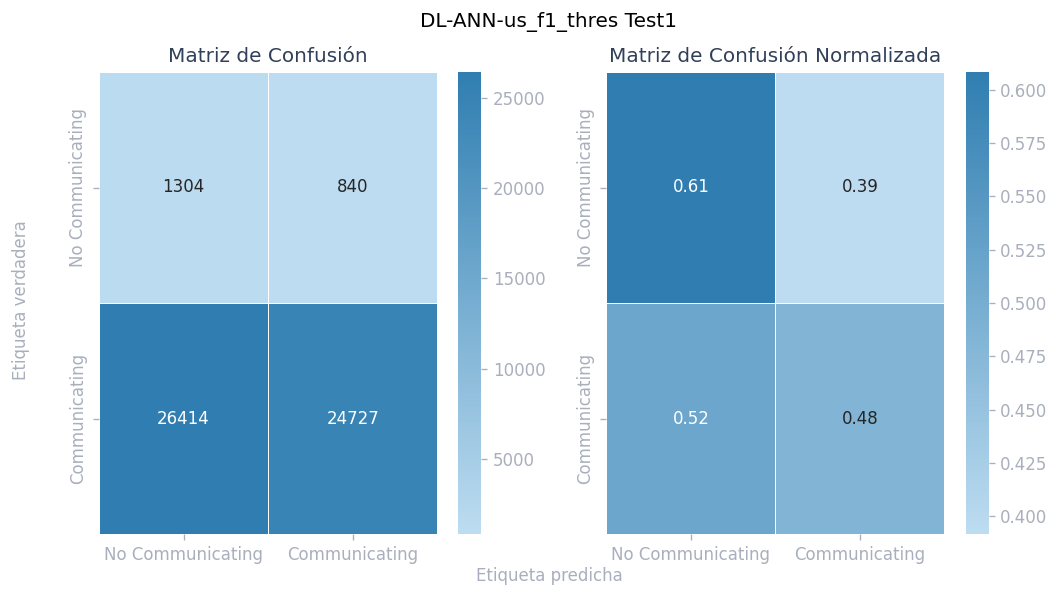

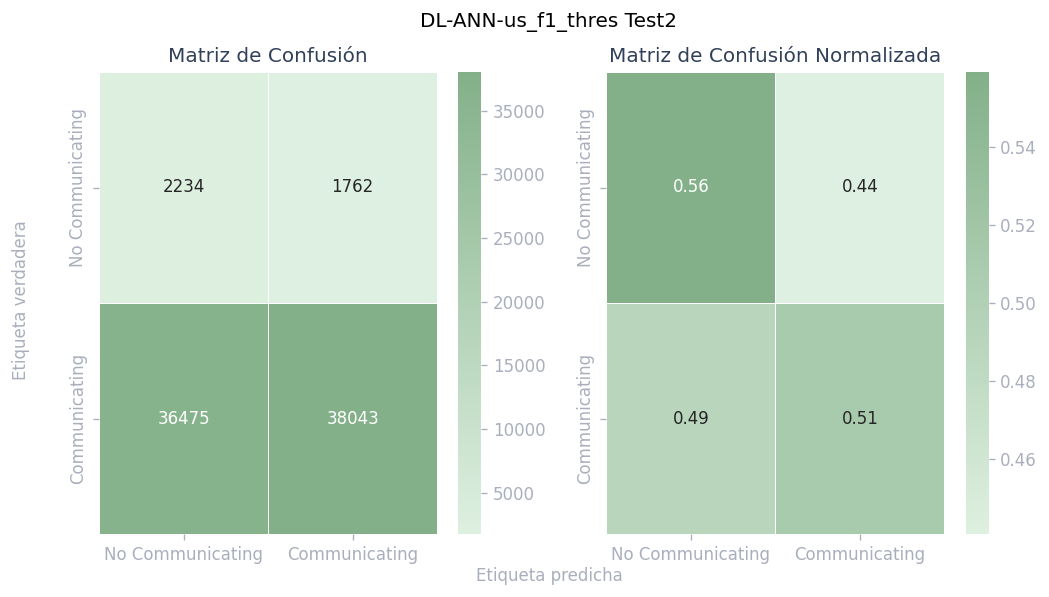

Metrics for DL-ANN-us Test 1_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.04081824153138782
F1 Score Micro: 0.04081824153138782
F1 Score Macro: 0.039307558233116754
F1 Score Weighted: 0.004277293412772578
Precission: 1.0
Recall: 0.0006061672630570384
Metrics for DL-ANN-us Test 2_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.0515449473979163
F1 Score Micro: 0.051544947397916305
F1 Score Macro: 0.049146816903505405
F1 Score Weighted: 0.006255374162738297
Precission: 0.9811320754716981
Recall: 0.0006978179768646501


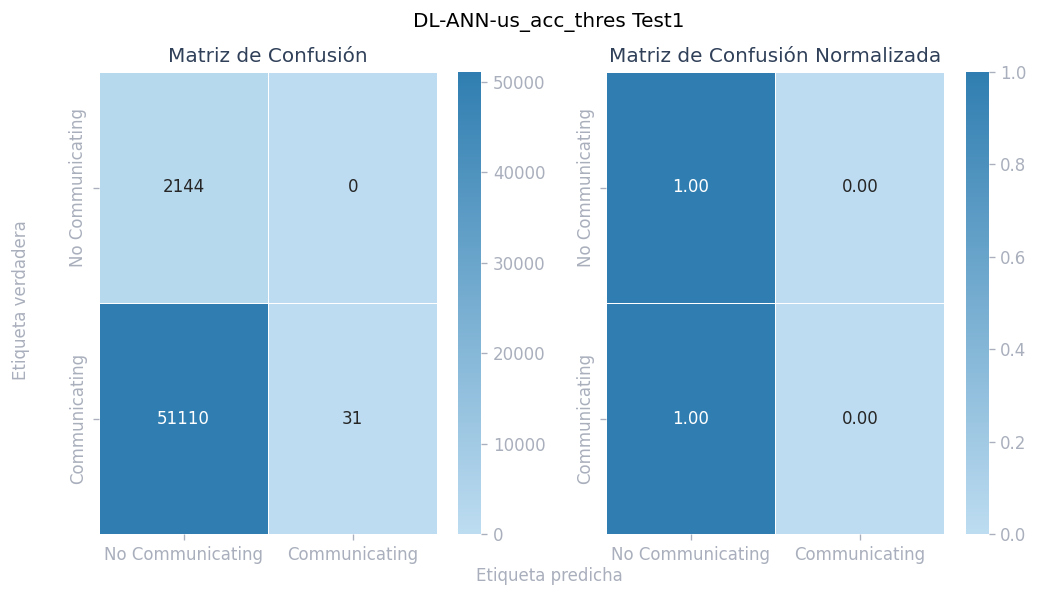

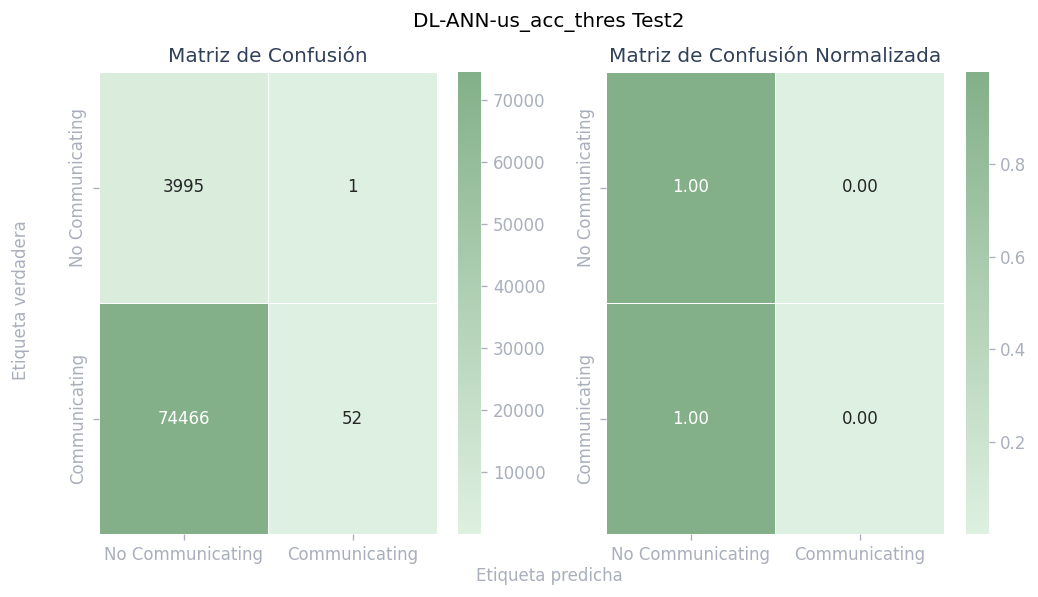

Metrics for DL-ANN-us Test 1_mpca_thres
Thres Value: 0.46999999999999986
Accuracy: 0.9425354227268462
F1 Score Micro: 0.9425354227268462
F1 Score Macro: 0.5223562236601433
F1 Score Weighted: 0.9342961203460438
Precission: 0.9612248421941252
Recall: 0.9796445122308911
Metrics for DL-ANN-us Test 2_mpca_thres
Thres Value: 0.46999999999999986
Accuracy: 0.938558728379652
F1 Score Micro: 0.938558728379652
F1 Score Macro: 0.5036543264340668
F1 Score Weighted: 0.9209717704976169
Precission: 0.9496967350625887
Recall: 0.9875734721812179


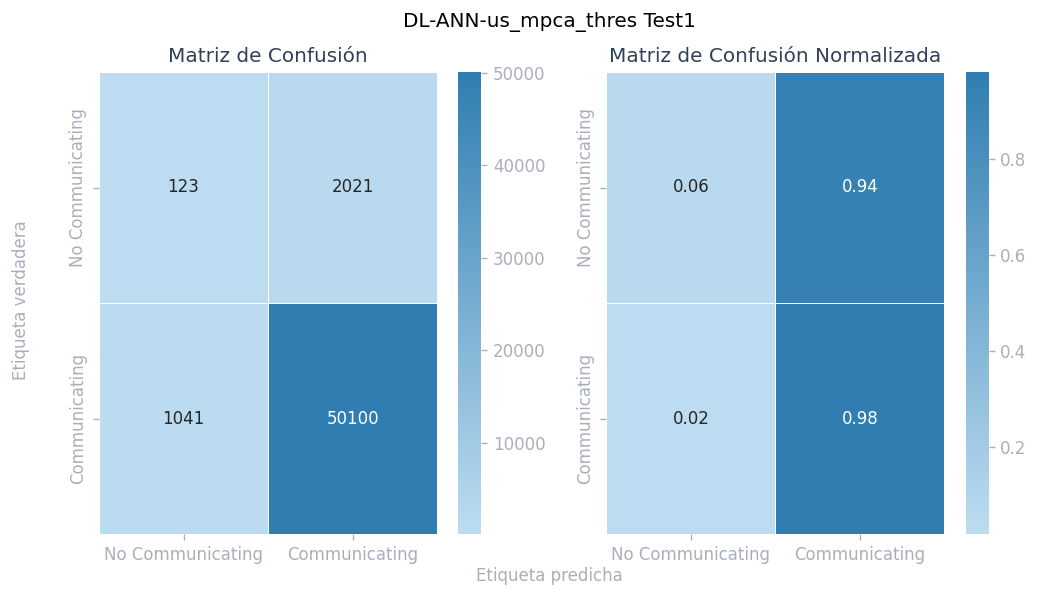

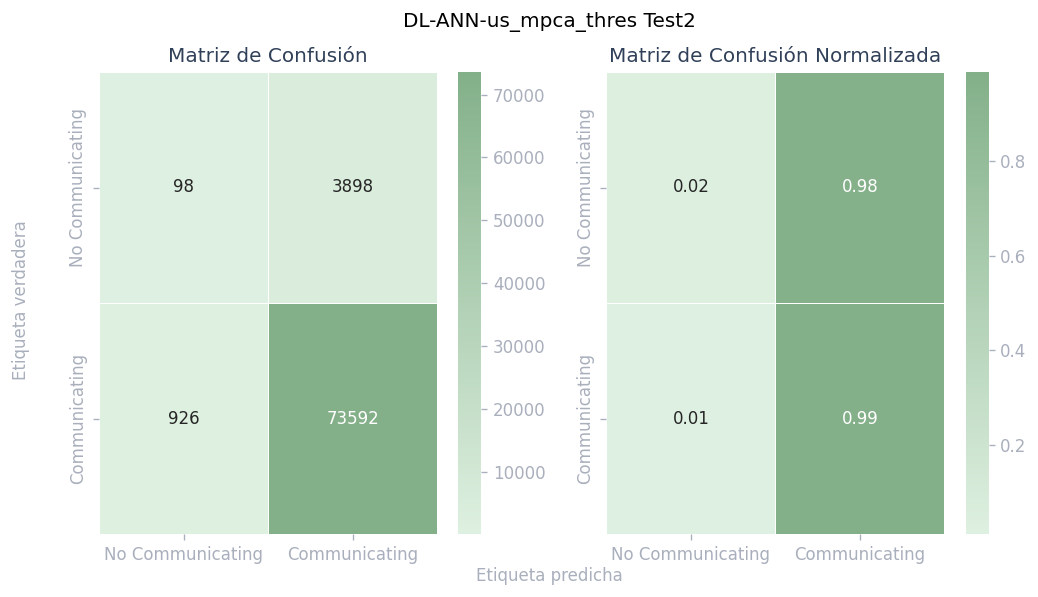

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-us",temp_thresholds)


2454/2454 [==============================] - 2s 825us/step
Metrics for DL-ANN-os_1 Test 1_f1_thres
Thres Value: 0.44999999999999984
Accuracy: 0.8064933846298208
F1 Score Micro: 0.8064933846298208
F1 Score Macro: 0.5658744404477993
F1 Score Weighted: 0.8630664346017319
Precission: 0.9882336059692926
Recall: 0.8080014078723529
Metrics for DL-ANN-os_1 Test 2_f1_thres
Thres Value: 0.44999999999999984
Accuracy: 0.7981506482920243
F1 Score Micro: 0.7981506482920244
F1 Score Macro: 0.5650442833896664
F1 Score Weighted: 0.8510515742773813
Precission: 0.9771936103067964
Recall: 0.8061407981964089


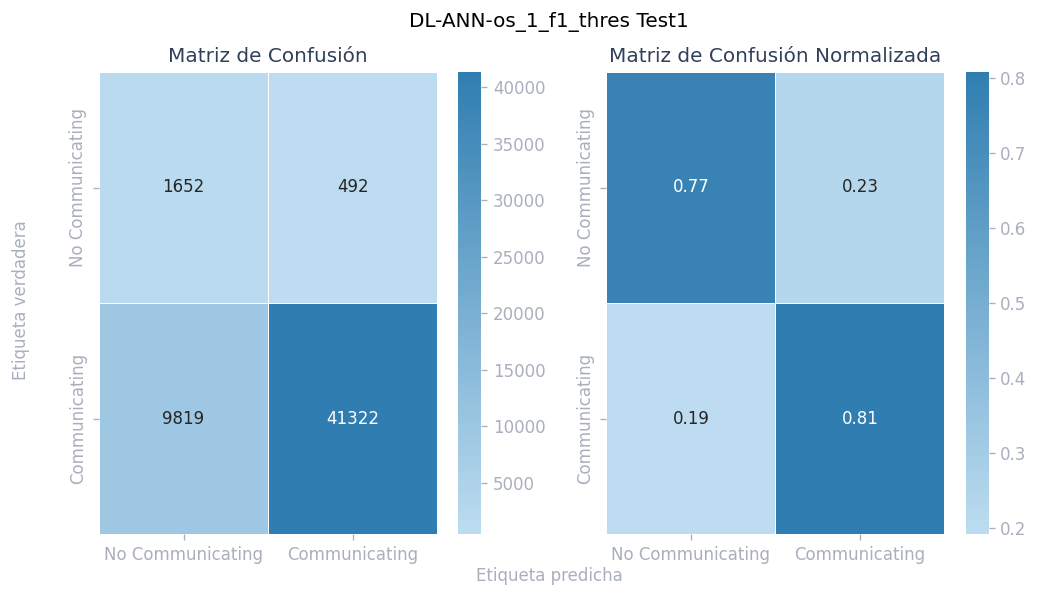

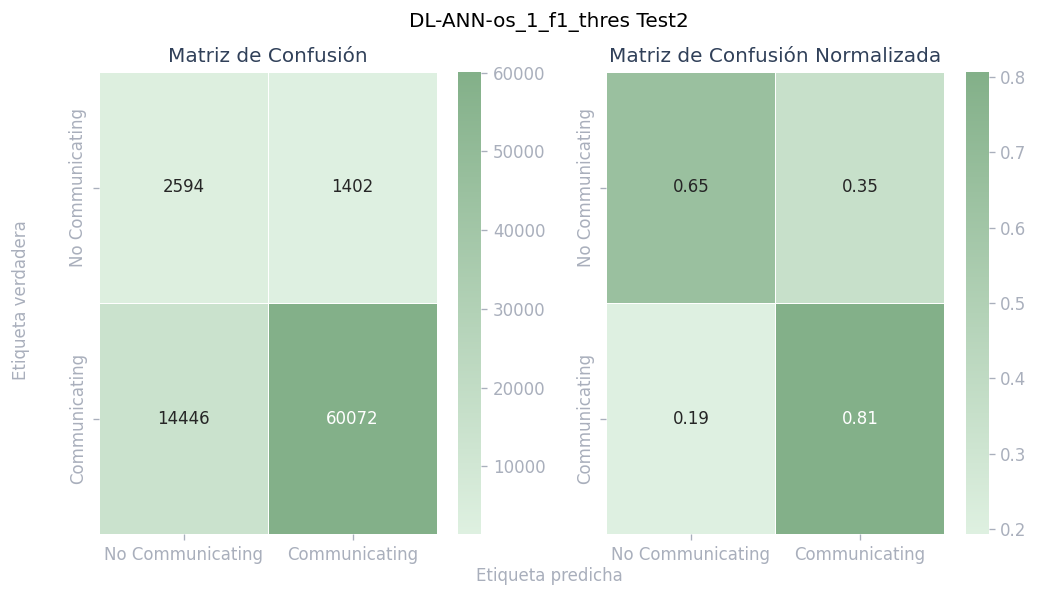

Metrics for DL-ANN-os_1 Test 1_acc_thres
Thres Value: 0.44999999999999984
Accuracy: 0.8064933846298208
F1 Score Micro: 0.8064933846298208
F1 Score Macro: 0.5658744404477993
F1 Score Weighted: 0.8630664346017319
Precission: 0.9882336059692926
Recall: 0.8080014078723529
Metrics for DL-ANN-os_1 Test 2_acc_thres
Thres Value: 0.44999999999999984
Accuracy: 0.7981506482920243
F1 Score Micro: 0.7981506482920244
F1 Score Macro: 0.5650442833896664
F1 Score Weighted: 0.8510515742773813
Precission: 0.9771936103067964
Recall: 0.8061407981964089


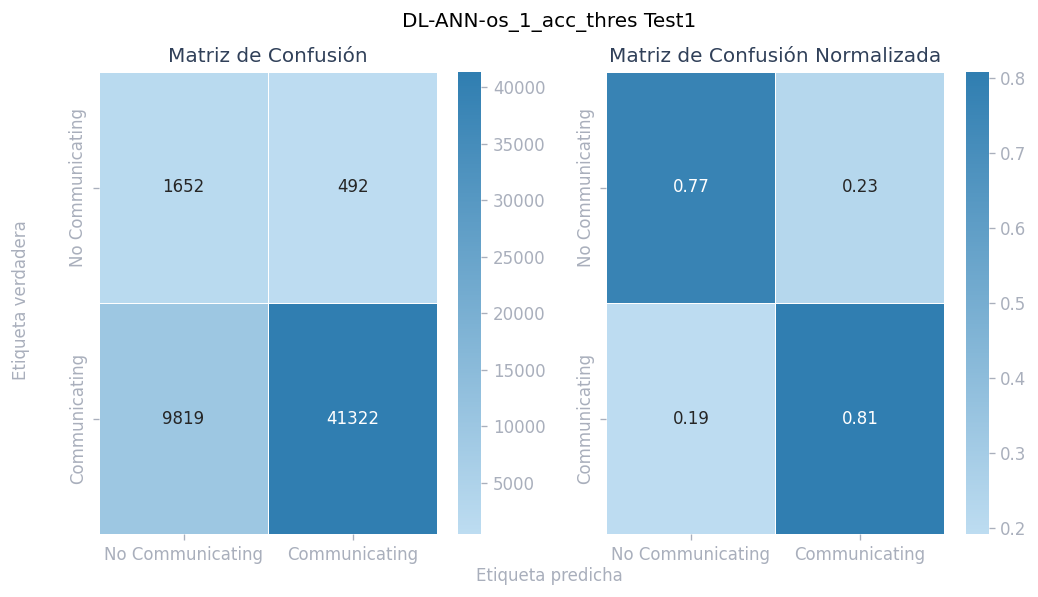

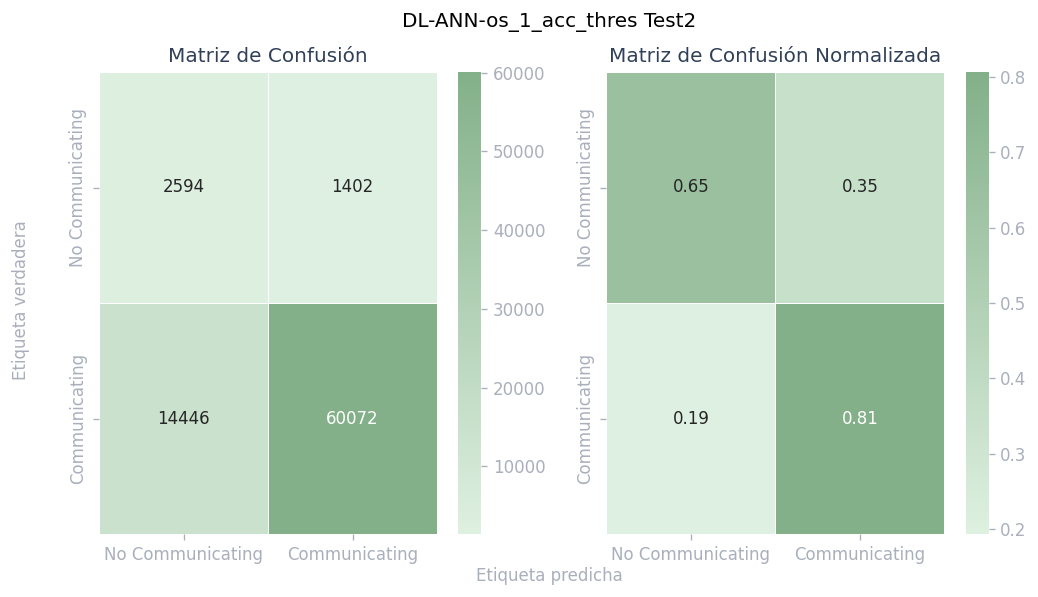

Metrics for DL-ANN-os_1 Test 1_mpca_thres
Thres Value: 0.44999999999999984
Accuracy: 0.8064933846298208
F1 Score Micro: 0.8064933846298208
F1 Score Macro: 0.5658744404477993
F1 Score Weighted: 0.8630664346017319
Precission: 0.9882336059692926
Recall: 0.8080014078723529
Metrics for DL-ANN-os_1 Test 2_mpca_thres
Thres Value: 0.44999999999999984
Accuracy: 0.7981506482920243
F1 Score Micro: 0.7981506482920244
F1 Score Macro: 0.5650442833896664
F1 Score Weighted: 0.8510515742773813
Precission: 0.9771936103067964
Recall: 0.8061407981964089


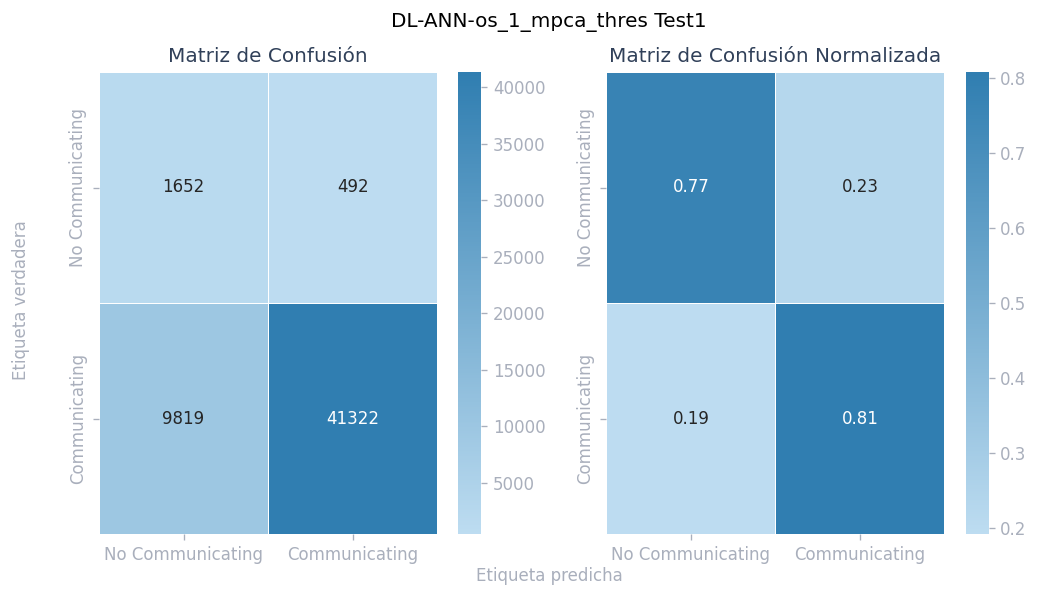

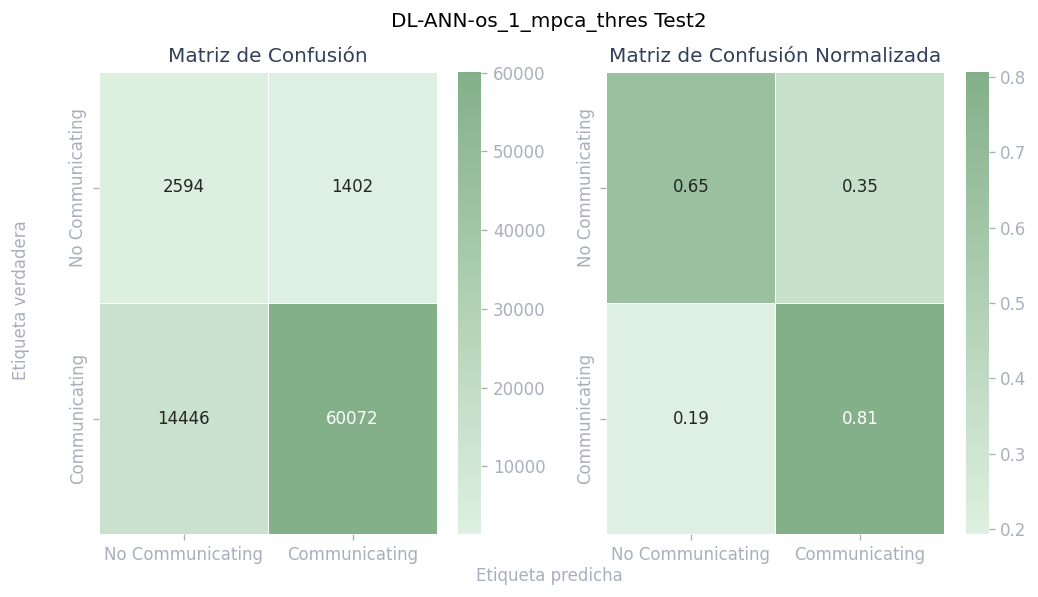

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_1")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_1",temp_thresholds)

2454/2454 [==============================] - 2s 863us/step
Metrics for DL-ANN-os_1_extra_us Test 1_f1_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7780989021300554
F1 Score Micro: 0.7780989021300554
F1 Score Macro: 0.5473906860464763
F1 Score Weighted: 0.844528410817055
Precission: 0.9891756040510613
Recall: 0.7773019690659158
Metrics for DL-ANN-os_1_extra_us Test 2_f1_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7708052067147261
F1 Score Micro: 0.7708052067147261
F1 Score Macro: 0.5476645569502707
F1 Score Weighted: 0.8330272353923582
Precission: 0.977866454743748
Recall: 0.7760809468853163


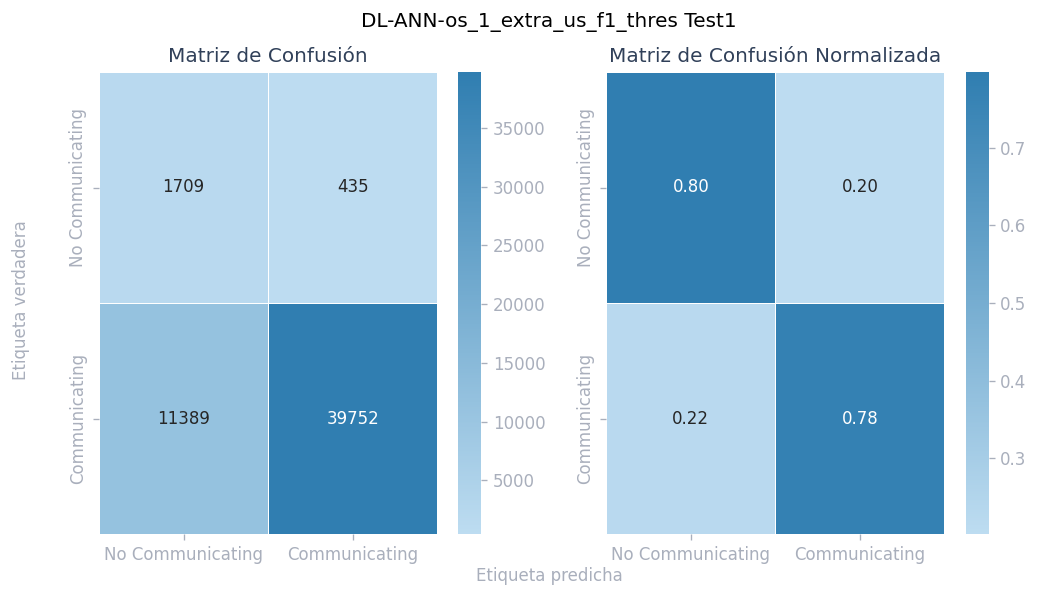

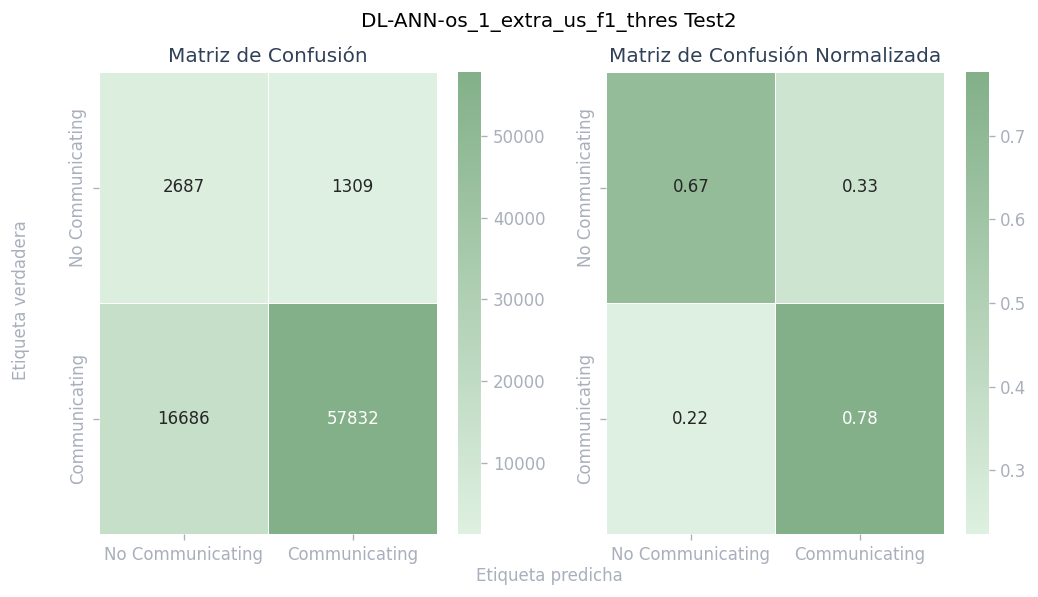

Metrics for DL-ANN-os_1_extra_us Test 1_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7727690719714742
F1 Score Micro: 0.7727690719714742
F1 Score Macro: 0.5442595858048869
F1 Score Weighted: 0.8409991181179524
Precission: 0.9894420062695924
Recall: 0.7714749418274965
Metrics for DL-ANN-os_1_extra_us Test 2_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7647935400056041
F1 Score Micro: 0.7647935400056041
F1 Score Macro: 0.5441308620789622
F1 Score Weighted: 0.8290109238225345
Precission: 0.9780795278142645
Recall: 0.7694248369521458


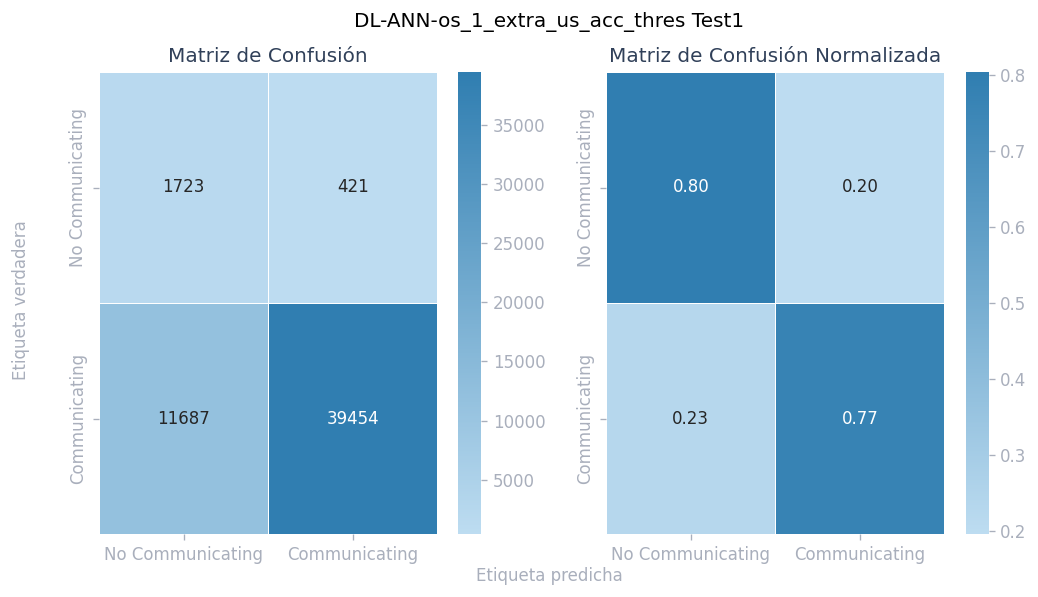

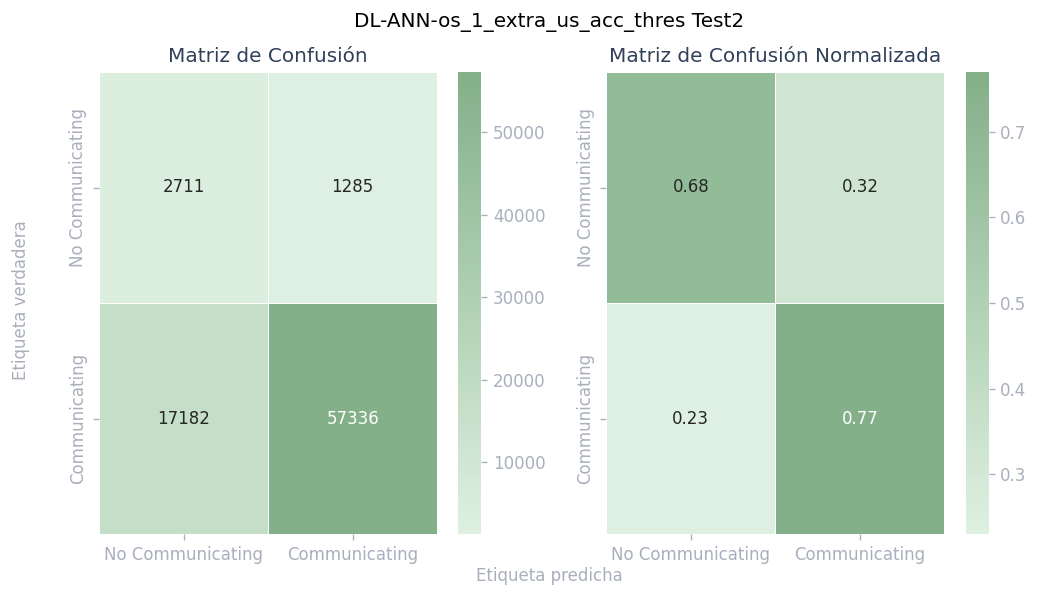

Metrics for DL-ANN-os_1_extra_us Test 1_mpca_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7780989021300554
F1 Score Micro: 0.7780989021300554
F1 Score Macro: 0.5473906860464763
F1 Score Weighted: 0.844528410817055
Precission: 0.9891756040510613
Recall: 0.7773019690659158
Metrics for DL-ANN-os_1_extra_us Test 2_mpca_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7708052067147261
F1 Score Micro: 0.7708052067147261
F1 Score Macro: 0.5476645569502707
F1 Score Weighted: 0.8330272353923582
Precission: 0.977866454743748
Recall: 0.7760809468853163


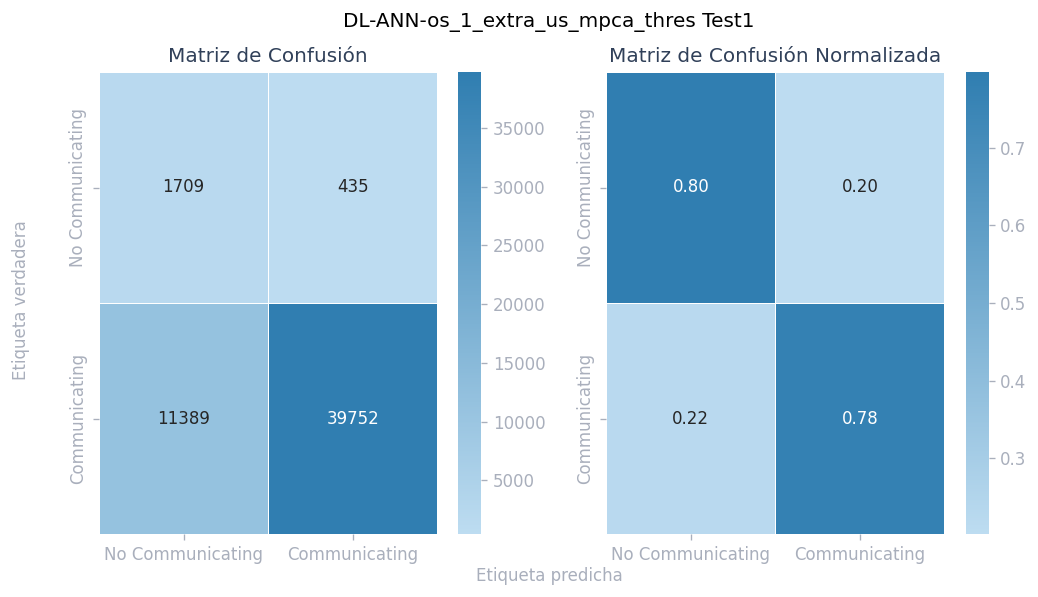

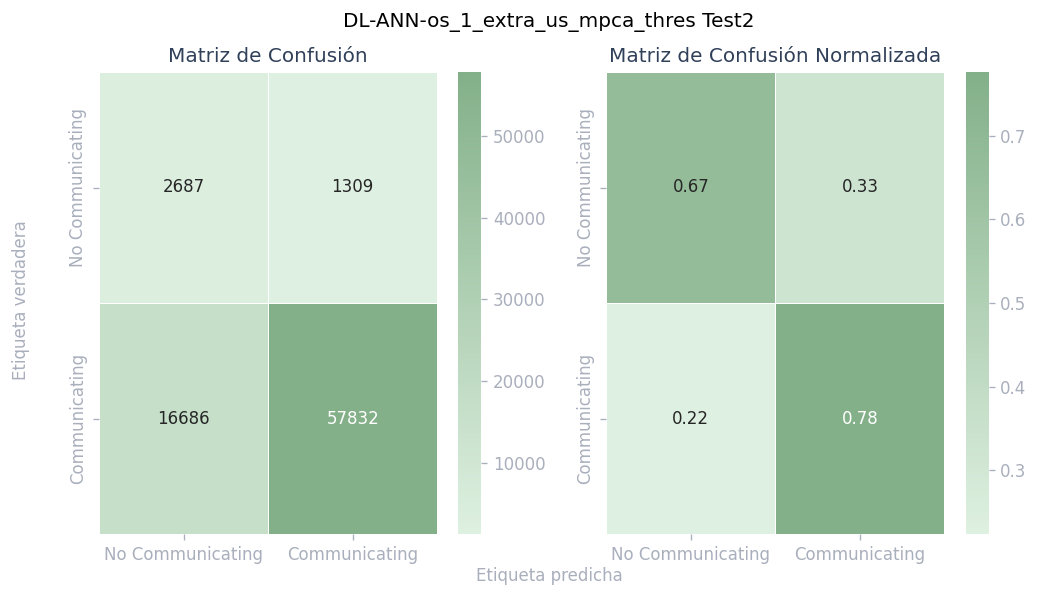

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_1_extra_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_1_extra_us",temp_thresholds)

2454/2454 [==============================] - 2s 873us/step
Metrics for DL-ANN-os_1_extra_t Test 1_f1_thres
Thres Value: 0.16999999999999998
Accuracy: 0.9426104907572488
F1 Score Micro: 0.9426104907572488
F1 Score Macro: 0.6850102659893833
F1 Score Weighted: 0.9469406250686184
Precission: 0.9776678389064394
Recall: 0.9621829842983125
Metrics for DL-ANN-os_1_extra_t Test 2_f1_thres
Thres Value: 0.16999999999999998
Accuracy: 0.9259240390248873
F1 Score Micro: 0.9259240390248873
F1 Score Macro: 0.6317612132181696
F1 Score Weighted: 0.9273828223831216
Precission: 0.9631387353377376
Recall: 0.9586408652942913


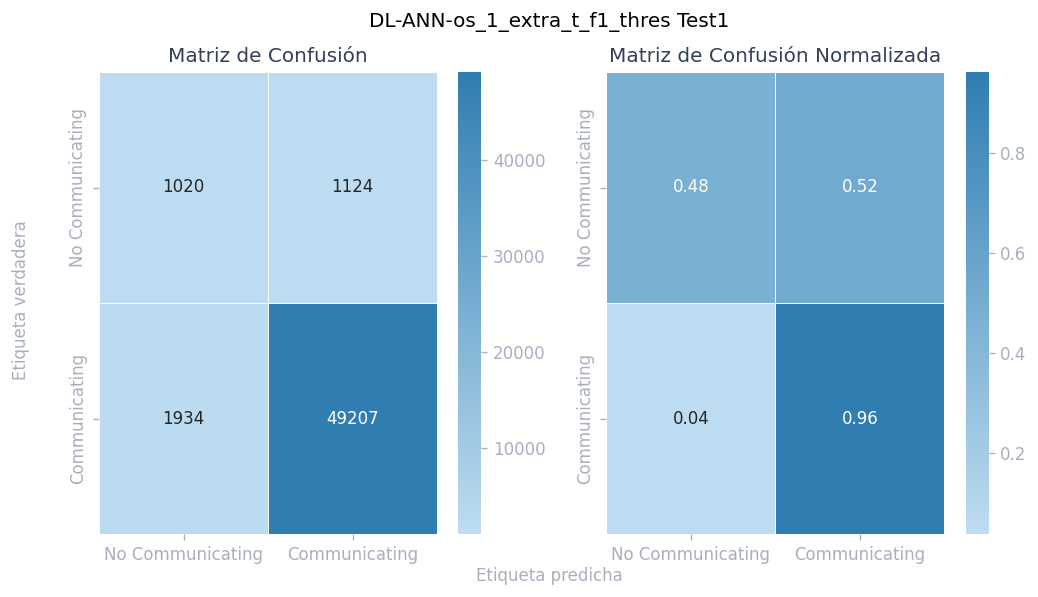

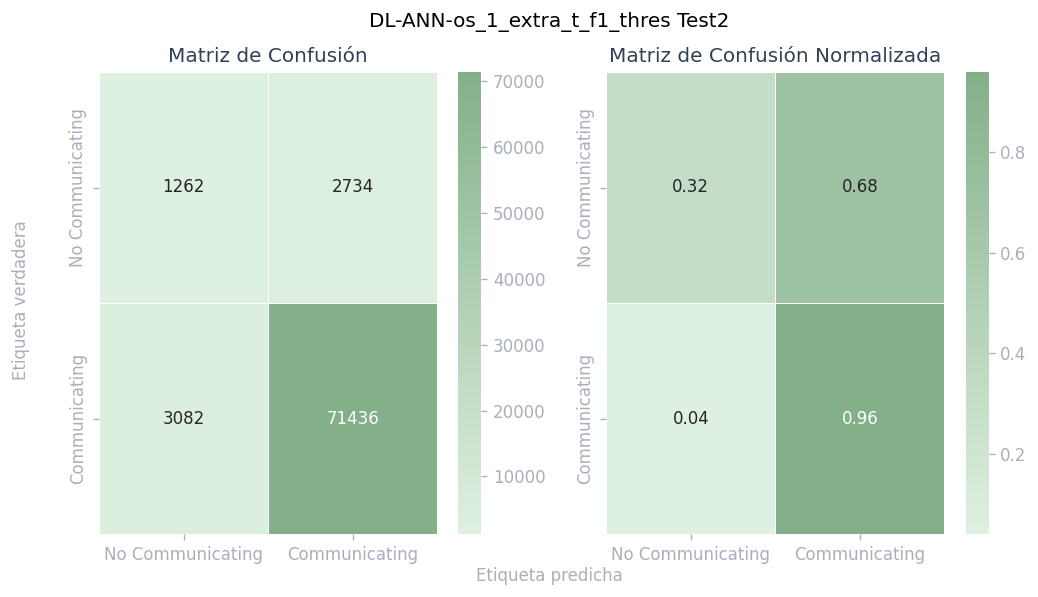

Metrics for DL-ANN-os_1_extra_t Test 1_acc_thres
Thres Value: 0.1
Accuracy: 0.9576803978605611
F1 Score Micro: 0.9576803978605611
F1 Score Macro: 0.6780130669038205
F1 Score Weighted: 0.953946619358259
Precission: 0.9718361516485213
Recall: 0.9844351889873096
Metrics for DL-ANN-os_1_extra_t Test 2_acc_thres
Thres Value: 0.1
Accuracy: 0.9400998548029651
F1 Score Micro: 0.9400998548029651
F1 Score Macro: 0.6053183208405144
F1 Score Weighted: 0.9318172399275129
Precission: 0.9574613076126699
Recall: 0.9804476770713116


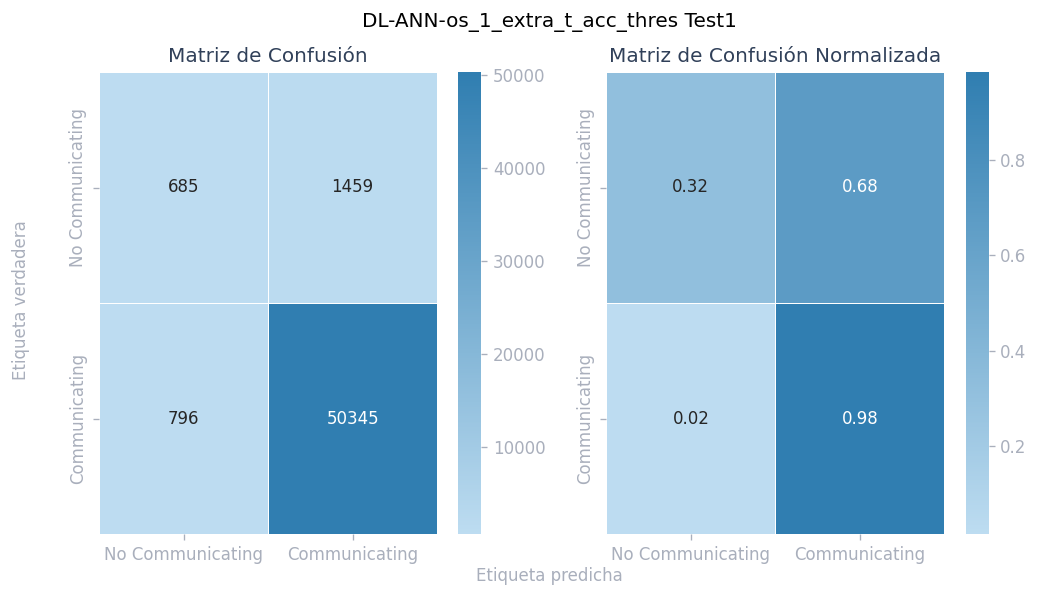

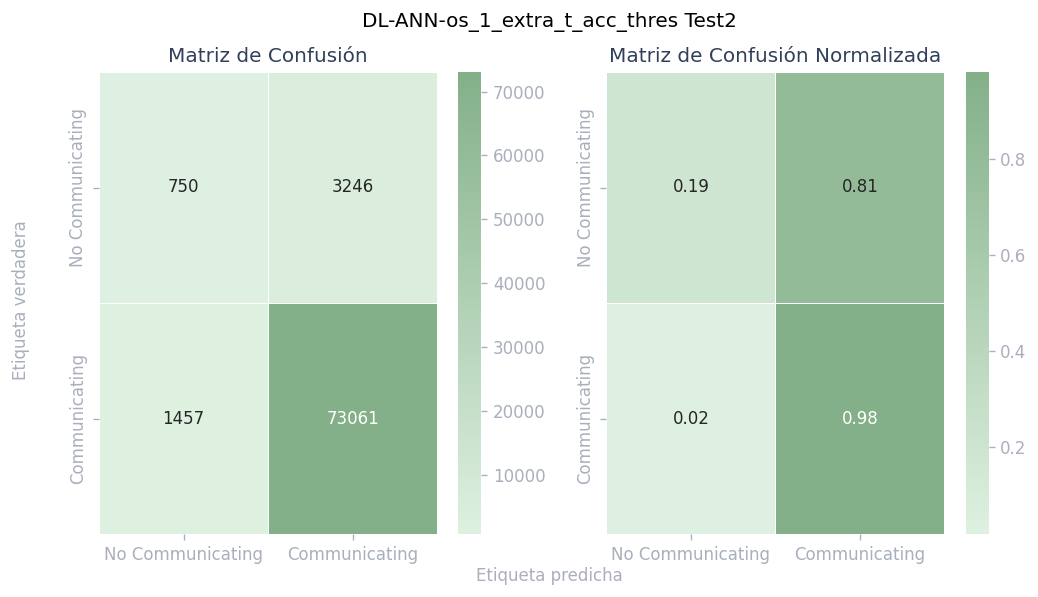

Metrics for DL-ANN-os_1_extra_t Test 1_mpca_thres
Thres Value: 0.44999999999999984
Accuracy: 0.8064933846298208
F1 Score Micro: 0.8064933846298208
F1 Score Macro: 0.5658744404477993
F1 Score Weighted: 0.8630664346017319
Precission: 0.9882336059692926
Recall: 0.8080014078723529
Metrics for DL-ANN-os_1_extra_t Test 2_mpca_thres
Thres Value: 0.44999999999999984
Accuracy: 0.7981506482920243
F1 Score Micro: 0.7981506482920244
F1 Score Macro: 0.5650442833896664
F1 Score Weighted: 0.8510515742773813
Precission: 0.9771936103067964
Recall: 0.8061407981964089


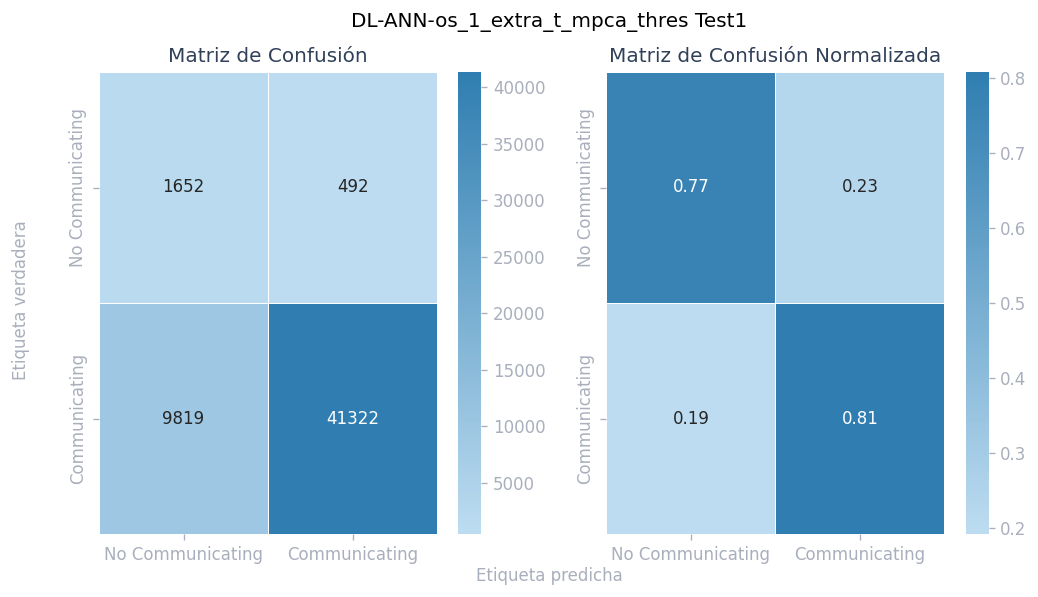

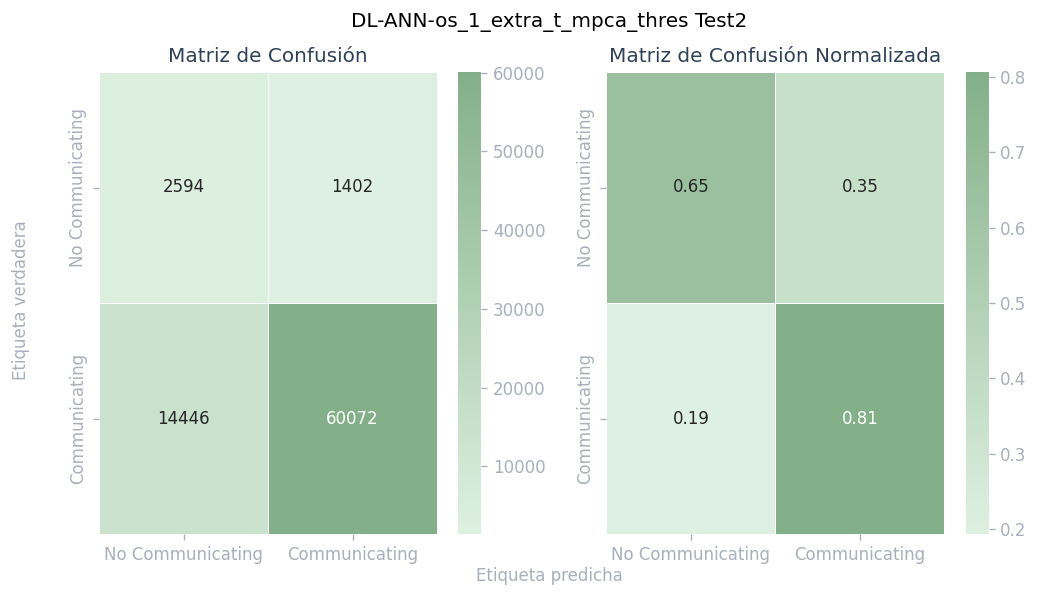

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_1_extra_t")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_1_extra_t",temp_thresholds)

2454/2454 [==============================] - 2s 950us/step
Metrics for DL-ANN-os_2 Test 1_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7922867598761377
F1 Score Micro: 0.7922867598761377
F1 Score Macro: 0.5583410305341157
F1 Score Weighted: 0.8539146078160593
Precission: 0.9895907147220525
Recall: 0.7919086447273225
Metrics for DL-ANN-os_2 Test 2_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7791221947678121
F1 Score Micro: 0.7791221947678121
F1 Score Macro: 0.5528444127686719
F1 Score Weighted: 0.8385559672724205
Precission: 0.9776767811789868
Recall: 0.7852062588904695


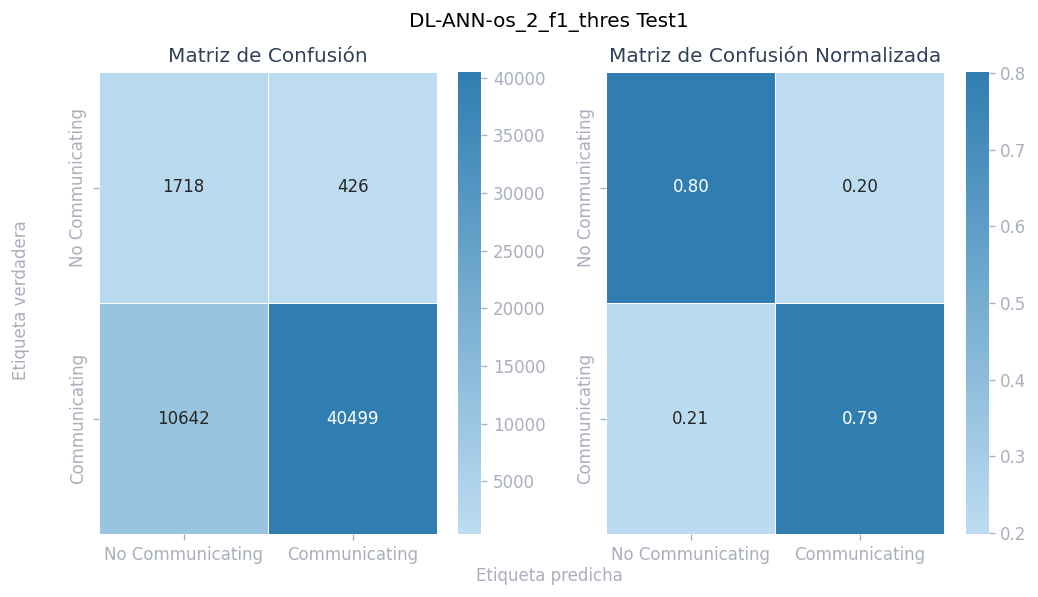

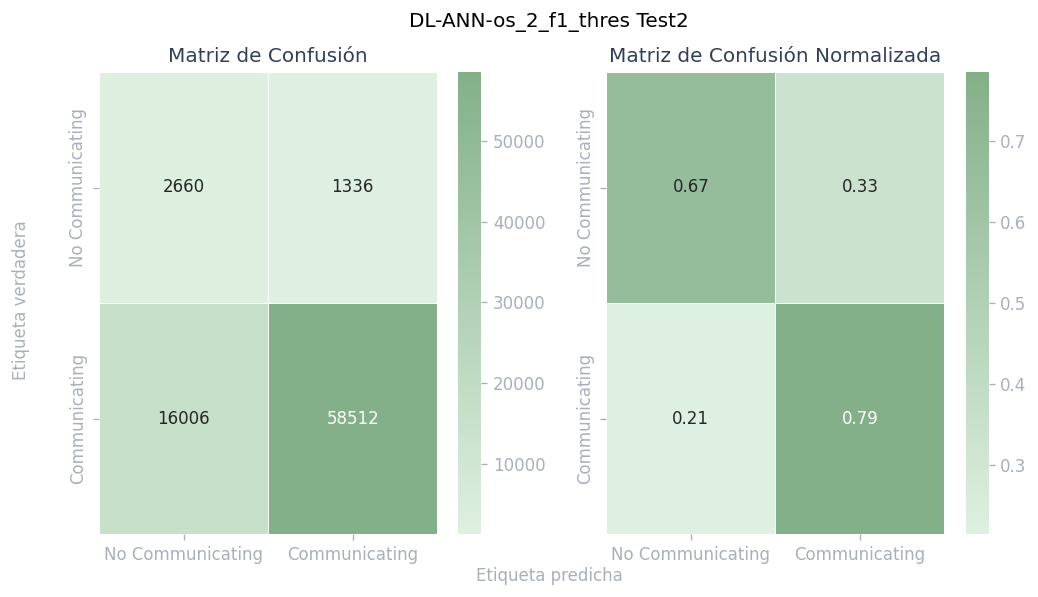

Metrics for DL-ANN-os_2 Test 1_acc_thres
Thres Value: 0.5699999999999997
Accuracy: 0.7450502017453317
F1 Score Micro: 0.7450502017453315
F1 Score Macro: 0.5292376586752351
F1 Score Weighted: 0.8223294922803551
Precission: 0.9912877400450003
Recall: 0.7408732719344557
Metrics for DL-ANN-os_2 Test 2_acc_thres
Thres Value: 0.5699999999999997
Accuracy: 0.7317803194334769
F1 Score Micro: 0.7317803194334769
F1 Score Macro: 0.5243484525120792
F1 Score Weighted: 0.8064852366165134
Precission: 0.9786372996687259
Recall: 0.7334066936847473


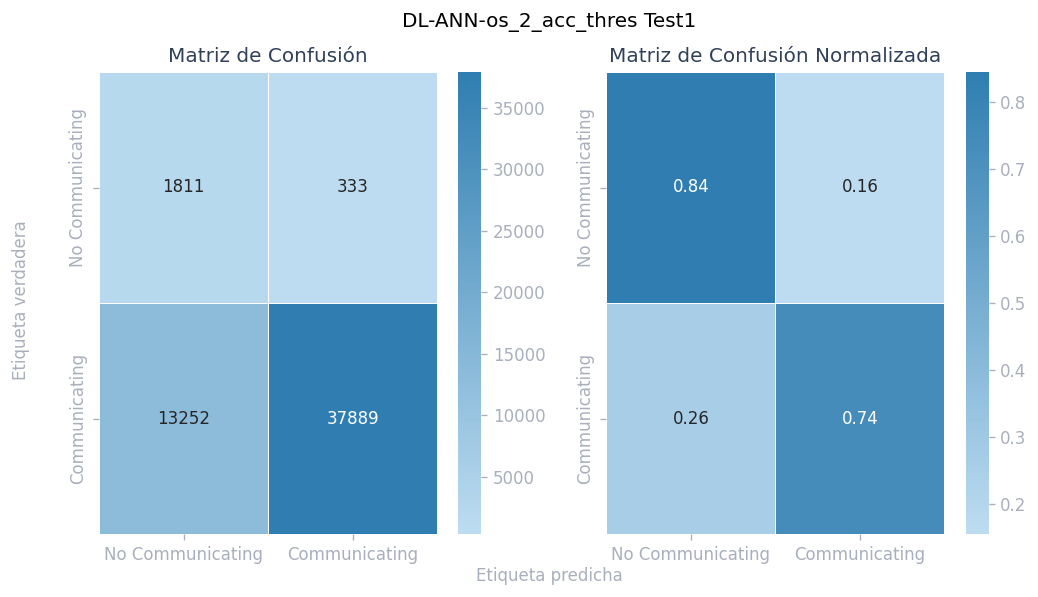

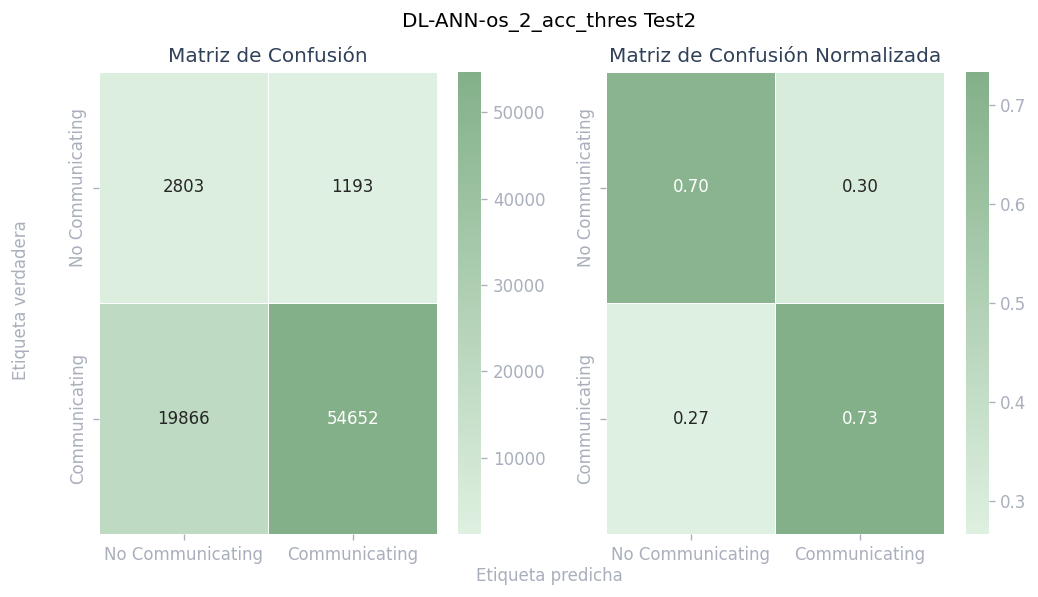

Metrics for DL-ANN-os_2 Test 1_mpca_thres
Thres Value: 0.45999999999999985
Accuracy: 0.823383691470395
F1 Score Micro: 0.8233836914703951
F1 Score Macro: 0.5803599444003122
F1 Score Weighted: 0.8740081450215909
Precission: 0.9887103574272732
Recall: 0.8254042744568937
Metrics for DL-ANN-os_2 Test 2_mpca_thres
Thres Value: 0.45999999999999985
Accuracy: 0.8107980742288
F1 Score Micro: 0.8107980742288
F1 Score Macro: 0.57301587187401
F1 Score Weighted: 0.8592181294641602
Precission: 0.9766405164011696
Recall: 0.8202716122279181


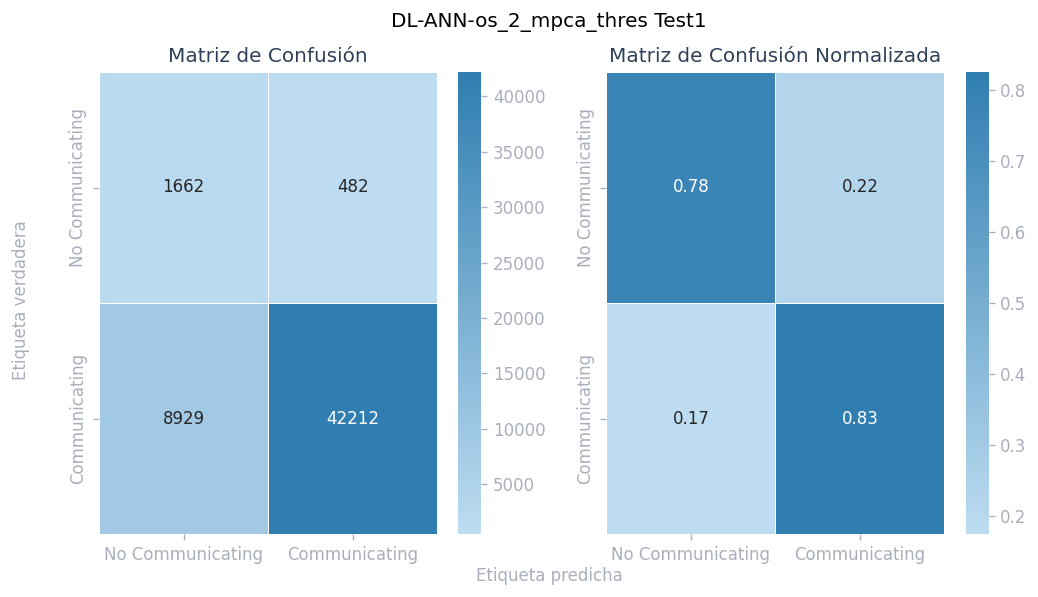

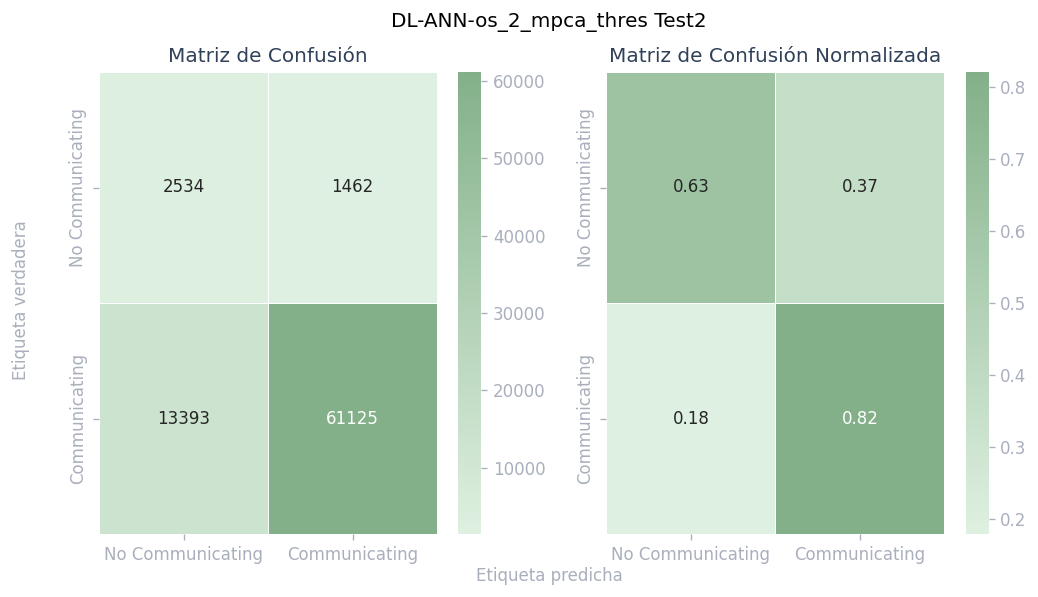

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_2")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_2",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL-ANN-os_2_extra_us Test 1_f1_thres
Thres Value: 0.5599999999999997
Accuracy: 0.7543774045228488
F1 Score Micro: 0.7543774045228488
F1 Score Macro: 0.534646521196317
F1 Score Weighted: 0.8286832299318102
Precission: 0.9908924378853944
Recall: 0.7509825775796328
Metrics for DL-ANN-os_2_extra_us Test 2_f1_thres
Thres Value: 0.5599999999999997
Accuracy: 0.7409888682273225
F1 Score Micro: 0.7409888682273226
F1 Score Macro: 0.5298705735726051
F1 Score Weighted: 0.8128462905992515
Precission: 0.9785550256138491
Recall: 0.743390858584503


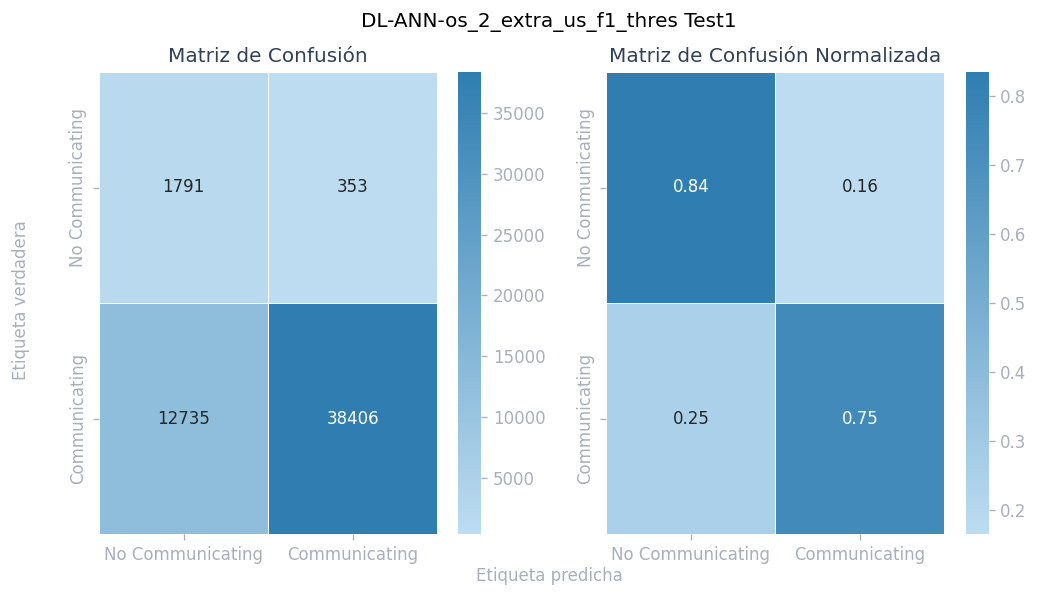

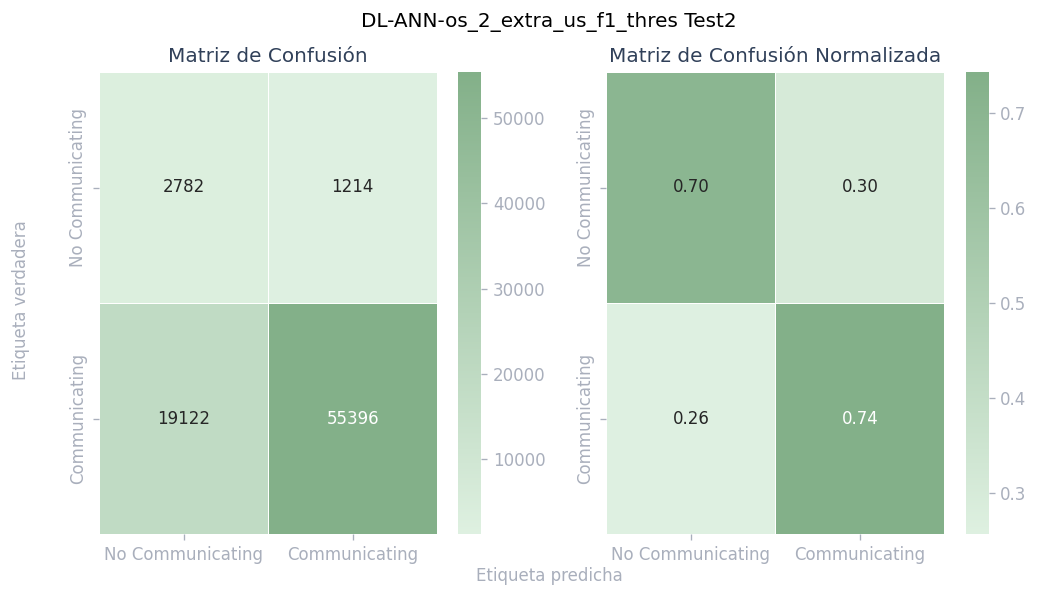

Metrics for DL-ANN-os_2_extra_us Test 1_acc_thres
Thres Value: 0.5599999999999997
Accuracy: 0.7543774045228488
F1 Score Micro: 0.7543774045228488
F1 Score Macro: 0.534646521196317
F1 Score Weighted: 0.8286832299318102
Precission: 0.9908924378853944
Recall: 0.7509825775796328
Metrics for DL-ANN-os_2_extra_us Test 2_acc_thres
Thres Value: 0.5599999999999997
Accuracy: 0.7409888682273225
F1 Score Micro: 0.7409888682273226
F1 Score Macro: 0.5298705735726051
F1 Score Weighted: 0.8128462905992515
Precission: 0.9785550256138491
Recall: 0.743390858584503


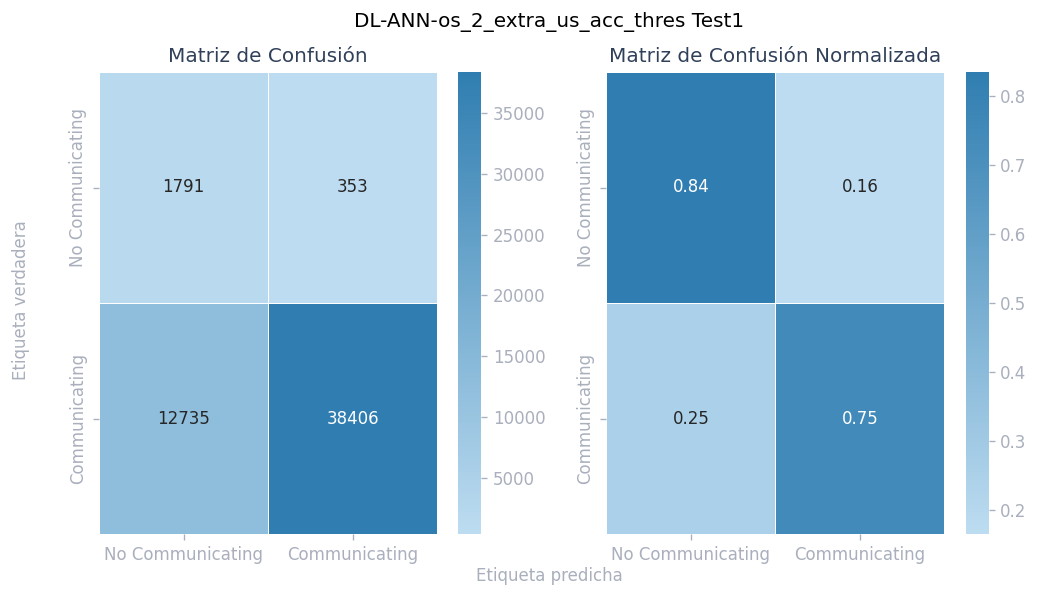

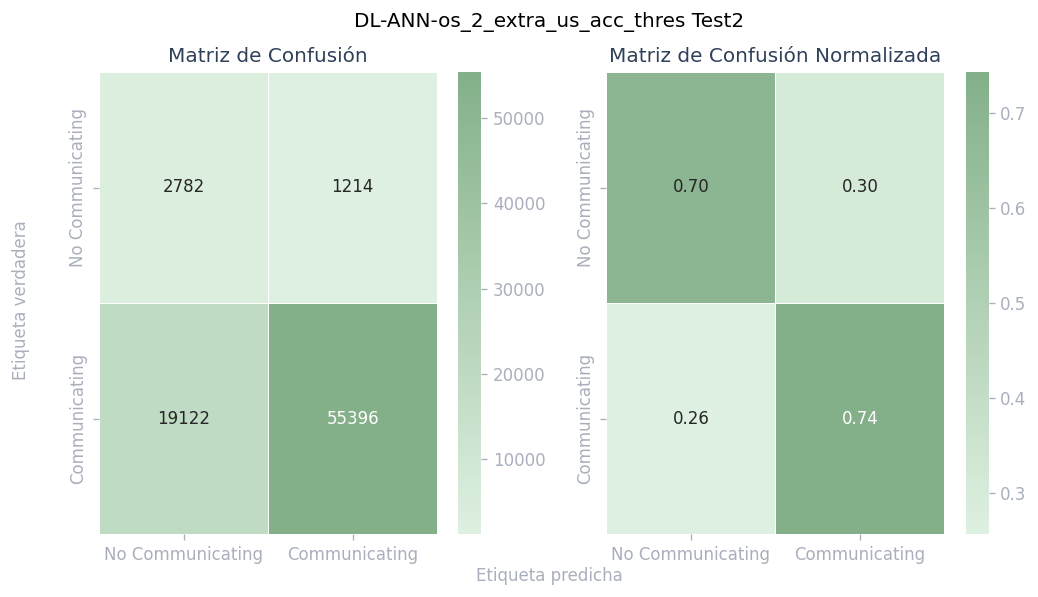

Metrics for DL-ANN-os_2_extra_us Test 1_mpca_thres
Thres Value: 0.5399999999999998
Accuracy: 0.7707422351506052
F1 Score Micro: 0.7707422351506052
F1 Score Macro: 0.5448887964565914
F1 Score Weighted: 0.839695012608404
Precission: 0.9904740303923792
Recall: 0.7685223206429284
Metrics for DL-ANN-os_2_extra_us Test 2_mpca_thres
Thres Value: 0.5399999999999998
Accuracy: 0.7571898005451257
F1 Score Micro: 0.7571898005451256
F1 Score Macro: 0.5394432866866053
F1 Score Weighted: 0.82388591348486
Precission: 0.9782001310751612
Recall: 0.761131538688639


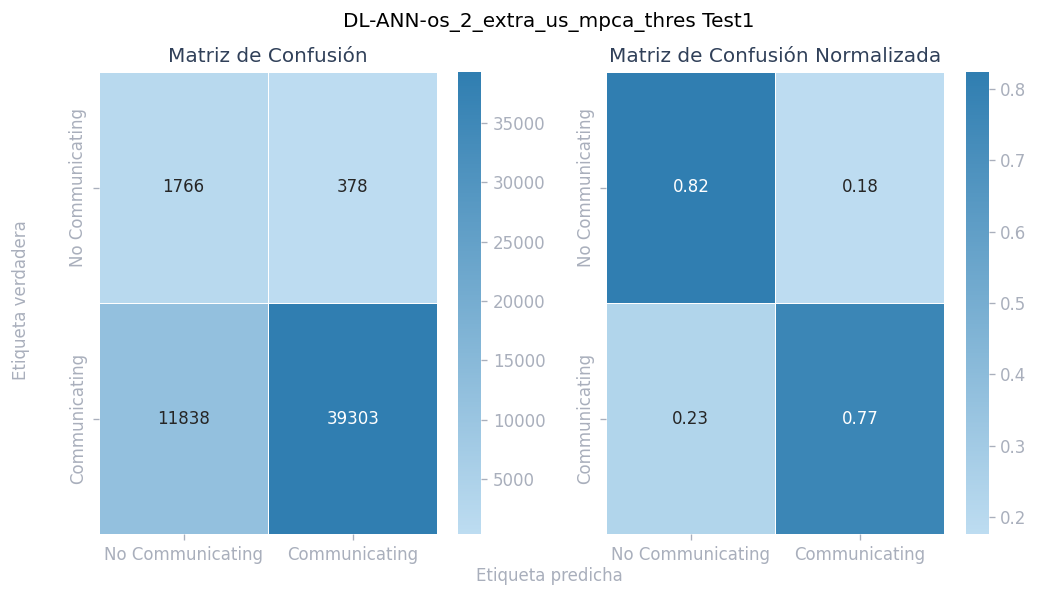

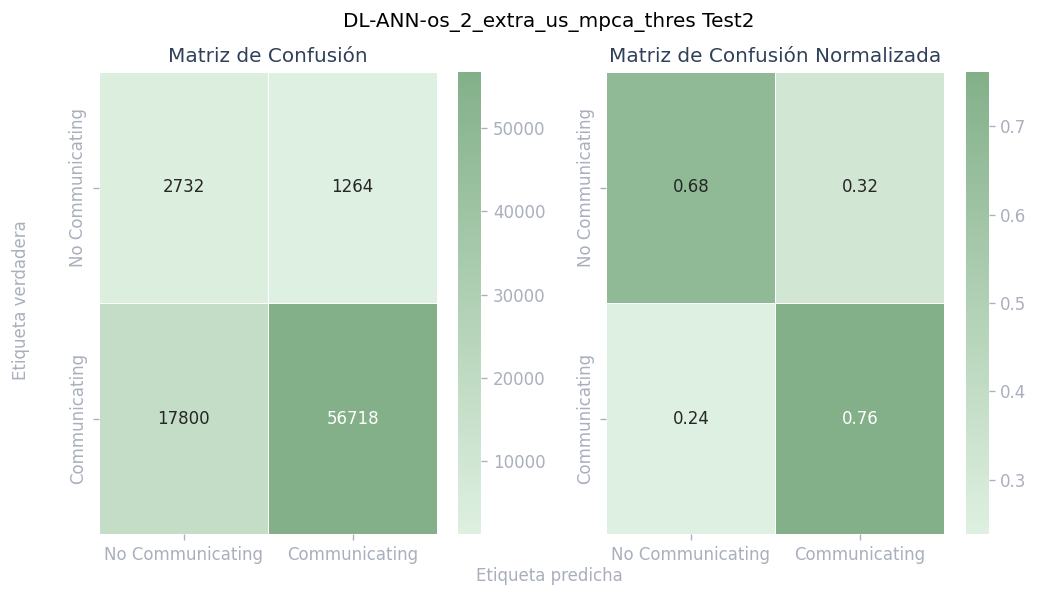

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_2_extra_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_2_extra_us",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL-ANN-os_2_extra_t Test 1_f1_thres
Thres Value: 0.13999999999999999
Accuracy: 0.9437177442056864
F1 Score Micro: 0.9437177442056864
F1 Score Macro: 0.6815189742073017
F1 Score Weighted: 0.947237372767963
Precission: 0.9767289867701814
Recall: 0.964333900393031
Metrics for DL-ANN-os_2_extra_t Test 2_f1_thres
Thres Value: 0.13999999999999999
Accuracy: 0.9269557021677662
F1 Score Micro: 0.9269557021677662
F1 Score Macro: 0.6312501217403463
F1 Score Weighted: 0.9278515375321015
Precission: 0.9628423390081421
Recall: 0.9600901795539333


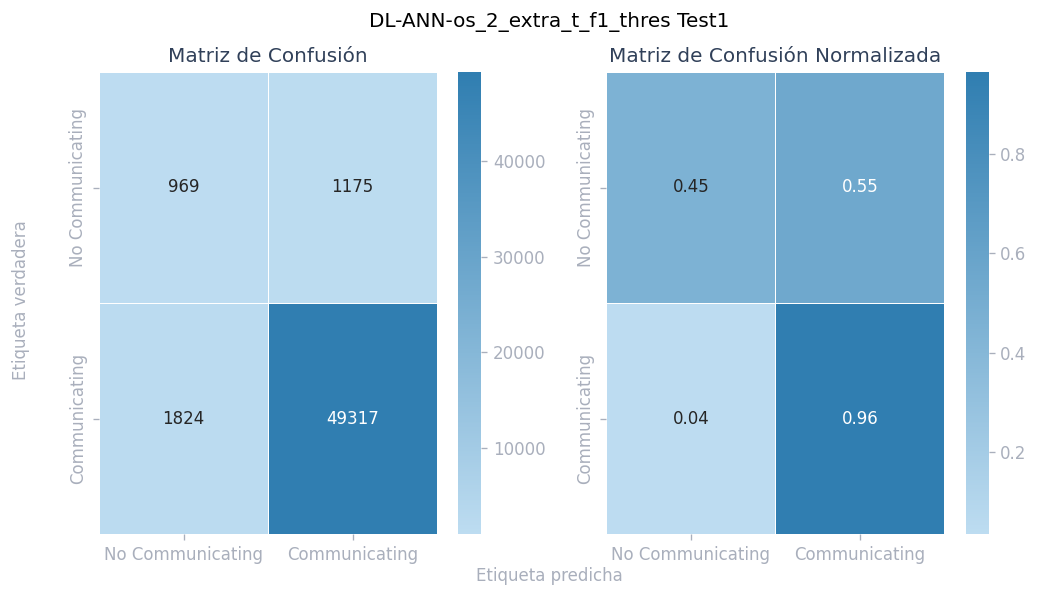

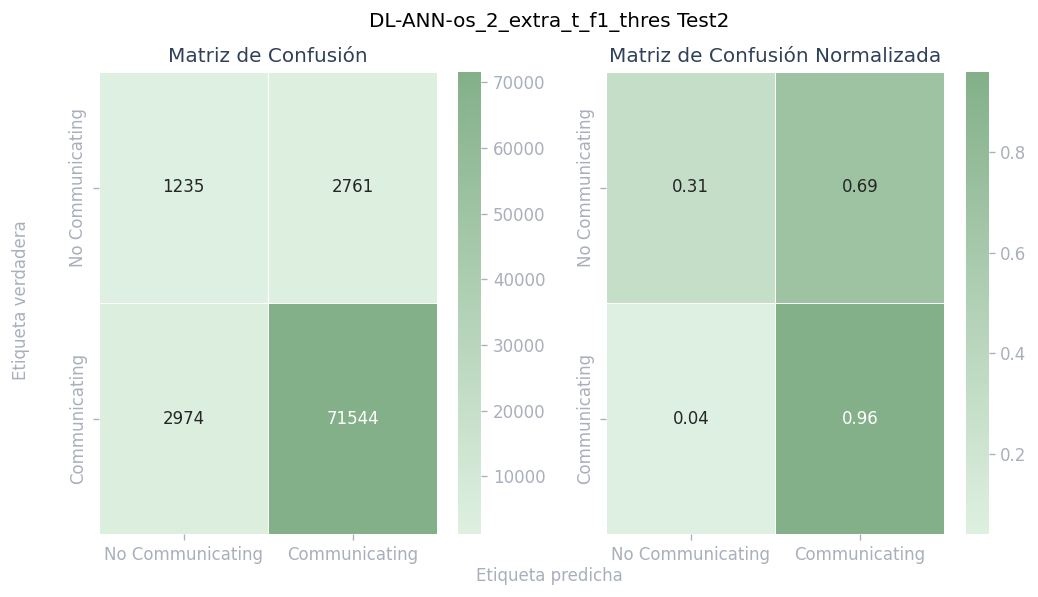

Metrics for DL-ANN-os_2_extra_t Test 1_acc_thres
Thres Value: 0.1
Accuracy: 0.9545463075912546
F1 Score Micro: 0.9545463075912546
F1 Score Macro: 0.6775330186148534
F1 Score Weighted: 0.952358784909156
Precission: 0.9727154528342163
Recall: 0.9801333567978725
Metrics for DL-ANN-os_2_extra_t Test 2_acc_thres
Thres Value: 0.1
Accuracy: 0.93778179687699
F1 Score Micro: 0.93778179687699
F1 Score Macro: 0.6129582660397791
F1 Score Weighted: 0.931436793459271
Precission: 0.9585764524584118
Recall: 0.9766499369279905


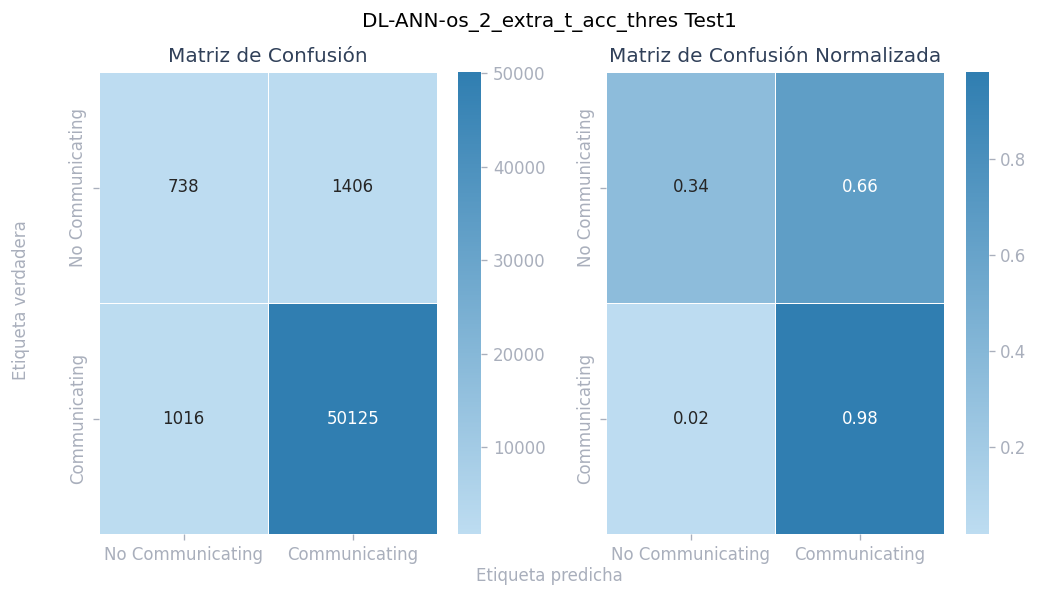

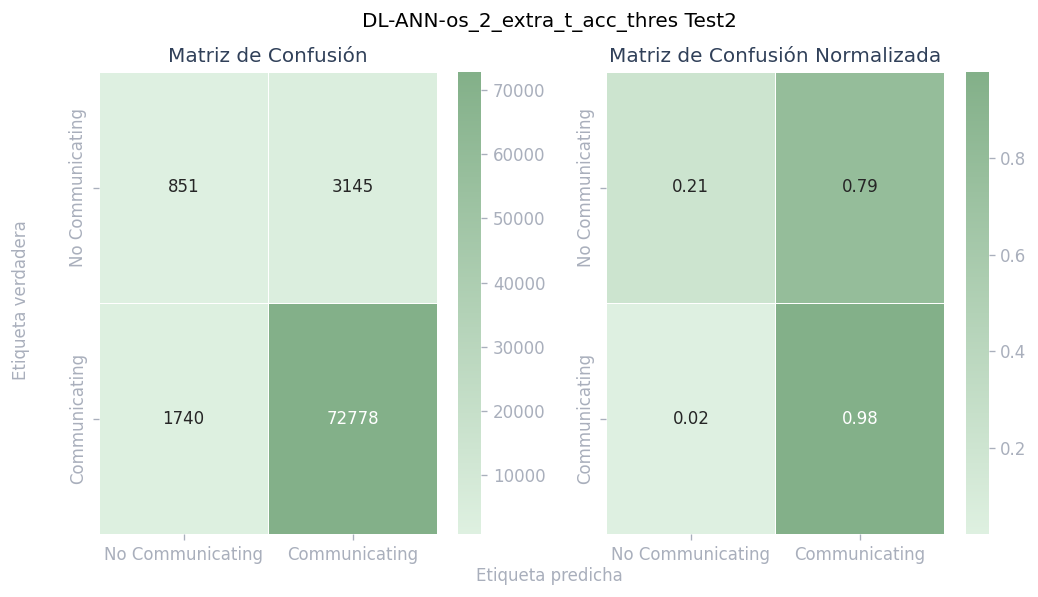

Metrics for DL-ANN-os_2_extra_t Test 1_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7922867598761377
F1 Score Micro: 0.7922867598761377
F1 Score Macro: 0.5583410305341157
F1 Score Weighted: 0.8539146078160593
Precission: 0.9895907147220525
Recall: 0.7919086447273225
Metrics for DL-ANN-os_2_extra_t Test 2_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.7791221947678121
F1 Score Micro: 0.7791221947678121
F1 Score Macro: 0.5528444127686719
F1 Score Weighted: 0.8385559672724205
Precission: 0.9776767811789868
Recall: 0.7852062588904695


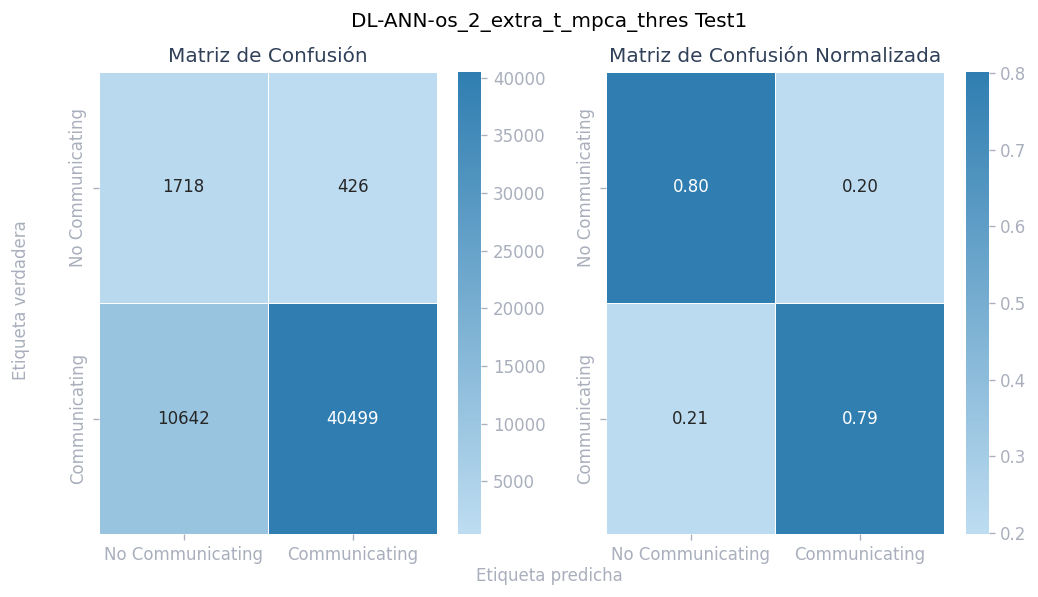

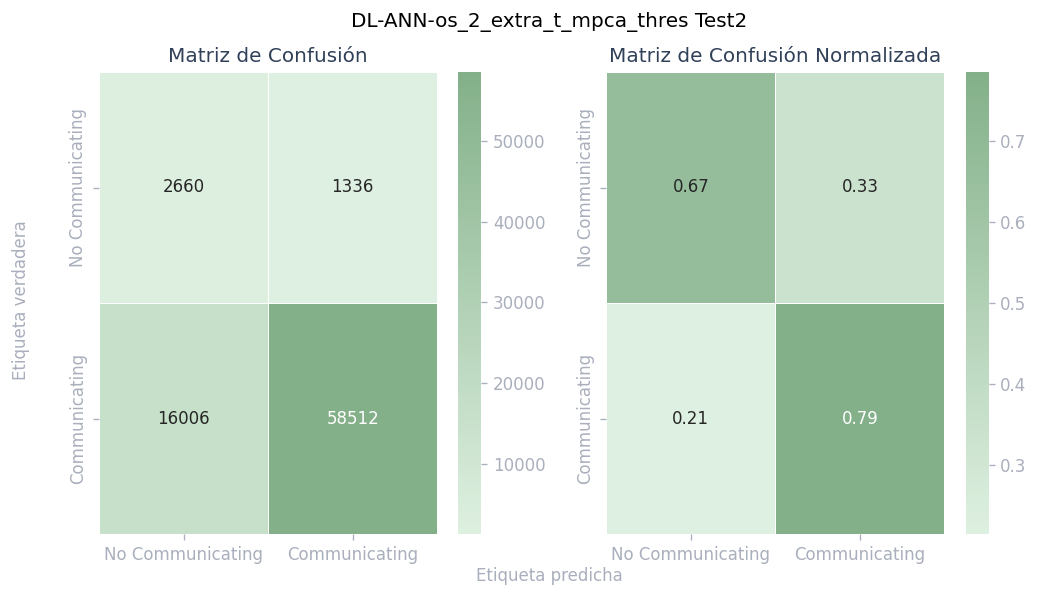

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL'
temp_id = get_run_id(temp_exp_name, "ann_tunning_os_2_extra_t")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL-ANN-os_2_extra_t",temp_thresholds)

## Experimento DL2

2454/2454 [==============================] - 2s 996us/step
Metrics for DL2-ANN-us Test 1_f1_thres
Thres Value: 0.48999999999999977
Accuracy: 0.8538237777986301
F1 Score Micro: 0.8538237777986302
F1 Score Macro: 0.6156440806705343
F1 Score Weighted: 0.8938610887329314
Precission: 0.9916307552733046
Recall: 0.854910932519896
Metrics for DL2-ANN-us Test 2_f1_thres
Thres Value: 0.48999999999999977
Accuracy: 0.8284764500598619
F1 Score Micro: 0.8284764500598619
F1 Score Macro: 0.5796572498699967
F1 Score Weighted: 0.8701405984188351
Precission: 0.9739763675605174
Recall: 0.8417697737459405


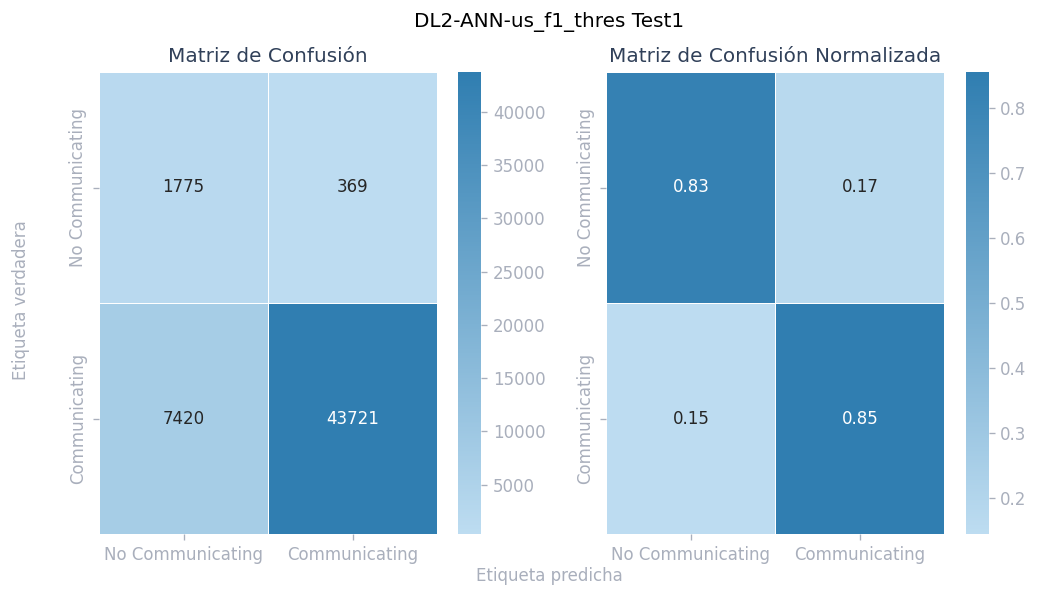

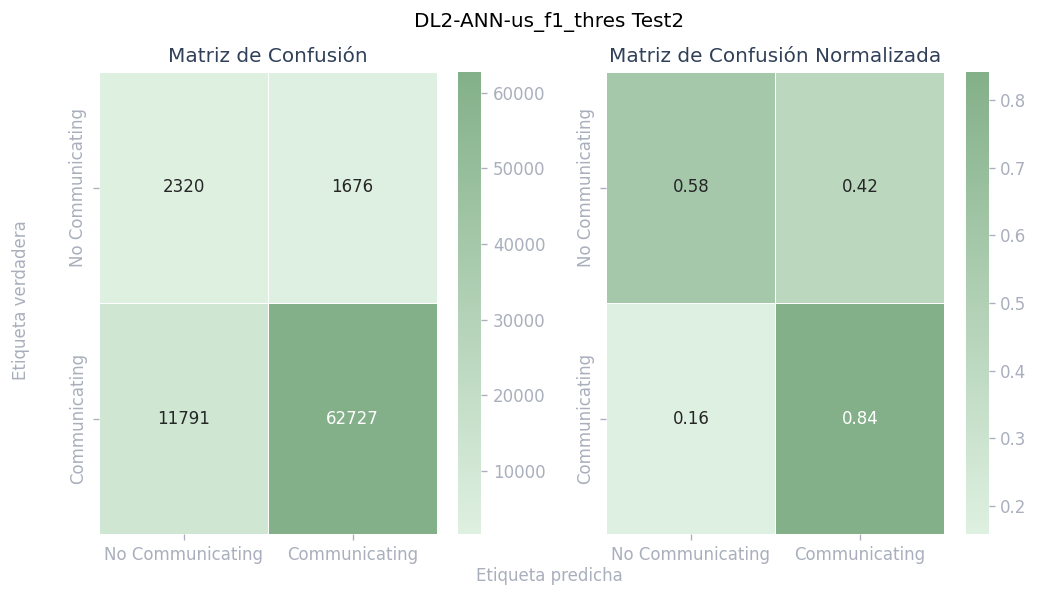

Metrics for DL2-ANN-us Test 1_acc_thres
Thres Value: 0.48999999999999977
Accuracy: 0.8538237777986301
F1 Score Micro: 0.8538237777986302
F1 Score Macro: 0.6156440806705343
F1 Score Weighted: 0.8938610887329314
Precission: 0.9916307552733046
Recall: 0.854910932519896
Metrics for DL2-ANN-us Test 2_acc_thres
Thres Value: 0.48999999999999977
Accuracy: 0.8284764500598619
F1 Score Micro: 0.8284764500598619
F1 Score Macro: 0.5796572498699967
F1 Score Weighted: 0.8701405984188351
Precission: 0.9739763675605174
Recall: 0.8417697737459405


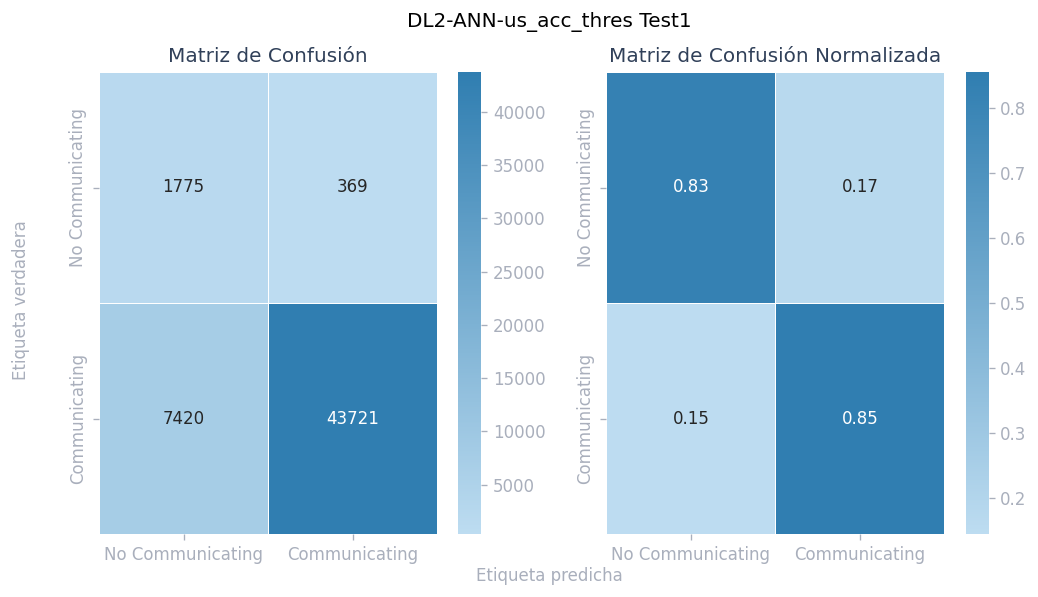

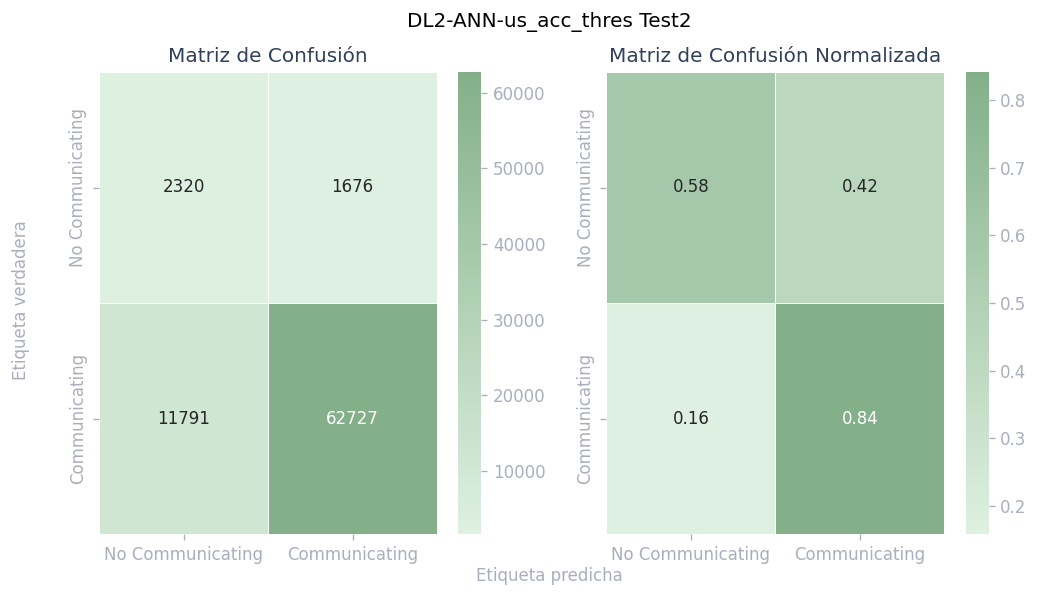

Metrics for DL2-ANN-us Test 1_mpca_thres
Thres Value: 0.5399999999999998
Accuracy: 0.8293703668949985
F1 Score Micro: 0.8293703668949985
F1 Score Macro: 0.5952707550344373
F1 Score Weighted: 0.8783103277014803
Precission: 0.9927347723171389
Recall: 0.8282786805107448
Metrics for DL2-ANN-us Test 2_mpca_thres
Thres Value: 0.5399999999999998
Accuracy: 0.8040604223450595
F1 Score Micro: 0.8040604223450595
F1 Score Macro: 0.5631019646607217
F1 Score Weighted: 0.8545349130179775
Precission: 0.9745602208525938
Recall: 0.8148232641777825


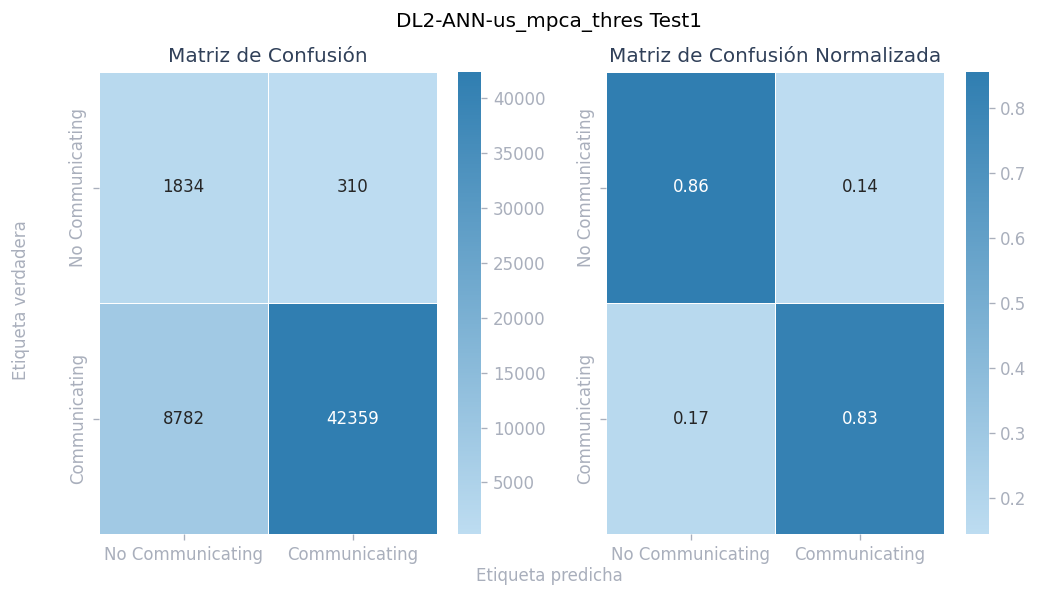

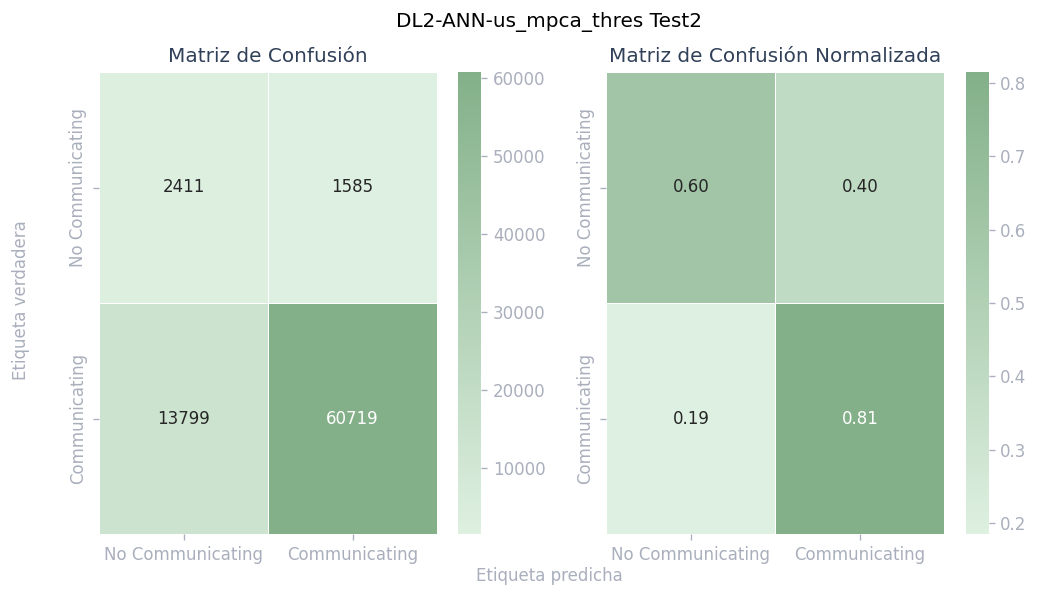

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL2'
temp_id = get_run_id(temp_exp_name, "ann_training_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL2-ANN-us",temp_thresholds)

2454/2454 [==============================] - 2s 912us/step
Metrics for DL2-ANN-os_1 Test 1_f1_thres
Thres Value: 0.6199999999999998
Accuracy: 0.9372618935910669
F1 Score Micro: 0.9372618935910669
F1 Score Macro: 0.7532811527858563
F1 Score Weighted: 0.9491890146807775
Precission: 0.9962623032517962
Recall: 0.9381513853855028
Metrics for DL2-ANN-os_1 Test 2_f1_thres
Thres Value: 0.6199999999999998
Accuracy: 0.8978526122729704
F1 Score Micro: 0.8978526122729704
F1 Score Macro: 0.6117764080509438
F1 Score Weighted: 0.9111126802570294
Precission: 0.9657114043196907
Recall: 0.9252261198636571


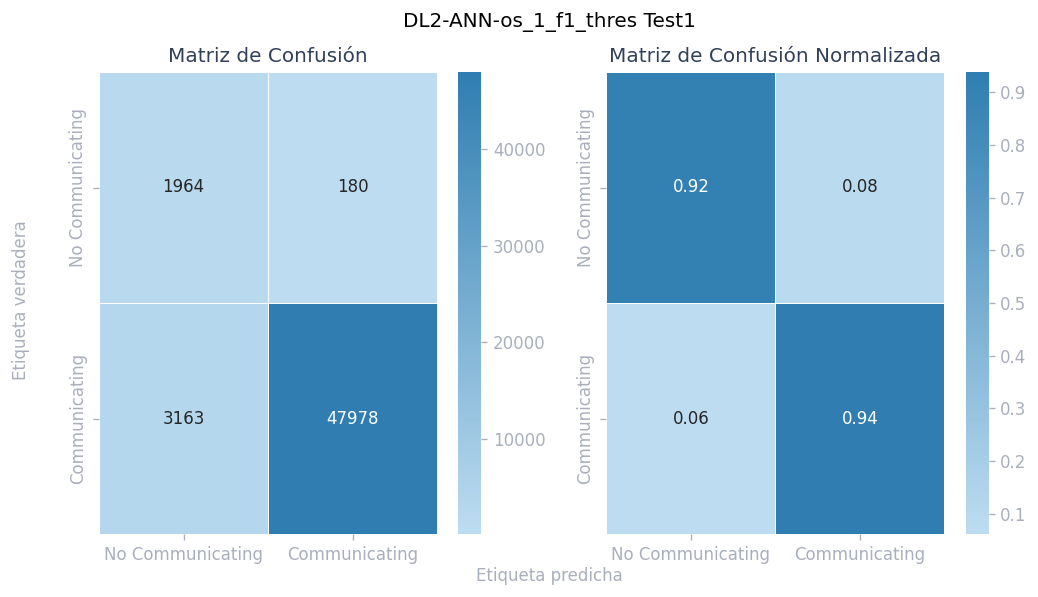

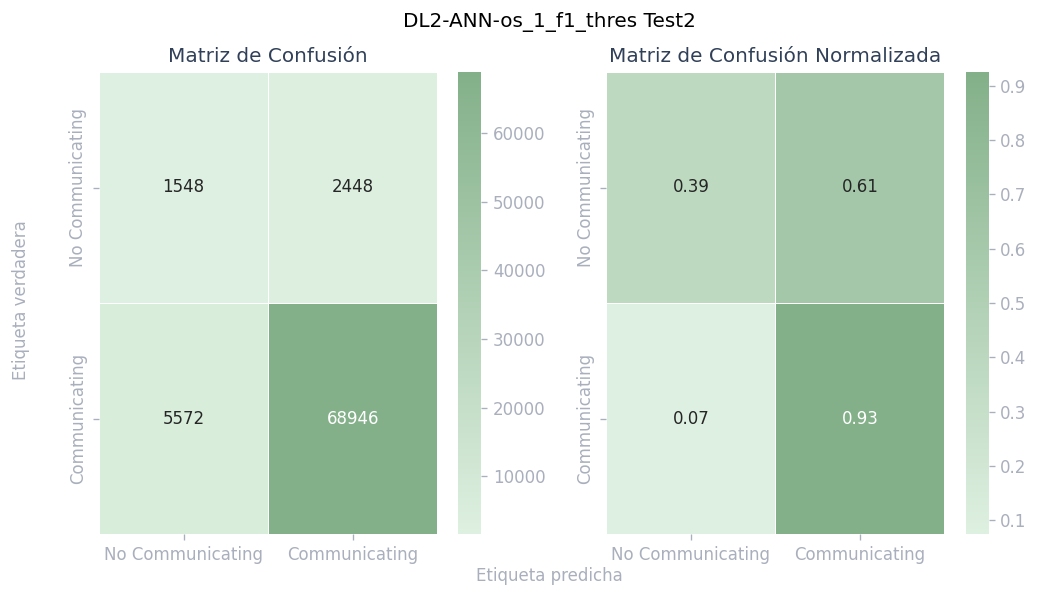

Metrics for DL2-ANN-os_1 Test 1_acc_thres
Thres Value: 0.6199999999999998
Accuracy: 0.9372618935910669
F1 Score Micro: 0.9372618935910669
F1 Score Macro: 0.7532811527858563
F1 Score Weighted: 0.9491890146807775
Precission: 0.9962623032517962
Recall: 0.9381513853855028
Metrics for DL2-ANN-os_1 Test 2_acc_thres
Thres Value: 0.6199999999999998
Accuracy: 0.8978526122729704
F1 Score Micro: 0.8978526122729704
F1 Score Macro: 0.6117764080509438
F1 Score Weighted: 0.9111126802570294
Precission: 0.9657114043196907
Recall: 0.9252261198636571


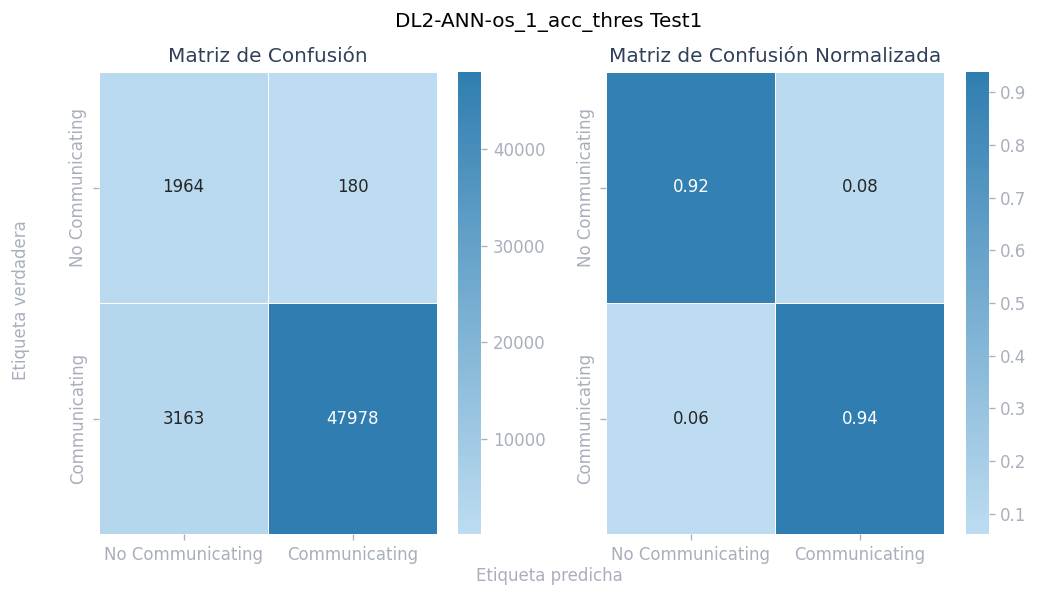

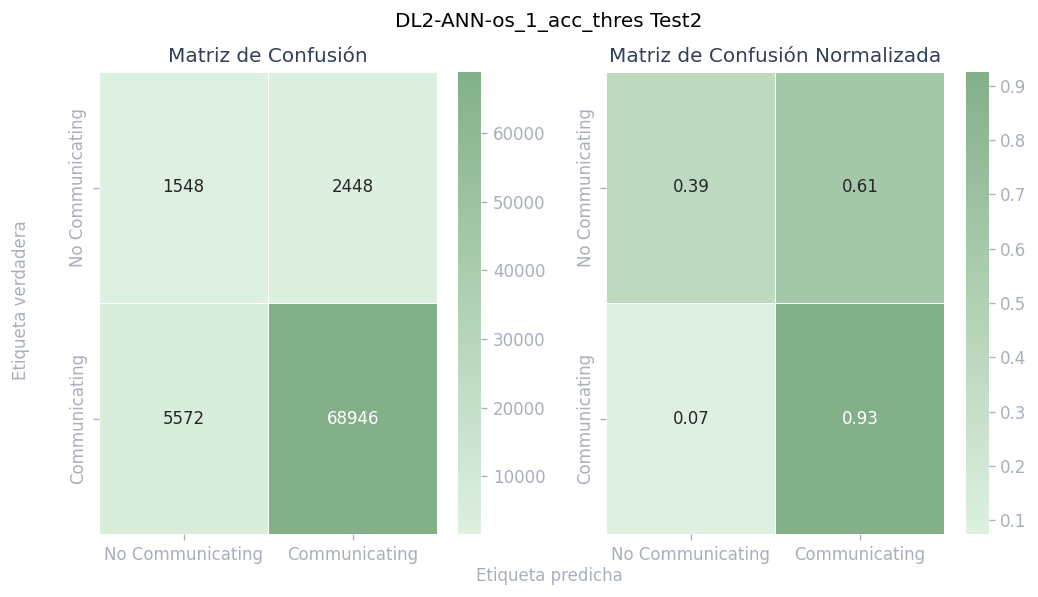

Metrics for DL2-ANN-os_1 Test 1_mpca_thres
Thres Value: 0.6199999999999998
Accuracy: 0.9372618935910669
F1 Score Micro: 0.9372618935910669
F1 Score Macro: 0.7532811527858563
F1 Score Weighted: 0.9491890146807775
Precission: 0.9962623032517962
Recall: 0.9381513853855028
Metrics for DL2-ANN-os_1 Test 2_mpca_thres
Thres Value: 0.6199999999999998
Accuracy: 0.8978526122729704
F1 Score Micro: 0.8978526122729704
F1 Score Macro: 0.6117764080509438
F1 Score Weighted: 0.9111126802570294
Precission: 0.9657114043196907
Recall: 0.9252261198636571


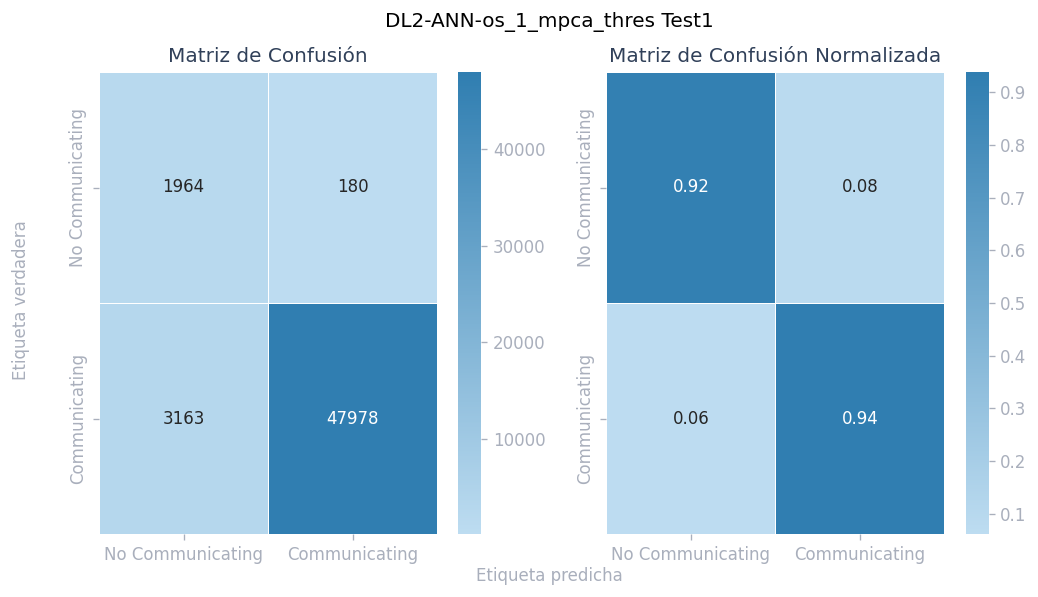

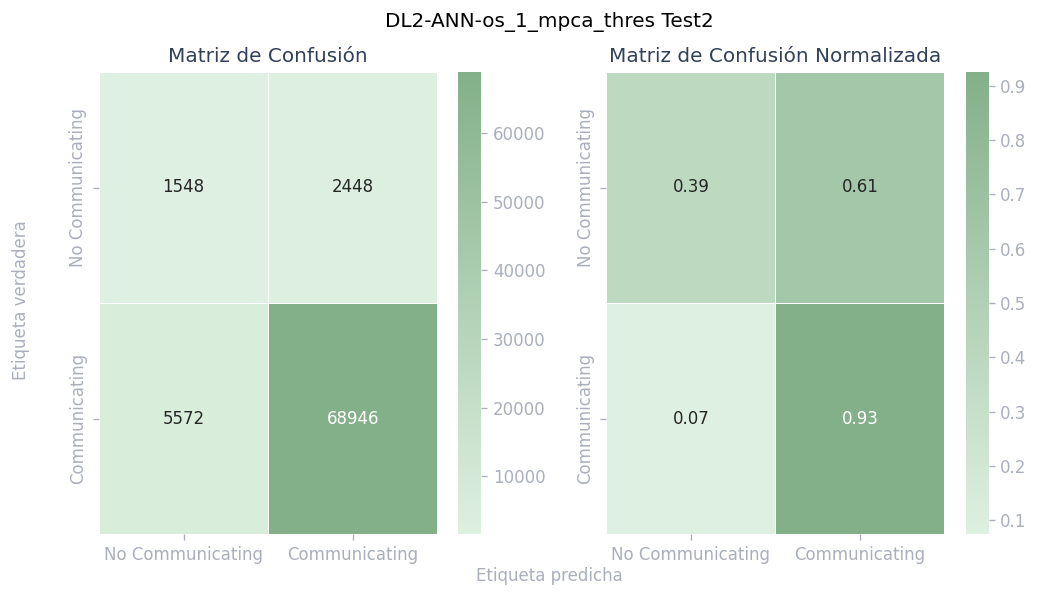

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL2'
temp_id = get_run_id(temp_exp_name, "ann_training_os_1")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL2-ANN-os_1",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL2-ANN-os_2 Test 1_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9589377873698038
F1 Score Micro: 0.9589377873698038
F1 Score Macro: 0.8102926195629101
F1 Score Weighted: 0.9647049690240667
Precission: 0.9963699783009876
Recall: 0.9607164505973681
Metrics for DL2-ANN-os_2 Test 2_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9108184527600173
F1 Score Micro: 0.9108184527600173
F1 Score Macro: 0.601694899167575
F1 Score Weighted: 0.9168697089993789
Precission: 0.9614017822973047
Recall: 0.943933009474221


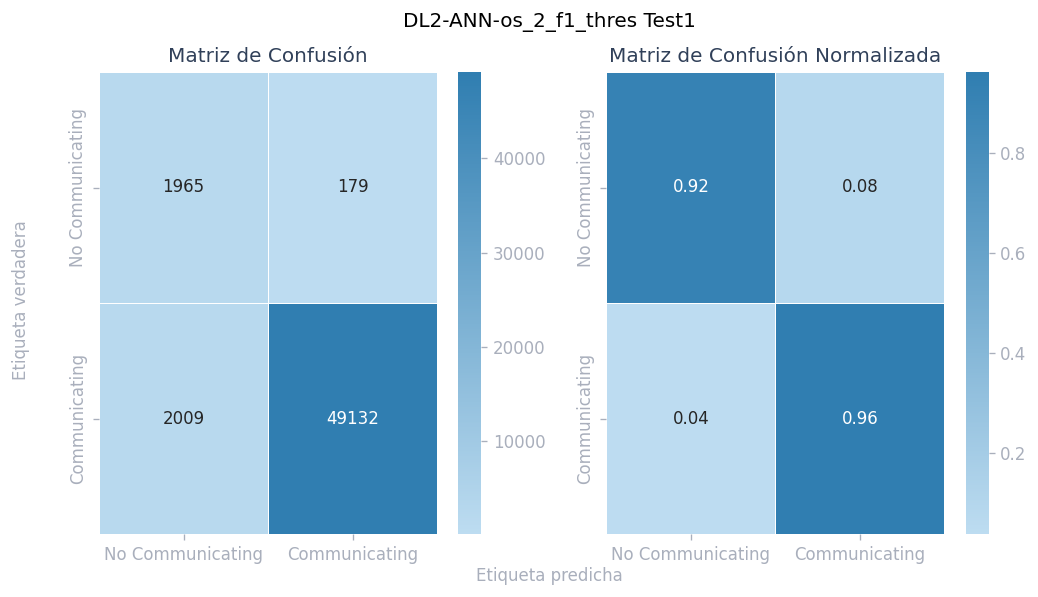

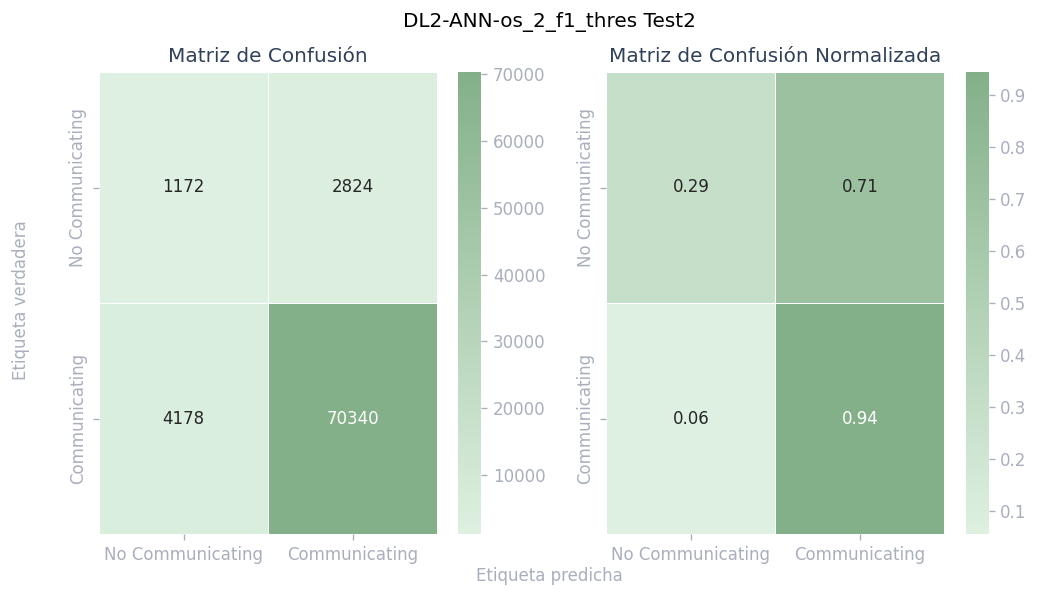

Metrics for DL2-ANN-os_2 Test 1_acc_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9589377873698038
F1 Score Micro: 0.9589377873698038
F1 Score Macro: 0.8102926195629101
F1 Score Weighted: 0.9647049690240667
Precission: 0.9963699783009876
Recall: 0.9607164505973681
Metrics for DL2-ANN-os_2 Test 2_acc_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9108184527600173
F1 Score Micro: 0.9108184527600173
F1 Score Macro: 0.601694899167575
F1 Score Weighted: 0.9168697089993789
Precission: 0.9614017822973047
Recall: 0.943933009474221


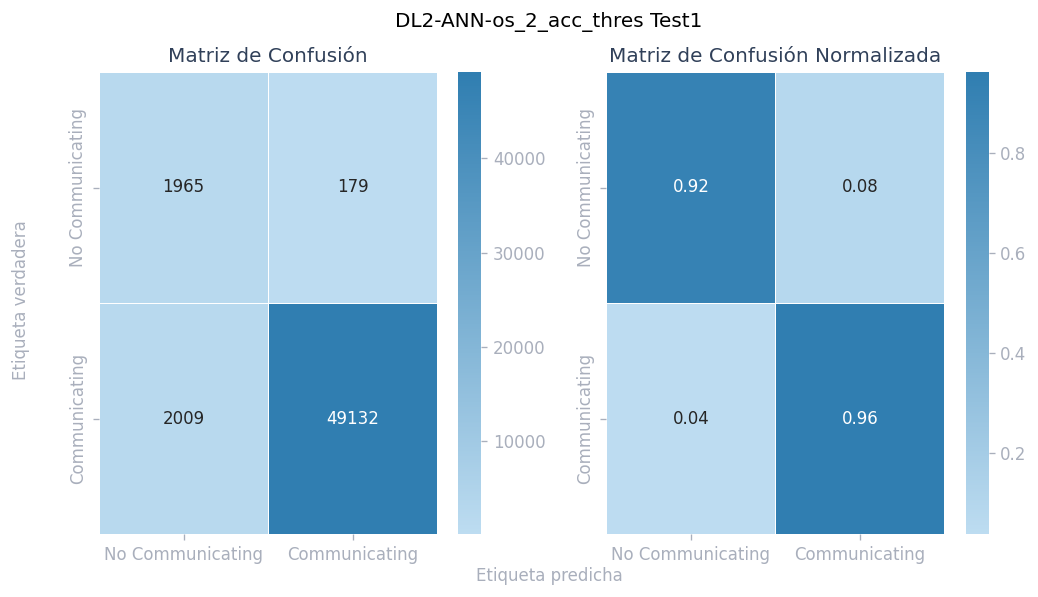

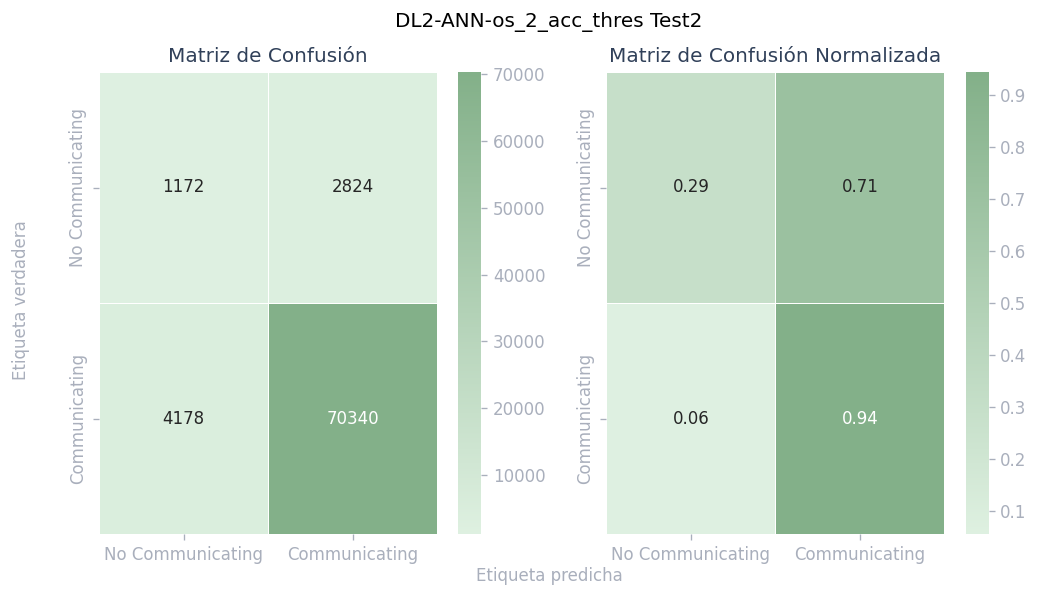

Metrics for DL2-ANN-os_2 Test 1_mpca_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9589377873698038
F1 Score Micro: 0.9589377873698038
F1 Score Macro: 0.8102926195629101
F1 Score Weighted: 0.9647049690240667
Precission: 0.9963699783009876
Recall: 0.9607164505973681
Metrics for DL2-ANN-os_2 Test 2_mpca_thres
Thres Value: 0.47999999999999976
Accuracy: 0.9108184527600173
F1 Score Micro: 0.9108184527600173
F1 Score Macro: 0.601694899167575
F1 Score Weighted: 0.9168697089993789
Precission: 0.9614017822973047
Recall: 0.943933009474221


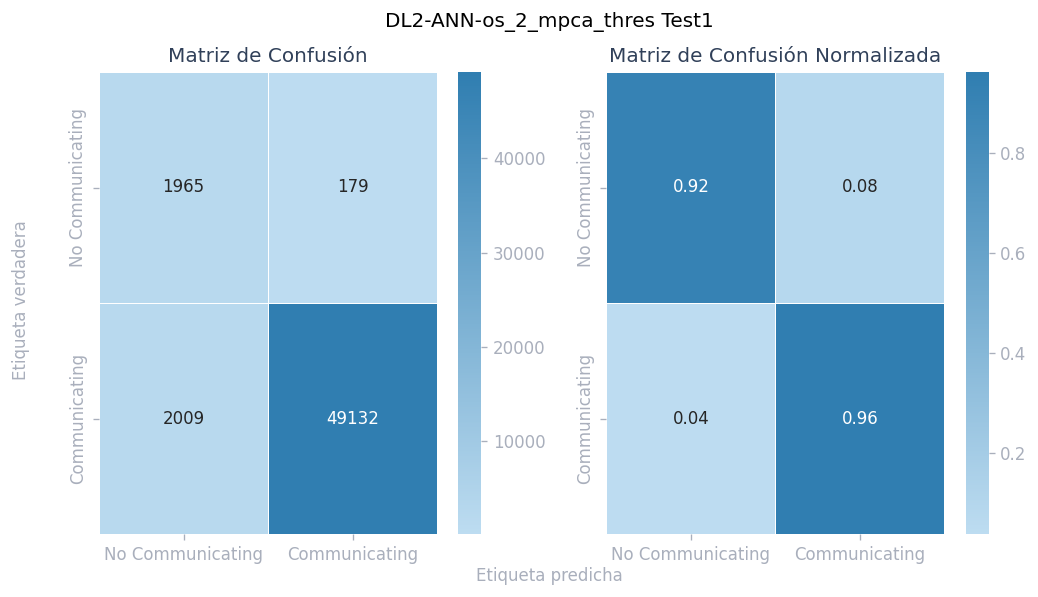

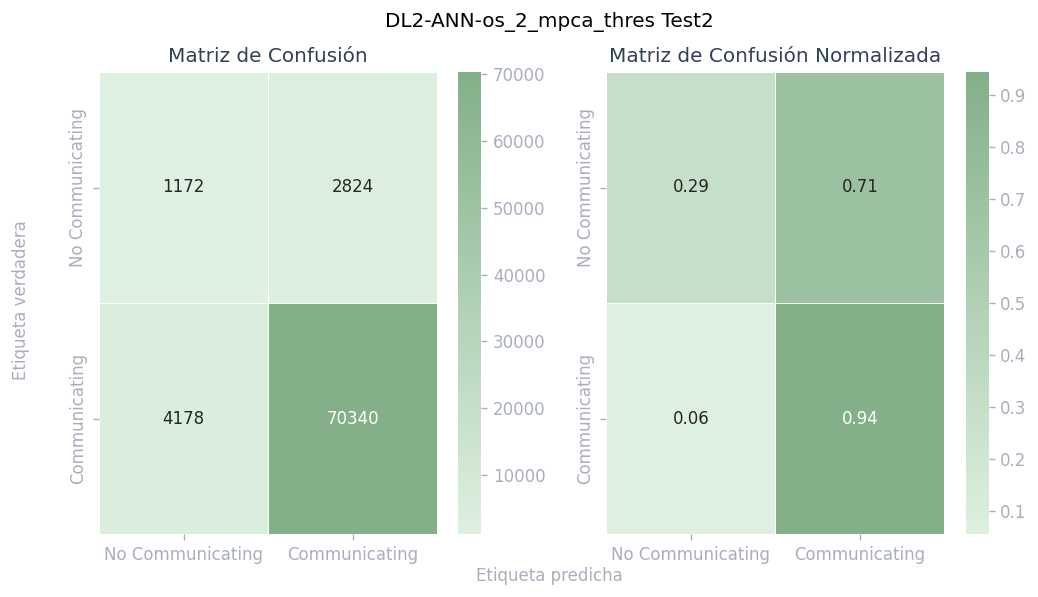

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL2'
temp_id = get_run_id(temp_exp_name, "ann_training_os_2")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL2-ANN-os_2",temp_thresholds)

## Experimento DL3

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL3-ANN-us Test 1_f1_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7212911701229239
F1 Score Micro: 0.7212911701229239
F1 Score Macro: 0.478287983847978
F1 Score Weighted: 0.8056934482354147
Precission: 0.9711763178395222
Recall: 0.7313114722042979
Metrics for DL3-ANN-us Test 2_f1_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7182668059199633
F1 Score Micro: 0.7182668059199633
F1 Score Macro: 0.4773816402790984
F1 Score Weighted: 0.7960763658405023
Precission: 0.9572251308900523
Recall: 0.7360503502509461


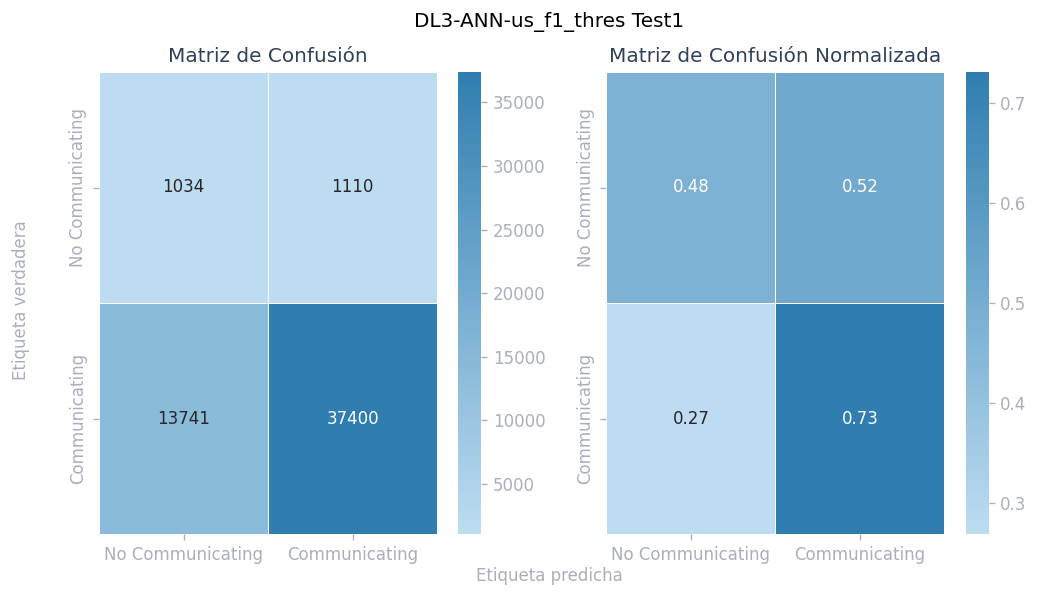

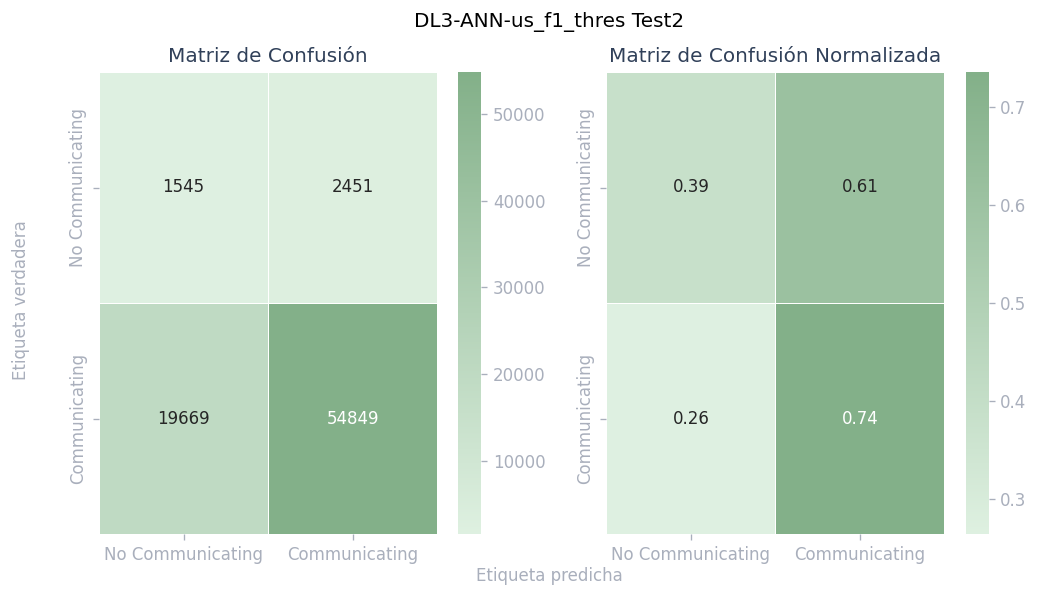

Metrics for DL3-ANN-us Test 1_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.27518063244815616
F1 Score Micro: 0.27518063244815616
F1 Score Macro: 0.24355631730203248
F1 Score Weighted: 0.3857772047930486
Precission: 0.9800598205383848
Recall: 0.24987778885825462
Metrics for DL3-ANN-us Test 2_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.2995644088952289
F1 Score Micro: 0.2995644088952289
F1 Score Macro: 0.2624880053494417
F1 Score Weighted: 0.4110168698606893
Precission: 0.9519444444444445
Recall: 0.27593333154405647


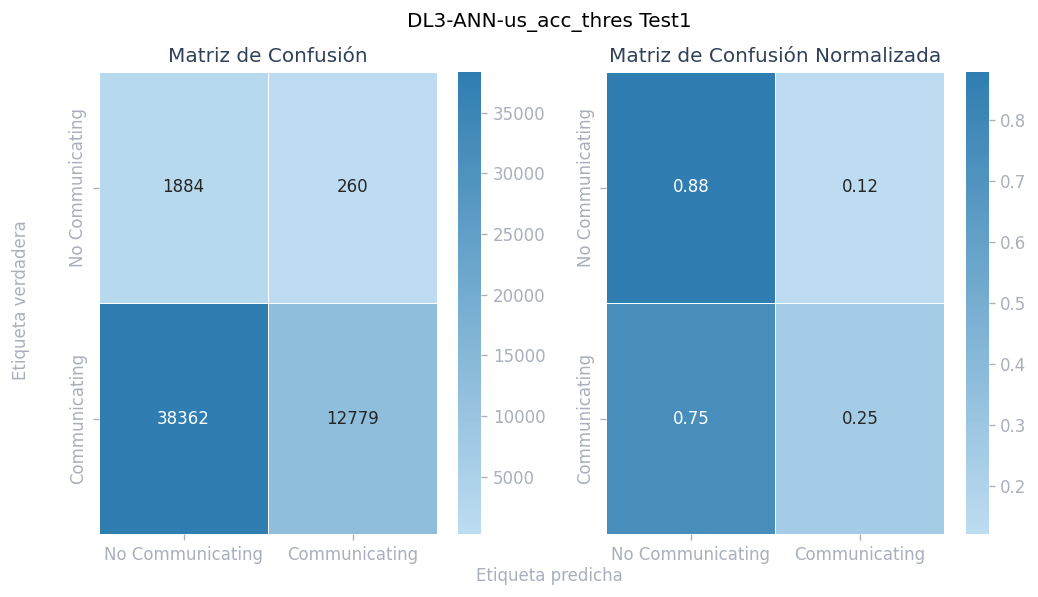

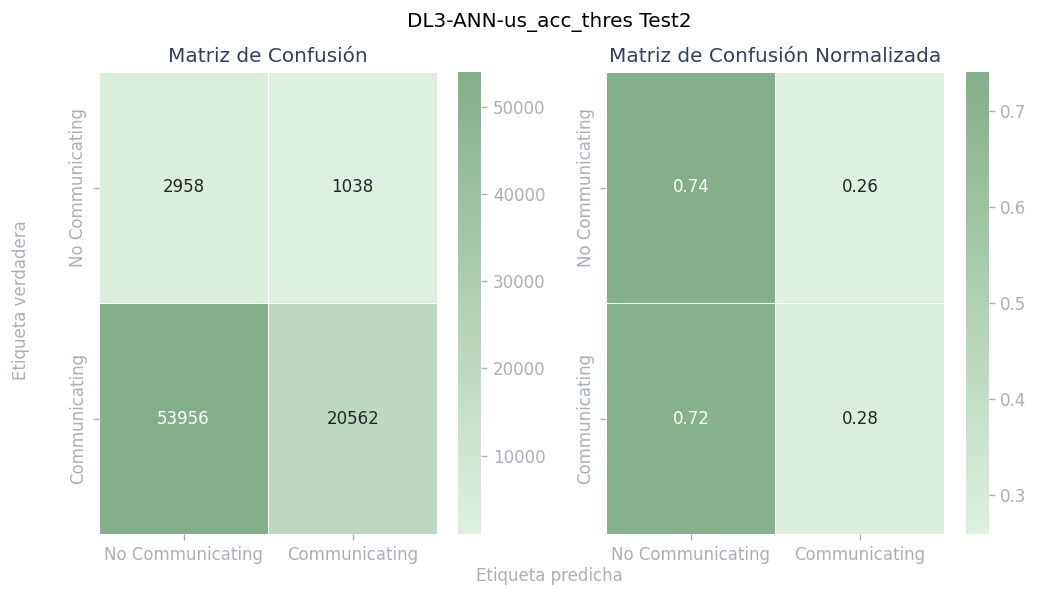

Metrics for DL3-ANN-us Test 1_mpca_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7212911701229239
F1 Score Micro: 0.7212911701229239
F1 Score Macro: 0.478287983847978
F1 Score Weighted: 0.8056934482354147
Precission: 0.9711763178395222
Recall: 0.7313114722042979
Metrics for DL3-ANN-us Test 2_mpca_thres
Thres Value: 0.4999999999999998
Accuracy: 0.7182668059199633
F1 Score Micro: 0.7182668059199633
F1 Score Macro: 0.4773816402790984
F1 Score Weighted: 0.7960763658405023
Precission: 0.9572251308900523
Recall: 0.7360503502509461


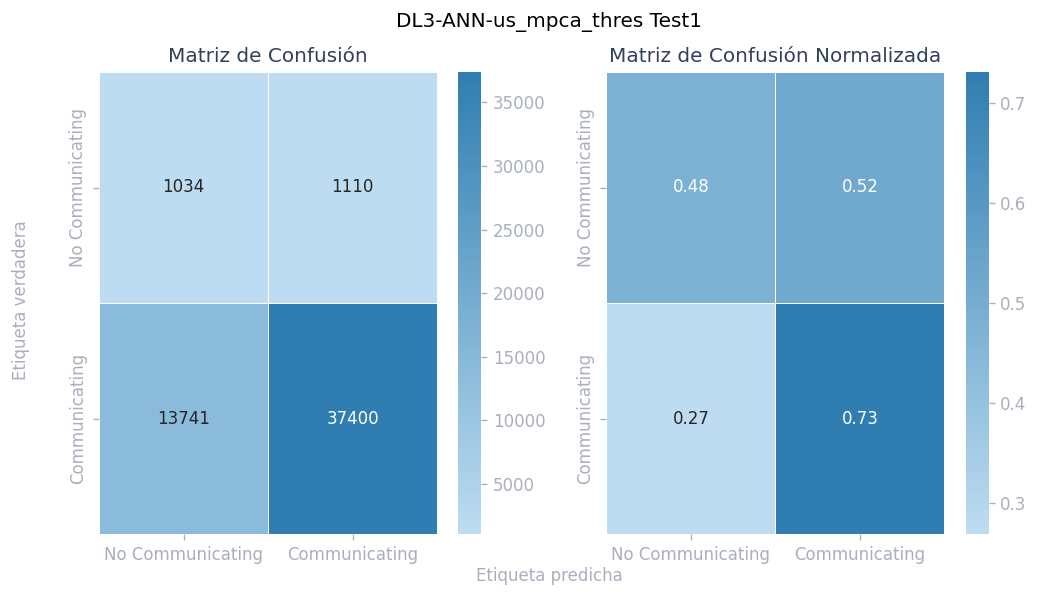

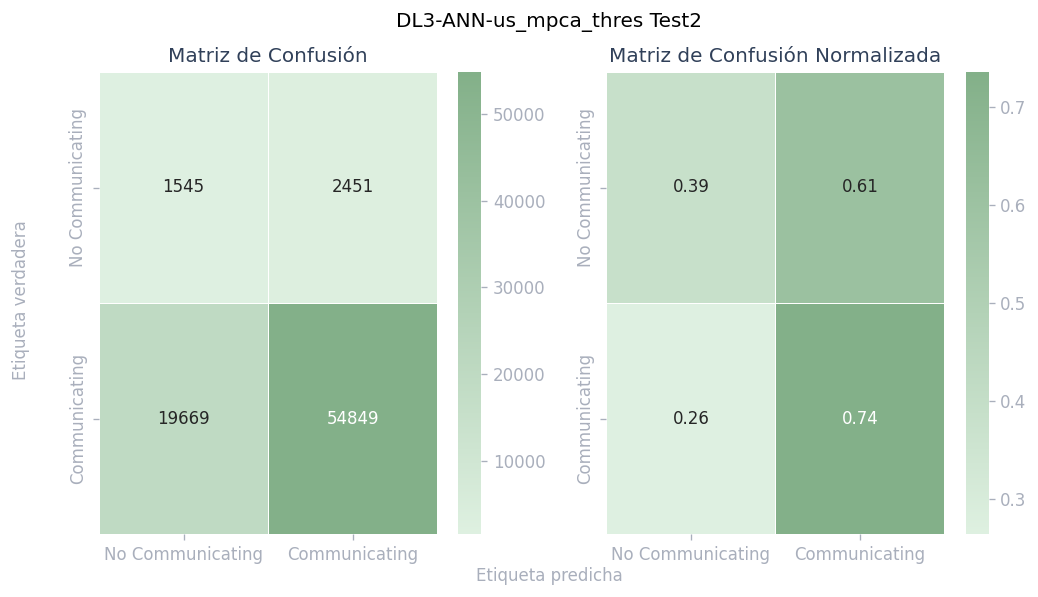

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL3'
temp_id = get_run_id(temp_exp_name, "ann_training_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL3-ANN-us",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL3-ANN-os_1 Test 1_f1_thres
Thres Value: 0.5199999999999998
Accuracy: 0.76323543211035
F1 Score Micro: 0.76323543211035
F1 Score Macro: 0.5397420678473672
F1 Score Weighted: 0.8346574853904812
Precission: 0.9904519414385742
Recall: 0.7606421462231868
Metrics for DL3-ANN-os_1 Test 2_f1_thres
Thres Value: 0.5199999999999998
Accuracy: 0.7566676006826808
F1 Score Micro: 0.7566676006826809
F1 Score Macro: 0.5383454217904518
F1 Score Weighted: 0.8235030662969206
Precission: 0.9777888909965683
Recall: 0.7609034058885101


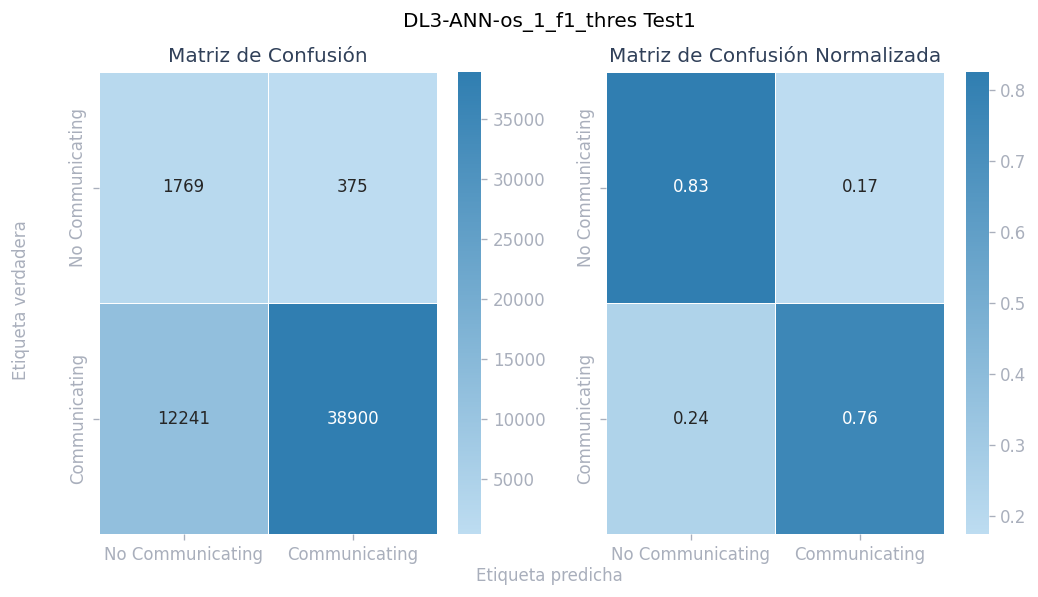

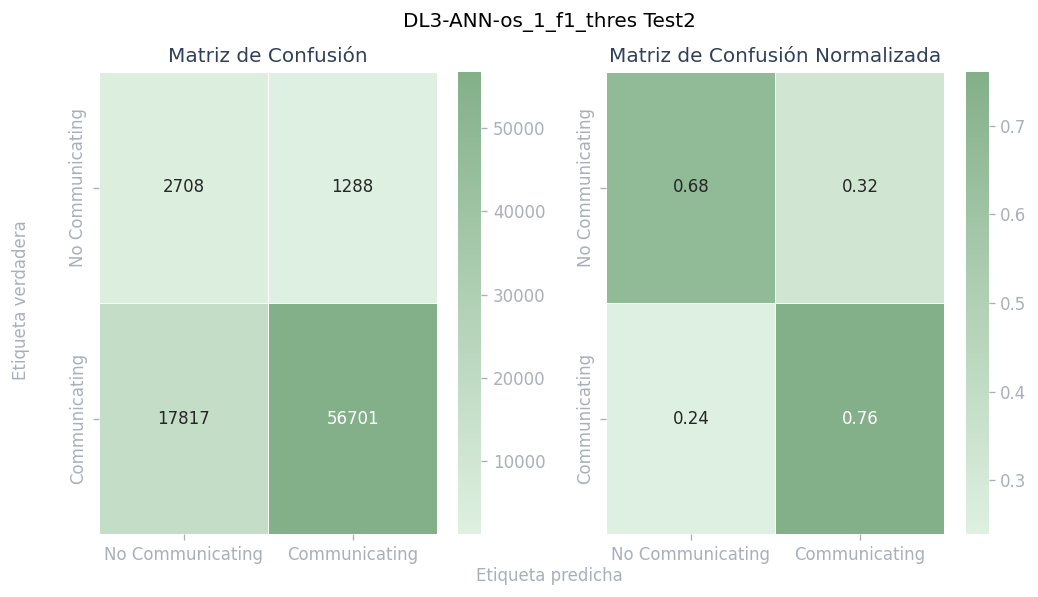

Metrics for DL3-ANN-os_1 Test 1_acc_thres
Thres Value: 0.5199999999999998
Accuracy: 0.76323543211035
F1 Score Micro: 0.76323543211035
F1 Score Macro: 0.5397420678473672
F1 Score Weighted: 0.8346574853904812
Precission: 0.9904519414385742
Recall: 0.7606421462231868
Metrics for DL3-ANN-os_1 Test 2_acc_thres
Thres Value: 0.5199999999999998
Accuracy: 0.7566676006826808
F1 Score Micro: 0.7566676006826809
F1 Score Macro: 0.5383454217904518
F1 Score Weighted: 0.8235030662969206
Precission: 0.9777888909965683
Recall: 0.7609034058885101


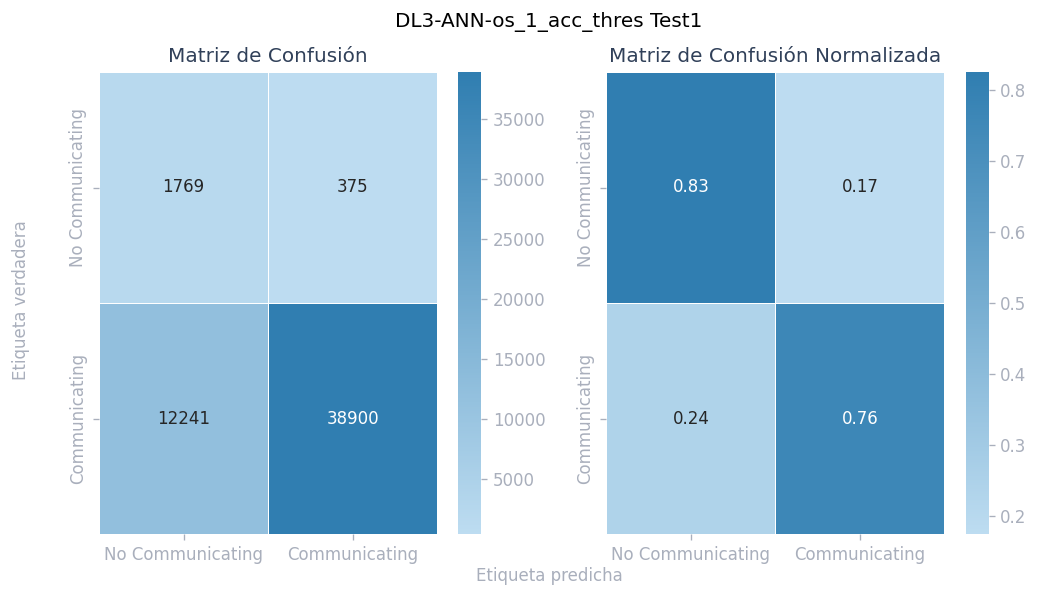

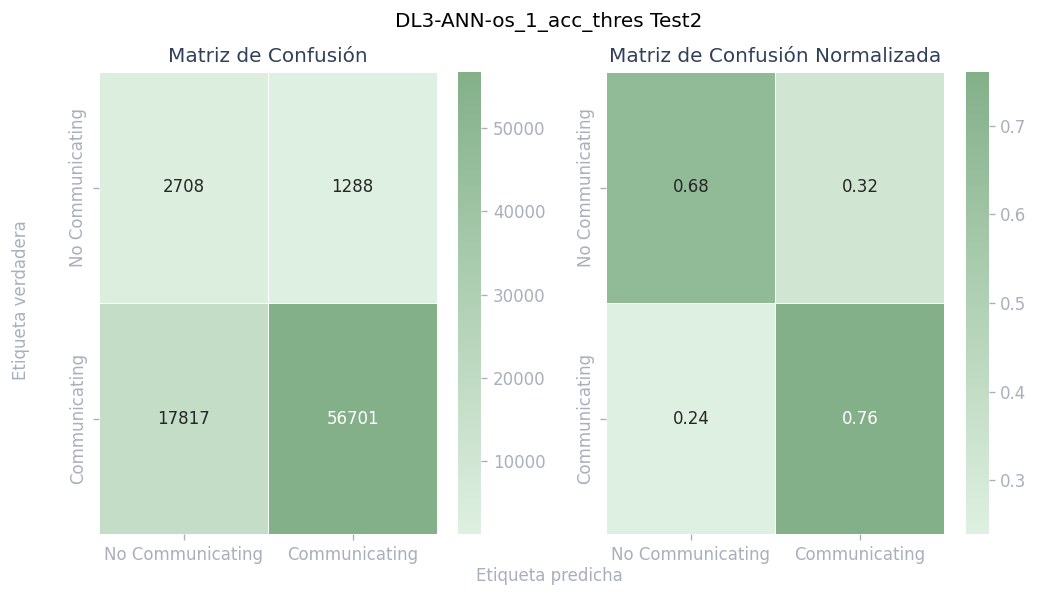

Metrics for DL3-ANN-os_1 Test 1_mpca_thres
Thres Value: 0.5199999999999998
Accuracy: 0.76323543211035
F1 Score Micro: 0.76323543211035
F1 Score Macro: 0.5397420678473672
F1 Score Weighted: 0.8346574853904812
Precission: 0.9904519414385742
Recall: 0.7606421462231868
Metrics for DL3-ANN-os_1 Test 2_mpca_thres
Thres Value: 0.5199999999999998
Accuracy: 0.7566676006826808
F1 Score Micro: 0.7566676006826809
F1 Score Macro: 0.5383454217904518
F1 Score Weighted: 0.8235030662969206
Precission: 0.9777888909965683
Recall: 0.7609034058885101


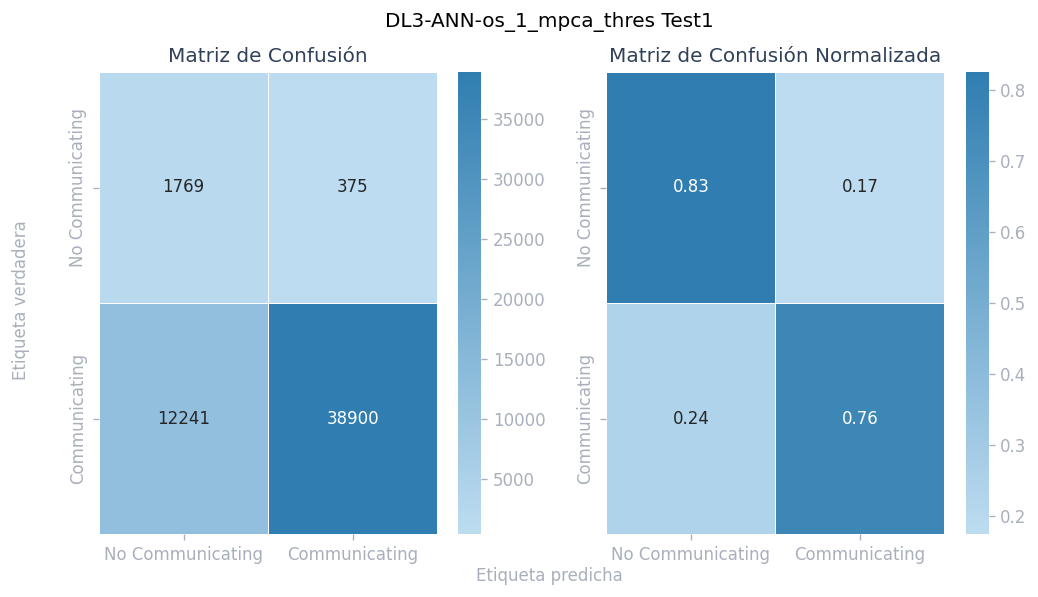

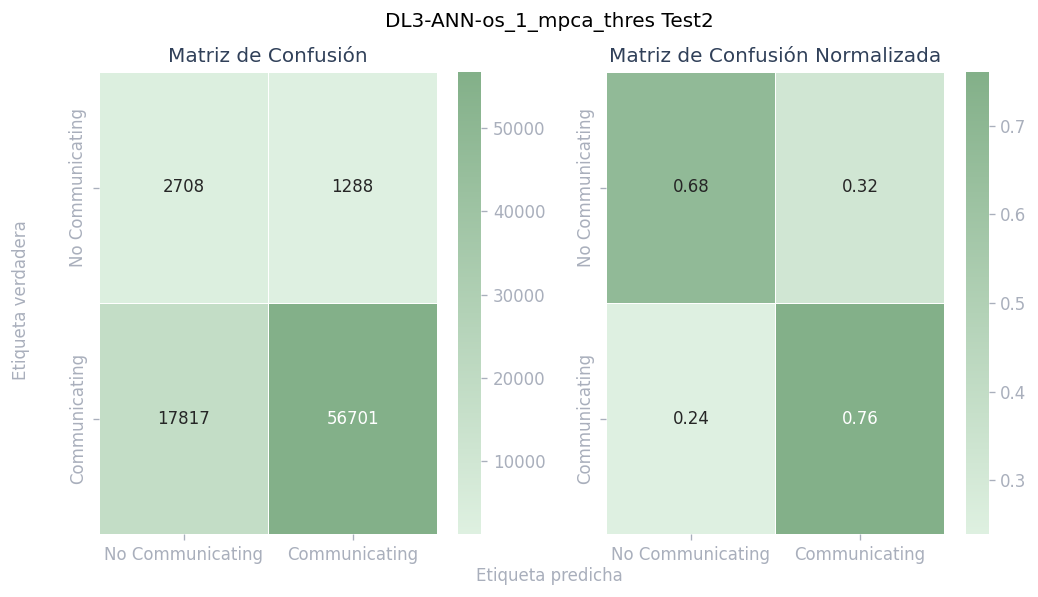

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL3'
temp_id = get_run_id(temp_exp_name, "ann_training_os_1")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL3-ANN-os_1",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL3-ANN-os_2 Test 1_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7193769353476588
F1 Score Micro: 0.7193769353476588
F1 Score Macro: 0.5133166174024189
F1 Score Weighted: 0.8045123199394206
Precission: 0.991471099521947
Recall: 0.713752175358323
Metrics for DL3-ANN-os_2 Test 2_f1_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7045877168403087
F1 Score Micro: 0.7045877168403087
F1 Score Macro: 0.5044263355793626
F1 Score Weighted: 0.7873190553133086
Precission: 0.9761569005826252
Recall: 0.7059904989398534


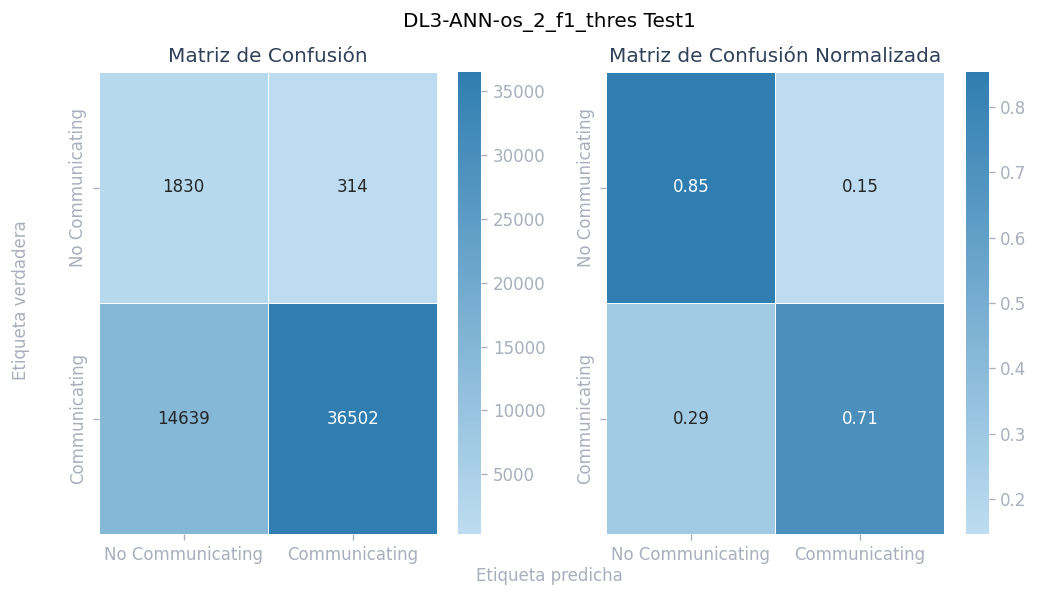

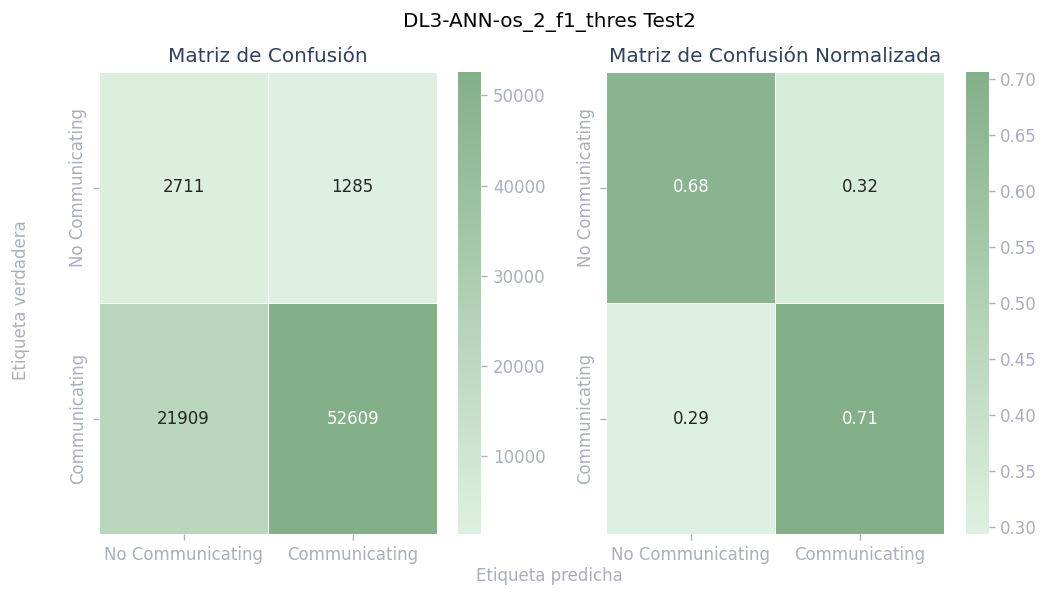

Metrics for DL3-ANN-os_2 Test 1_acc_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7193769353476588
F1 Score Micro: 0.7193769353476588
F1 Score Macro: 0.5133166174024189
F1 Score Weighted: 0.8045123199394206
Precission: 0.991471099521947
Recall: 0.713752175358323
Metrics for DL3-ANN-os_2 Test 2_acc_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7045877168403087
F1 Score Micro: 0.7045877168403087
F1 Score Macro: 0.5044263355793626
F1 Score Weighted: 0.7873190553133086
Precission: 0.9761569005826252
Recall: 0.7059904989398534


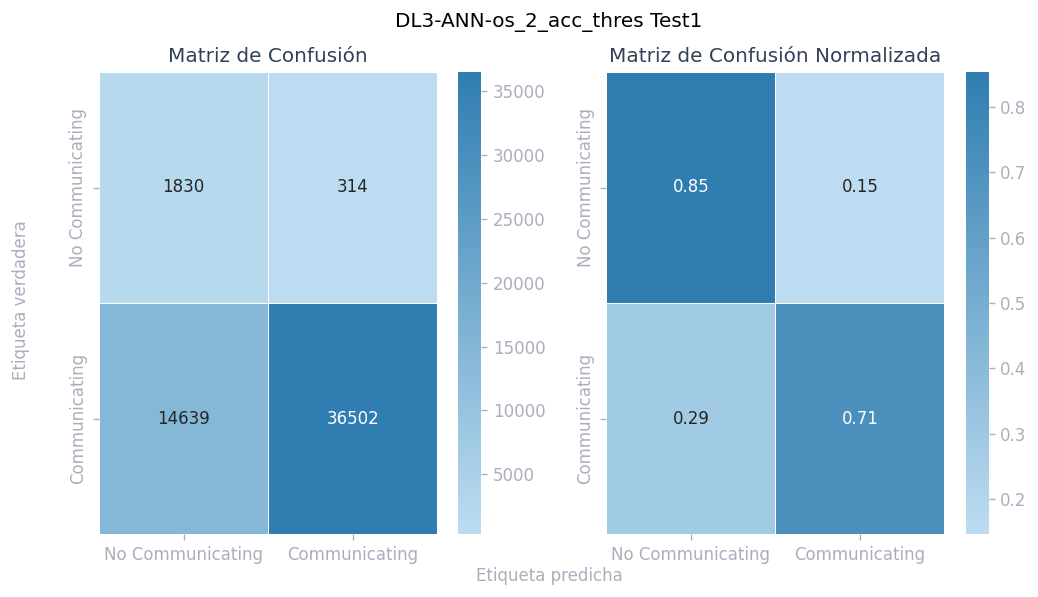

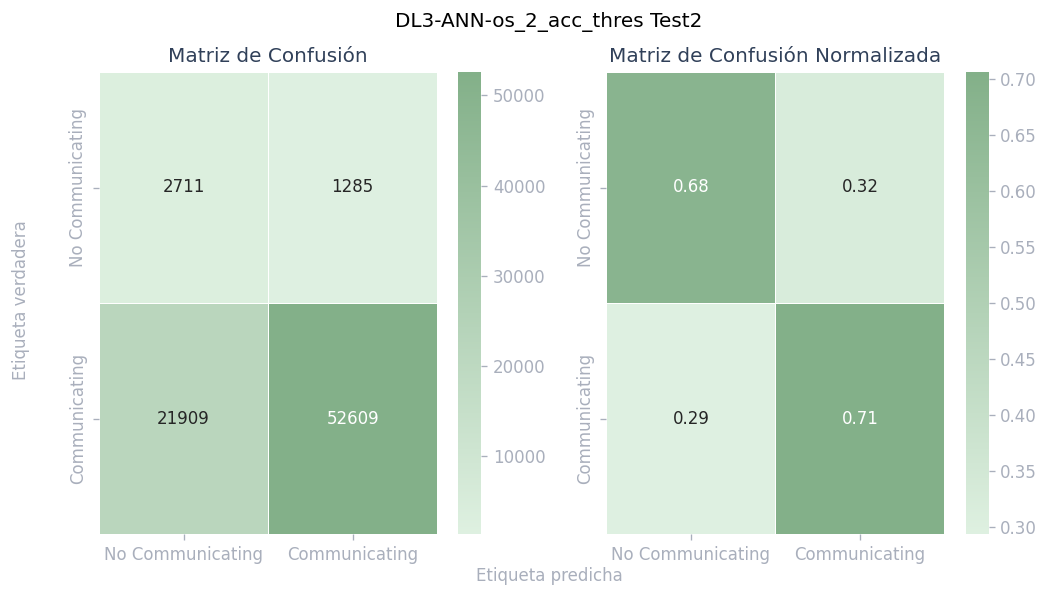

Metrics for DL3-ANN-os_2 Test 1_mpca_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7193769353476588
F1 Score Micro: 0.7193769353476588
F1 Score Macro: 0.5133166174024189
F1 Score Weighted: 0.8045123199394206
Precission: 0.991471099521947
Recall: 0.713752175358323
Metrics for DL3-ANN-os_2 Test 2_mpca_thres
Thres Value: 0.47999999999999976
Accuracy: 0.7045877168403087
F1 Score Micro: 0.7045877168403087
F1 Score Macro: 0.5044263355793626
F1 Score Weighted: 0.7873190553133086
Precission: 0.9761569005826252
Recall: 0.7059904989398534


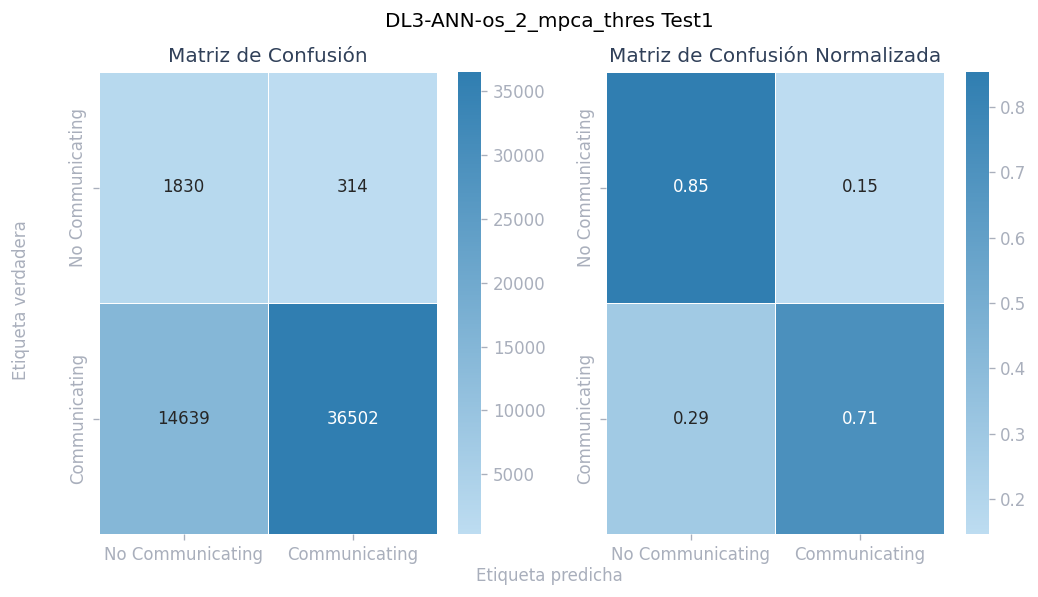

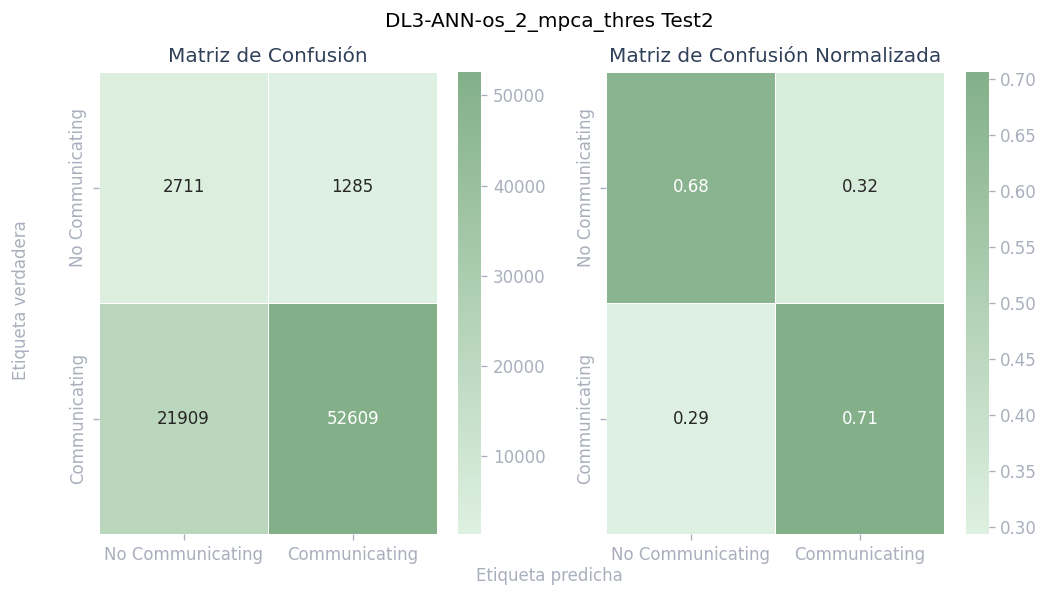

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL3'
temp_id = get_run_id(temp_exp_name, "ann_training_os_2")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL3-ANN-os_2",temp_thresholds)

## Experimento DL4

2454/2454 [==============================] - 2s 925us/step
Metrics for DL4-ANN-us Test 1_f1_thres
Thres Value: 0.4099999999999998
Accuracy: 0.8718964061180445
F1 Score Micro: 0.8718964061180445
F1 Score Macro: 0.6411298720938551
F1 Score Weighted: 0.905747997198192
Precission: 0.9937824526998418
Recall: 0.8719813847988893
Metrics for DL4-ANN-us Test 2_f1_thres
Thres Value: 0.4099999999999998
Accuracy: 0.8463586112030975
F1 Score Micro: 0.8463586112030975
F1 Score Macro: 0.5914249954639955
F1 Score Weighted: 0.8813108118936859
Precission: 0.9730364311141407
Recall: 0.8620064950750155


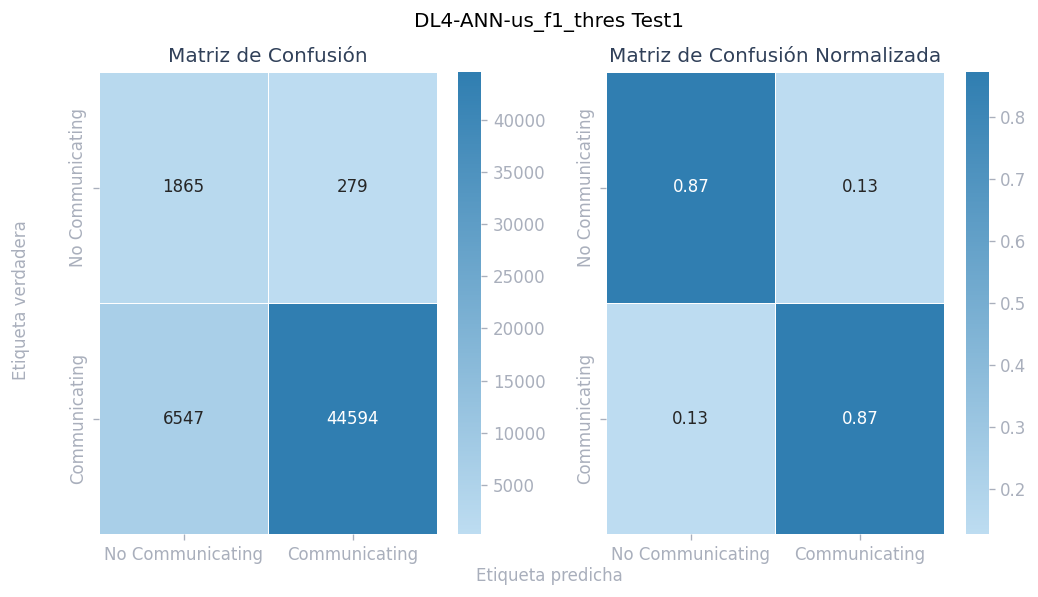

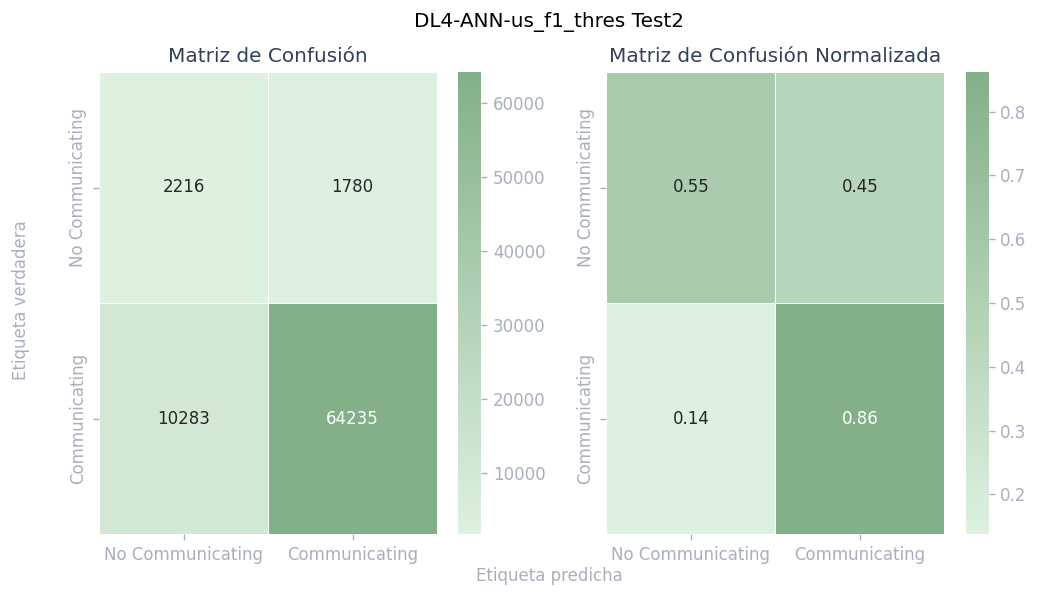

Metrics for DL4-ANN-us Test 1_acc_thres
Thres Value: 0.3999999999999998
Accuracy: 0.8756122736229708
F1 Score Micro: 0.8756122736229708
F1 Score Macro: 0.6451812799427823
F1 Score Weighted: 0.9081101217803781
Precission: 0.9936564267494732
Recall: 0.8759899102481375
Metrics for DL4-ANN-us Test 2_acc_thres
Thres Value: 0.3999999999999998
Accuracy: 0.8497210688539624
F1 Score Micro: 0.8497210688539624
F1 Score Macro: 0.593653205573749
F1 Score Weighted: 0.8833898823630569
Precission: 0.972829938332102
Recall: 0.865844493947771


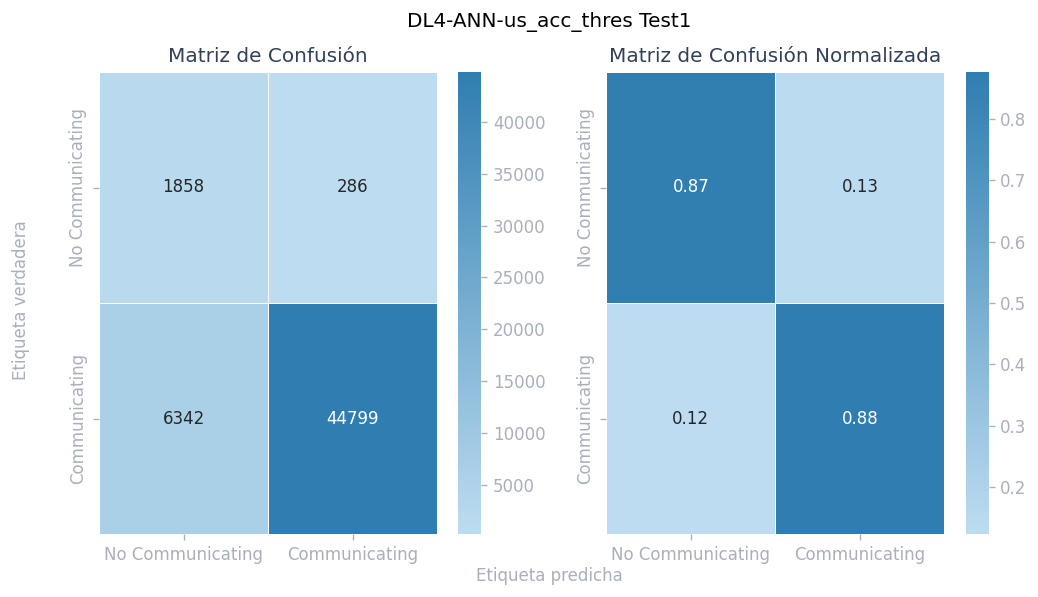

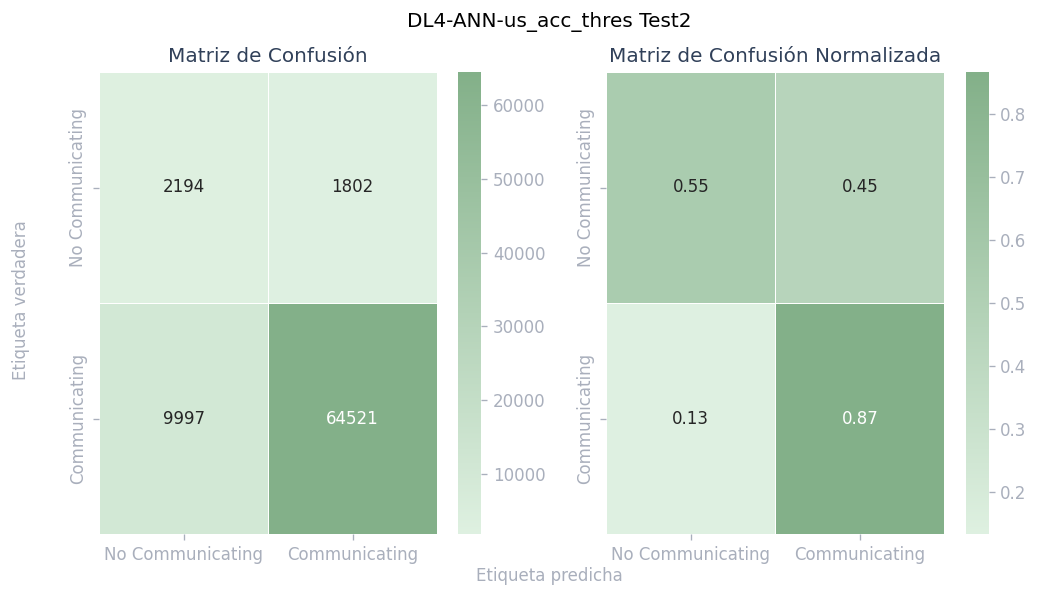

Metrics for DL4-ANN-us Test 1_mpca_thres
Thres Value: 0.4099999999999998
Accuracy: 0.8718964061180445
F1 Score Micro: 0.8718964061180445
F1 Score Macro: 0.6411298720938551
F1 Score Weighted: 0.905747997198192
Precission: 0.9937824526998418
Recall: 0.8719813847988893
Metrics for DL4-ANN-us Test 2_mpca_thres
Thres Value: 0.4099999999999998
Accuracy: 0.8463586112030975
F1 Score Micro: 0.8463586112030975
F1 Score Macro: 0.5914249954639955
F1 Score Weighted: 0.8813108118936859
Precission: 0.9730364311141407
Recall: 0.8620064950750155


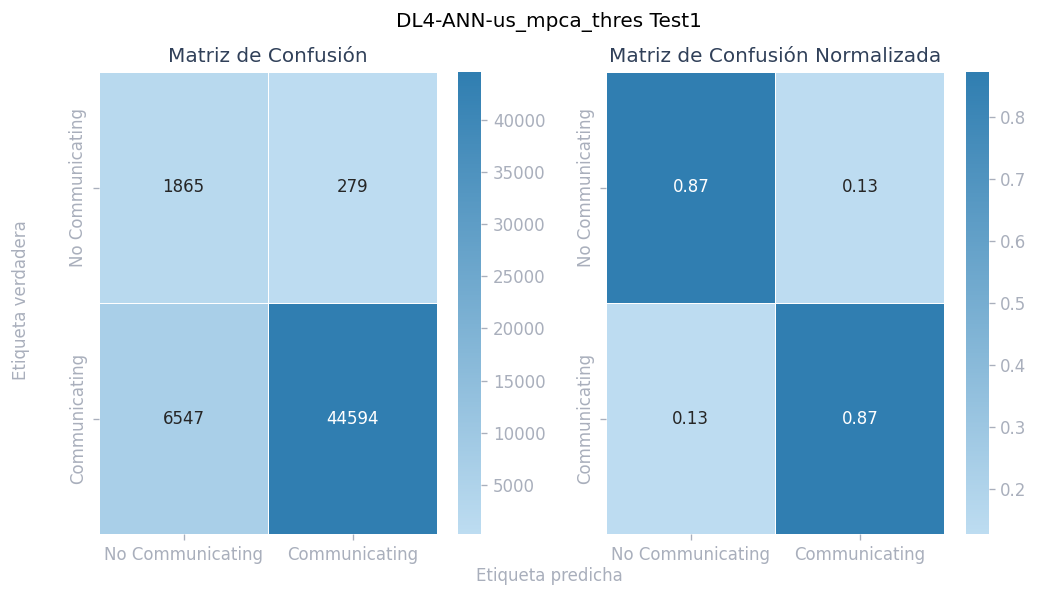

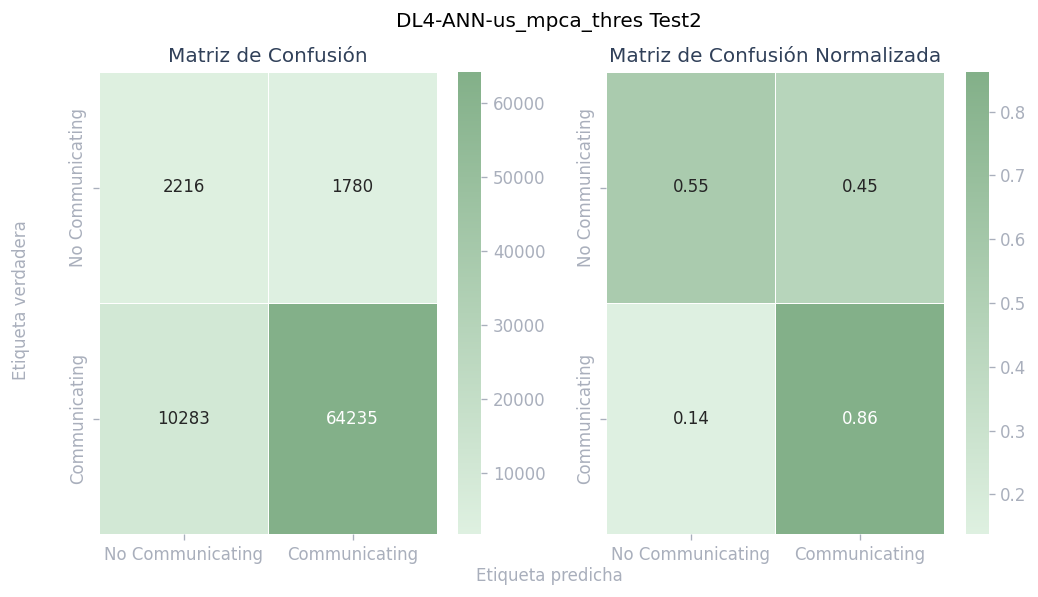

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL4'
temp_id = get_run_id(temp_exp_name, "ann_training_us")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL4-ANN-us",temp_thresholds)

2454/2454 [==============================] - 2s 985us/step
Metrics for DL4-ANN-os_1 Test 1_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9628788589659378
F1 Score Micro: 0.9628788589659378
F1 Score Macro: 0.8227749058174627
F1 Score Weighted: 0.9676695465168704
Precission: 0.9963853718624422
Recall: 0.9648227449600125
Metrics for DL4-ANN-os_1 Test 2_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9139134421886542
F1 Score Micro: 0.9139134421886542
F1 Score Macro: 0.6043523291192352
F1 Score Weighted: 0.9186962191087467
Precission: 0.9612907617945401
Recall: 0.9474489385115006


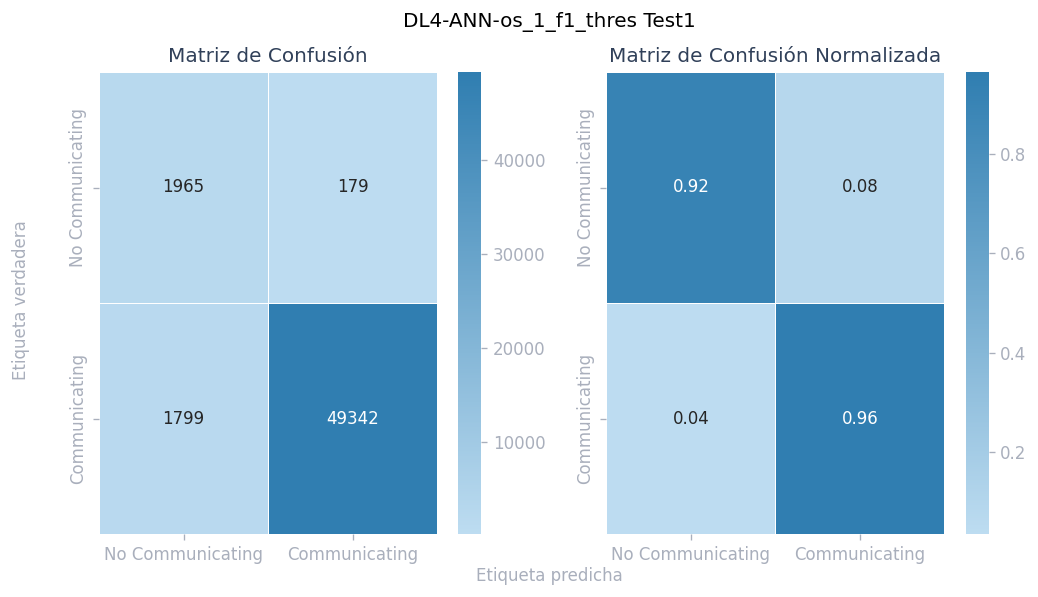

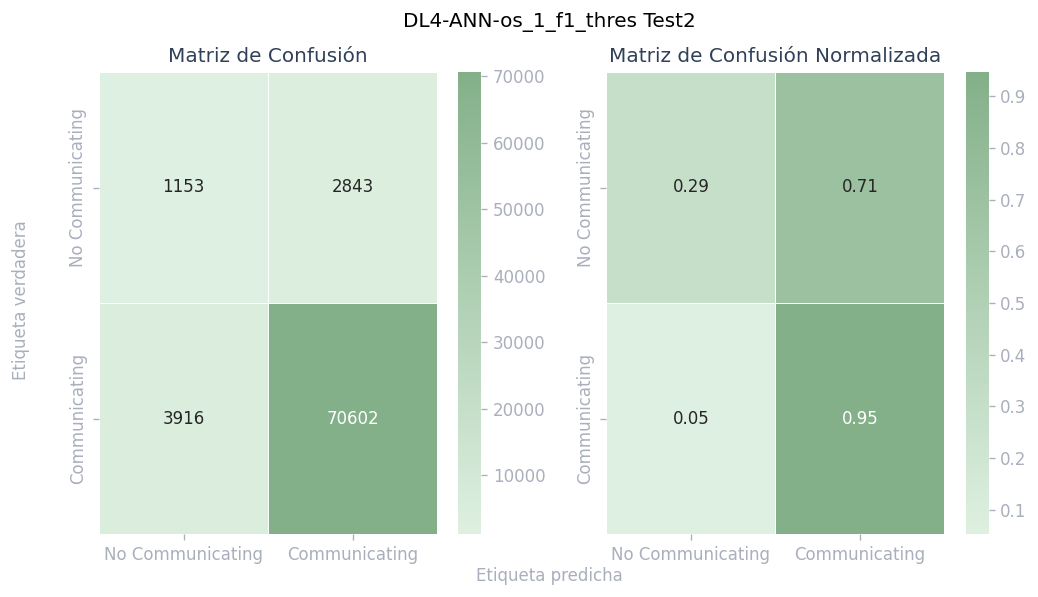

Metrics for DL4-ANN-os_1 Test 1_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9628788589659378
F1 Score Micro: 0.9628788589659378
F1 Score Macro: 0.8227749058174627
F1 Score Weighted: 0.9676695465168704
Precission: 0.9963853718624422
Recall: 0.9648227449600125
Metrics for DL4-ANN-os_1 Test 2_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9139134421886542
F1 Score Micro: 0.9139134421886542
F1 Score Macro: 0.6043523291192352
F1 Score Weighted: 0.9186962191087467
Precission: 0.9612907617945401
Recall: 0.9474489385115006


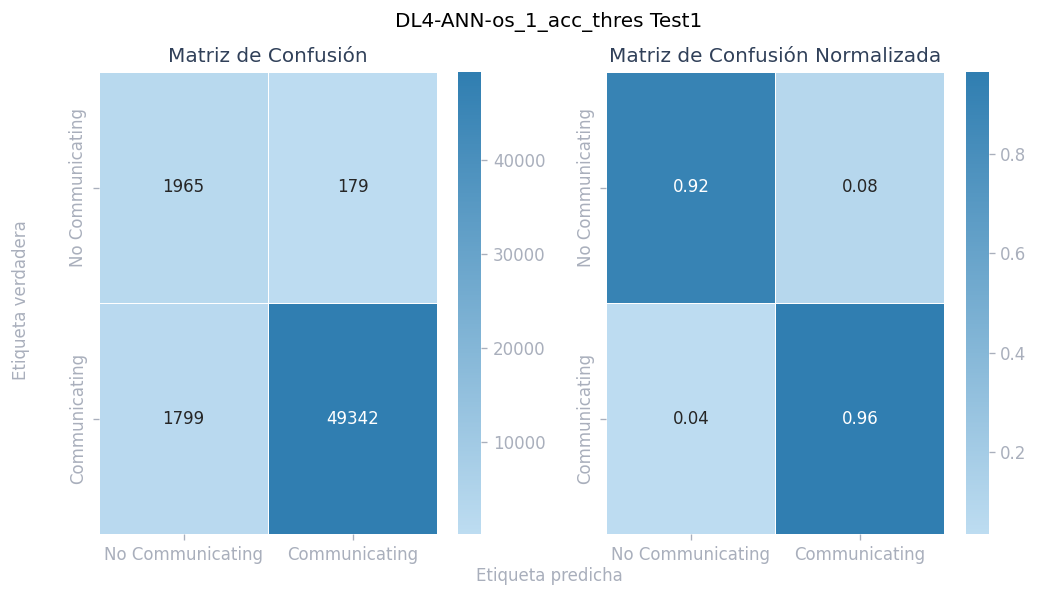

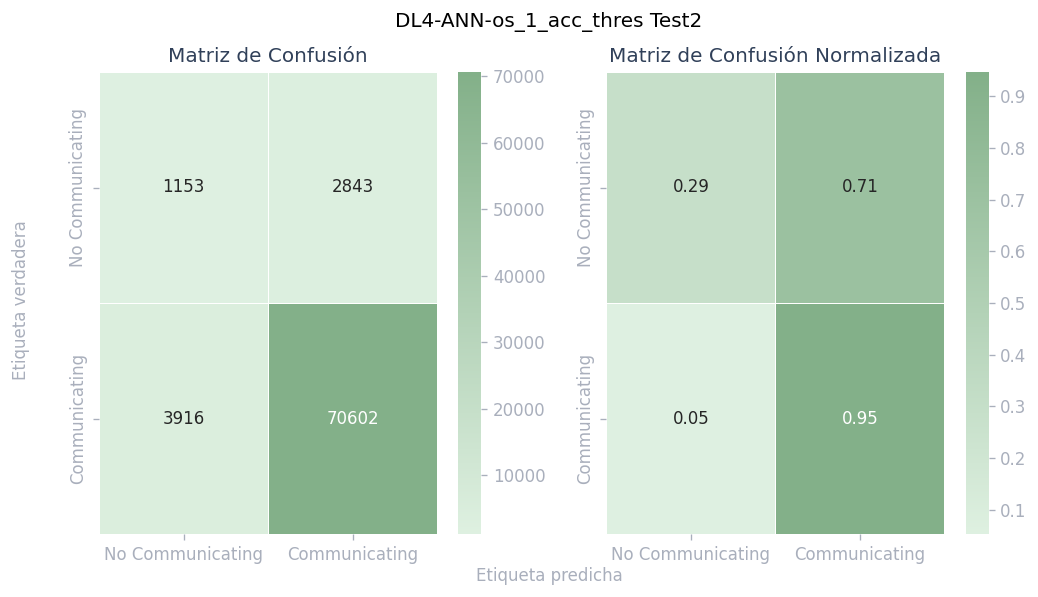

Metrics for DL4-ANN-os_1 Test 1_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9628788589659378
F1 Score Micro: 0.9628788589659378
F1 Score Macro: 0.8227749058174627
F1 Score Weighted: 0.9676695465168704
Precission: 0.9963853718624422
Recall: 0.9648227449600125
Metrics for DL4-ANN-os_1 Test 2_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9139134421886542
F1 Score Micro: 0.9139134421886542
F1 Score Macro: 0.6043523291192352
F1 Score Weighted: 0.9186962191087467
Precission: 0.9612907617945401
Recall: 0.9474489385115006


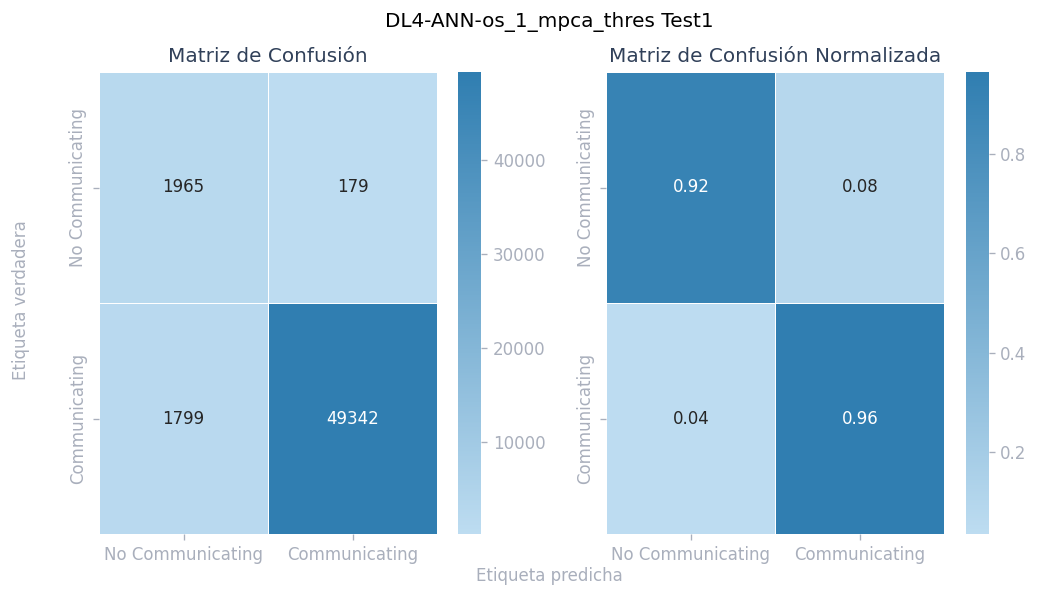

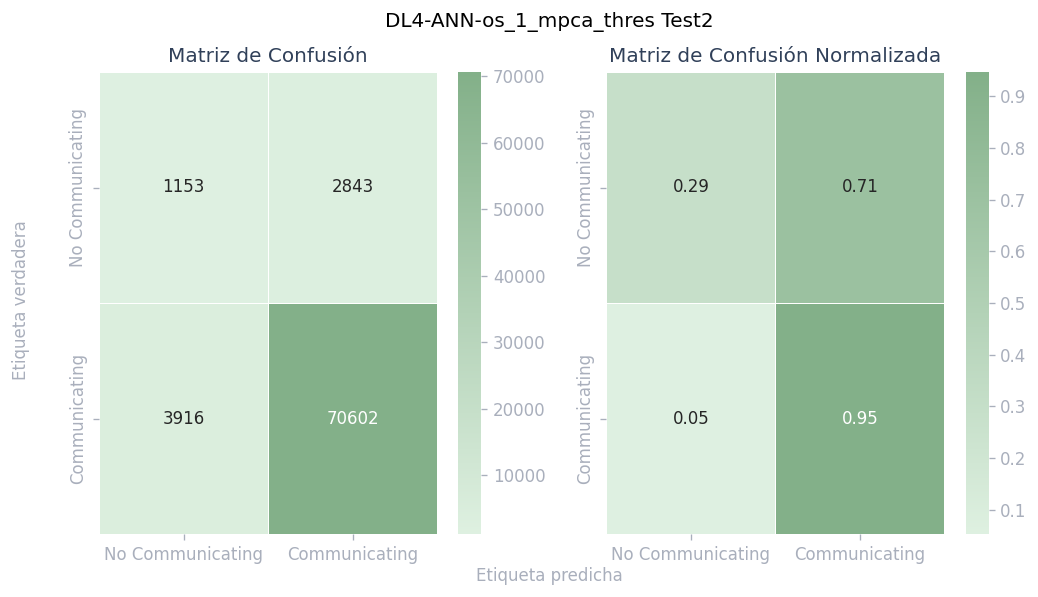

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL4'
temp_id = get_run_id(temp_exp_name, "ann_training_os_1")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL4-ANN-os_1",temp_thresholds)

2454/2454 [==============================] - 3s 1ms/step
Metrics for DL4-ANN-os_2 Test 1_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9676644459041006
F1 Score Micro: 0.9676644459041006
F1 Score Macro: 0.8397085647503535
F1 Score Weighted: 0.9713976571064733
Precission: 0.9966433510210645
Recall: 0.9695743141510725
Metrics for DL4-ANN-os_2 Test 2_f1_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9238225029930968
F1 Score Micro: 0.9238225029930968
F1 Score Macro: 0.6244157505827241
F1 Score Weighted: 0.9256206263118051
Precission: 0.9624816119411043
Recall: 0.9570439356933895


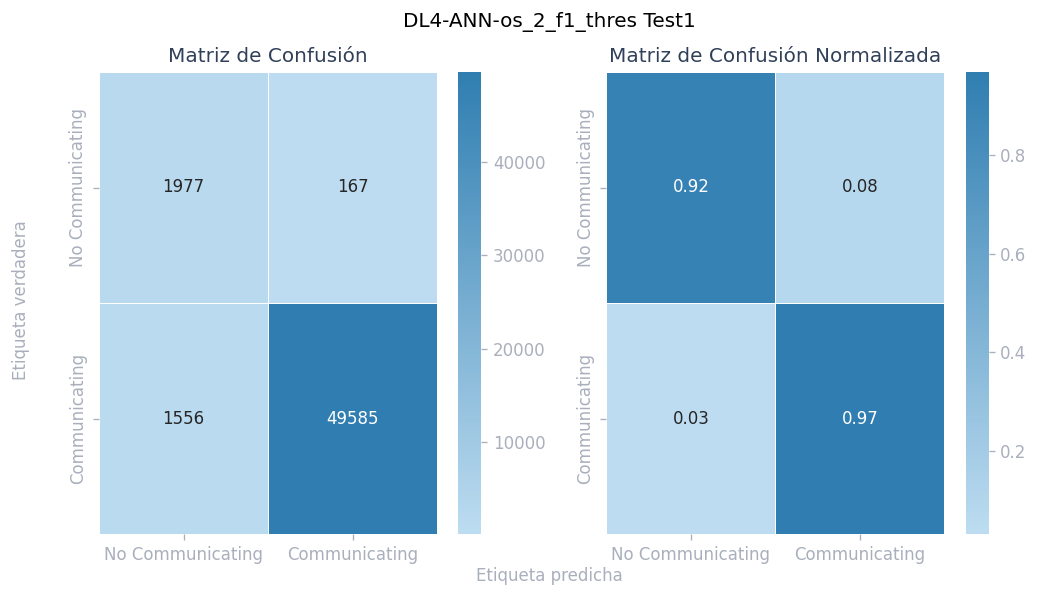

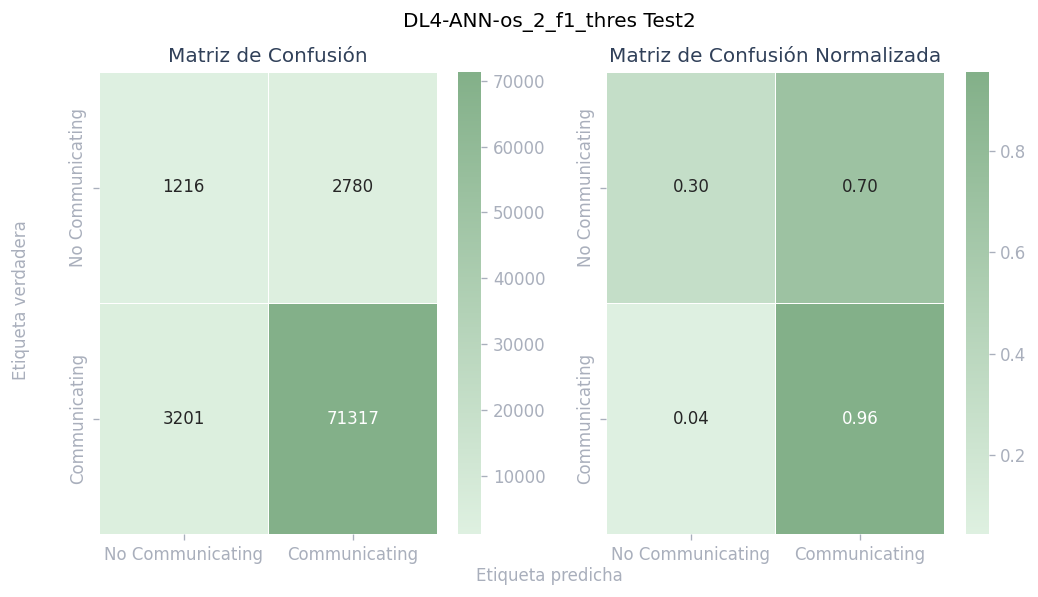

Metrics for DL4-ANN-os_2 Test 1_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9676644459041006
F1 Score Micro: 0.9676644459041006
F1 Score Macro: 0.8397085647503535
F1 Score Weighted: 0.9713976571064733
Precission: 0.9966433510210645
Recall: 0.9695743141510725
Metrics for DL4-ANN-os_2 Test 2_acc_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9238225029930968
F1 Score Micro: 0.9238225029930968
F1 Score Macro: 0.6244157505827241
F1 Score Weighted: 0.9256206263118051
Precission: 0.9624816119411043
Recall: 0.9570439356933895


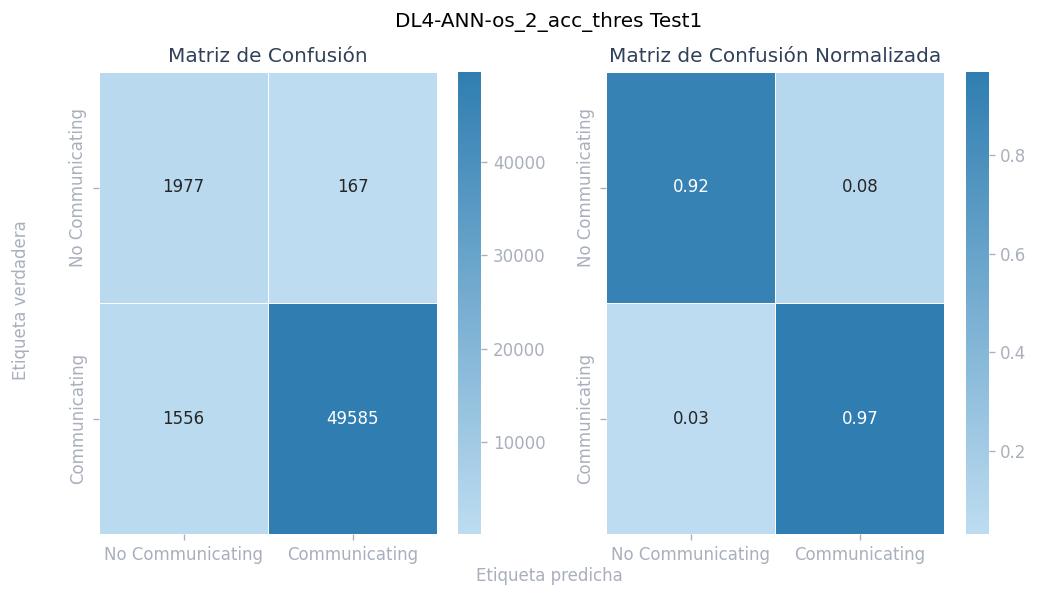

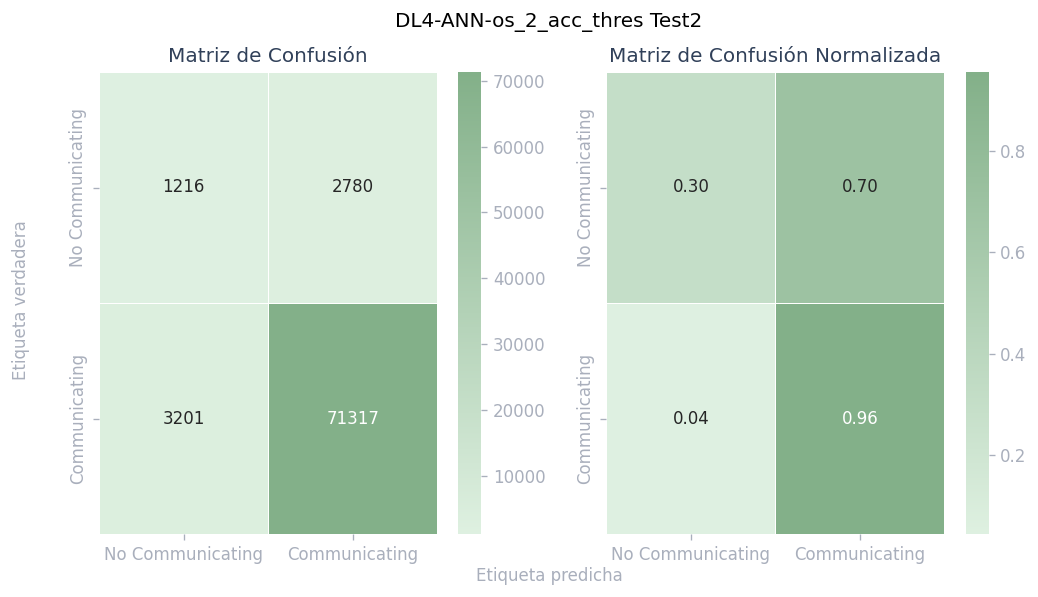

Metrics for DL4-ANN-os_2 Test 1_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9676644459041006
F1 Score Micro: 0.9676644459041006
F1 Score Macro: 0.8397085647503535
F1 Score Weighted: 0.9713976571064733
Precission: 0.9966433510210645
Recall: 0.9695743141510725
Metrics for DL4-ANN-os_2 Test 2_mpca_thres
Thres Value: 0.5099999999999998
Accuracy: 0.9238225029930968
F1 Score Micro: 0.9238225029930968
F1 Score Macro: 0.6244157505827241
F1 Score Weighted: 0.9256206263118051
Precission: 0.9624816119411043
Recall: 0.9570439356933895


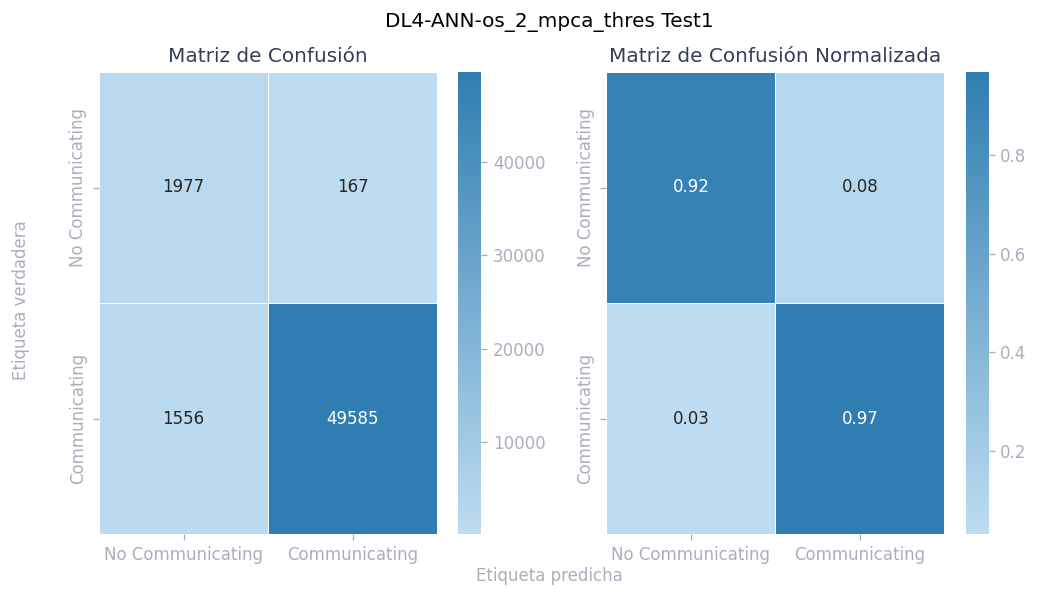

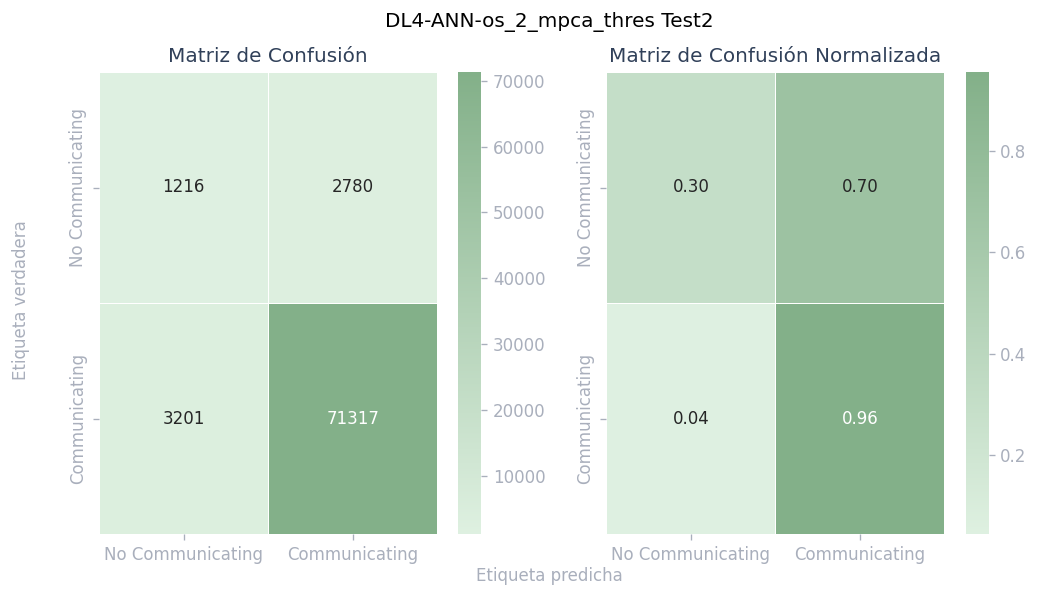

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL4'
temp_id = get_run_id(temp_exp_name, "ann_training_os_2")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL4-ANN-os_2",temp_thresholds)

2454/2454 [==============================] - 2s 927us/step
Metrics for DL6-ANN-os_1 Test 1_f1_thres
Thres Value: 0.9899999999999995
Accuracy: 0.805705170310594
F1 Score Micro: 0.805705170310594
F1 Score Macro: 0.5800423242823365
F1 Score Weighted: 0.8631145840582332
Precission: 0.9949519464129696
Recall: 0.8016268747189144
Metrics for DL6-ANN-os_1 Test 2_f1_thres
Thres Value: 0.9899999999999995
Accuracy: 0.7831469546832412
F1 Score Micro: 0.7831469546832414
F1 Score Macro: 0.5388116870229044
F1 Score Weighted: 0.8403272561756704
Precission: 0.9701360722229491
Recall: 0.7960224375318715


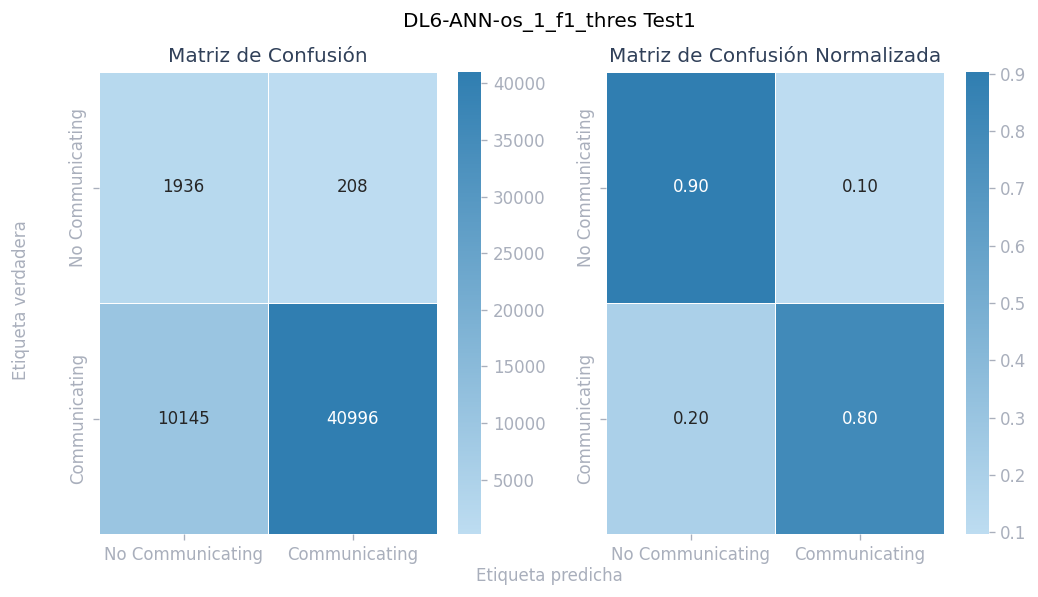

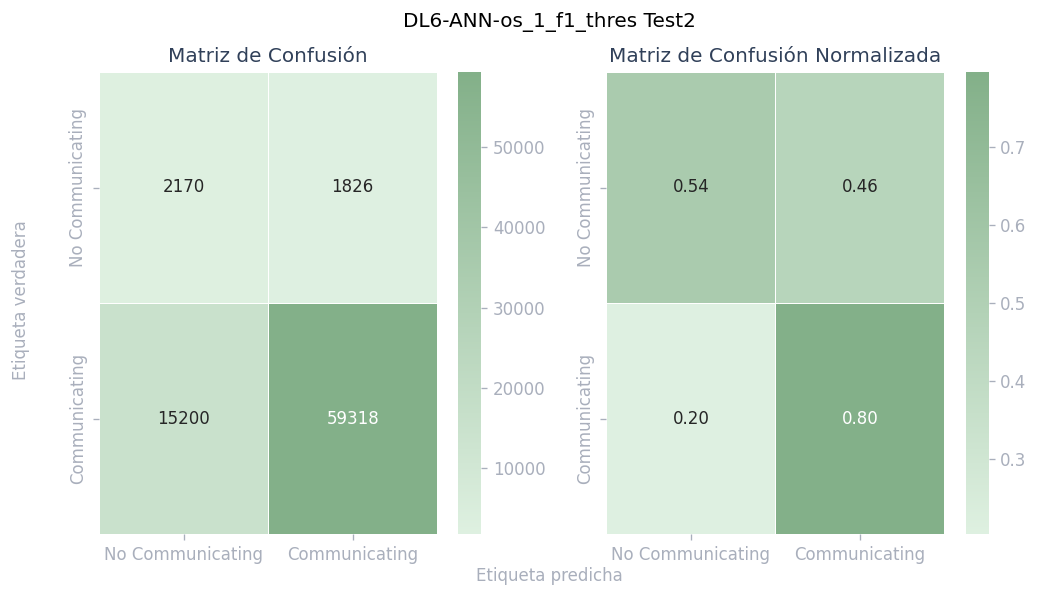

Metrics for DL6-ANN-os_1 Test 1_acc_thres
Thres Value: 0.9899999999999995
Accuracy: 0.805705170310594
F1 Score Micro: 0.805705170310594
F1 Score Macro: 0.5800423242823365
F1 Score Weighted: 0.8631145840582332
Precission: 0.9949519464129696
Recall: 0.8016268747189144
Metrics for DL6-ANN-os_1 Test 2_acc_thres
Thres Value: 0.9899999999999995
Accuracy: 0.7831469546832412
F1 Score Micro: 0.7831469546832414
F1 Score Macro: 0.5388116870229044
F1 Score Weighted: 0.8403272561756704
Precission: 0.9701360722229491
Recall: 0.7960224375318715


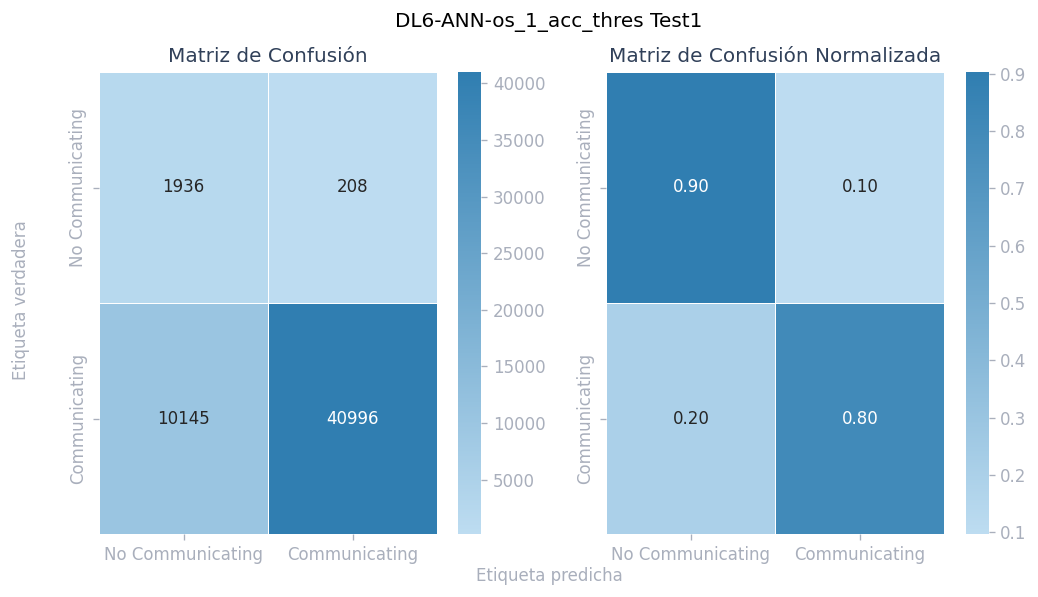

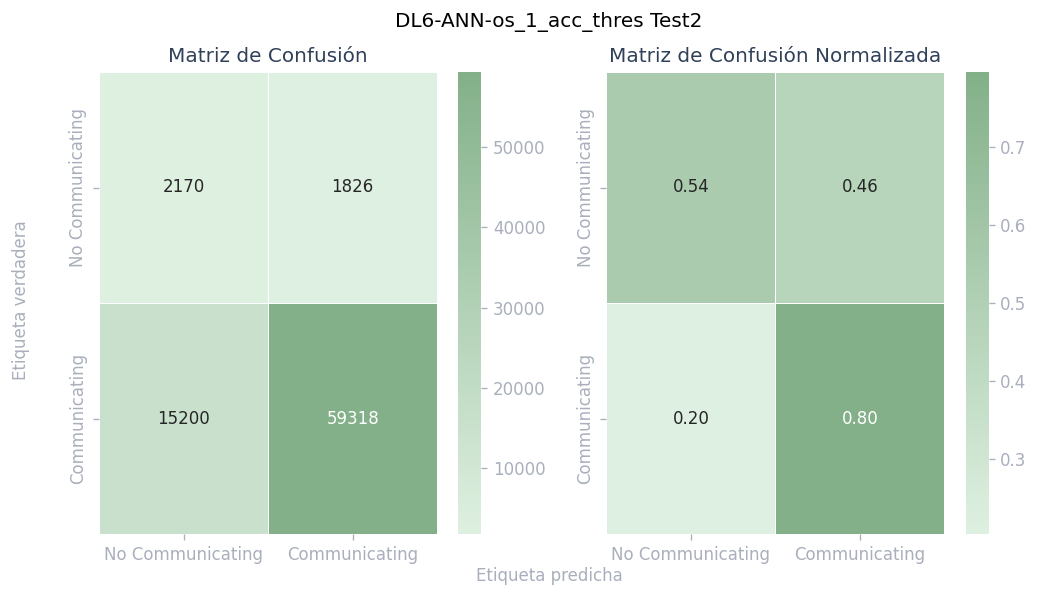

Metrics for DL6-ANN-os_1 Test 1_mpca_thres
Thres Value: 0.9899999999999995
Accuracy: 0.805705170310594
F1 Score Micro: 0.805705170310594
F1 Score Macro: 0.5800423242823365
F1 Score Weighted: 0.8631145840582332
Precission: 0.9949519464129696
Recall: 0.8016268747189144
Metrics for DL6-ANN-os_1 Test 2_mpca_thres
Thres Value: 0.9899999999999995
Accuracy: 0.7831469546832412
F1 Score Micro: 0.7831469546832414
F1 Score Macro: 0.5388116870229044
F1 Score Weighted: 0.8403272561756704
Precission: 0.9701360722229491
Recall: 0.7960224375318715


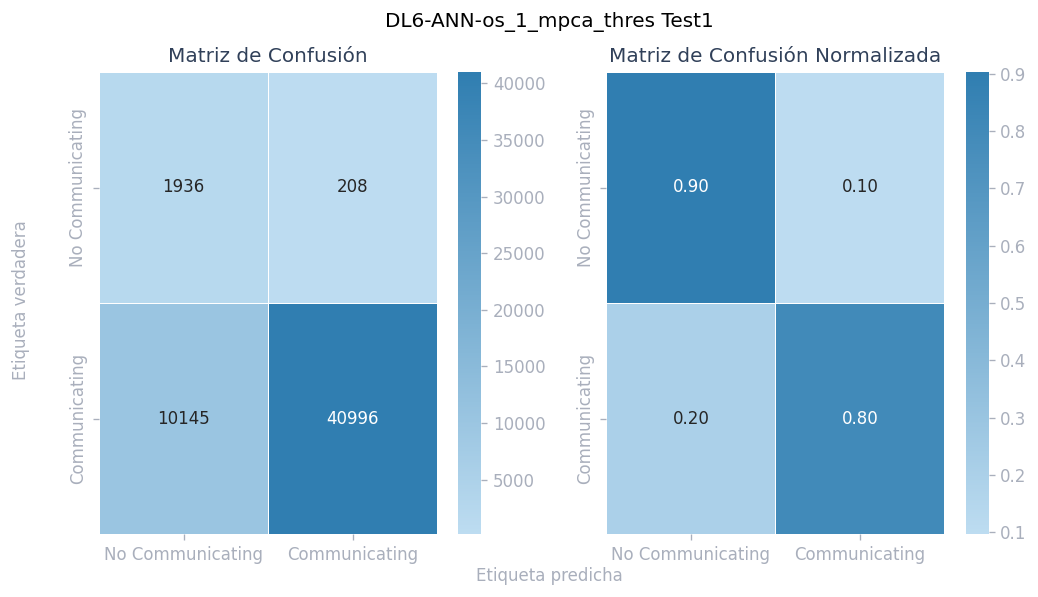

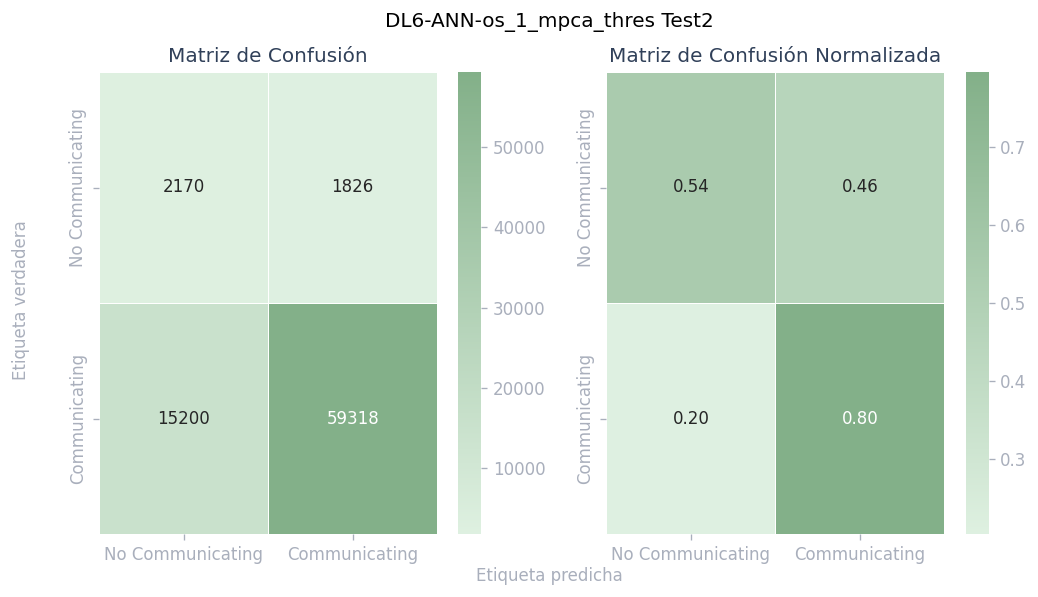

In [0]:
#Obteniendo modelo de DL
temp_exp_name = '/Users/victor.hugo.borrayo@gmail.com/DL6'
temp_id = get_run_id(temp_exp_name, "ann6_training_os_1")
temp_model = mlflow.keras.load_model(f"runs:/{temp_id}/best_model")
#Obteniendo thresholds
temp_run = mlflow.get_run(temp_id)
parameters = temp_run.data.params
temp_thresholds = {
    'f1_thres': parameters.get('f1_thres'),
    'acc_thres': parameters.get('acc_thres'),
    'mpca_thres': parameters.get('mpca_thres')
}
metrics_and_cmatrix(temp_model, tests_dic, "DL6-ANN-os_1",temp_thresholds)